In [8]:
import re
from collections import defaultdict
import jsonpickle
from proquest_text_parser import *

from emfdscore.scoring import score_docs
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np
from pickMFU import DataFrame_MF_Wrapper

print(f"spaCy version: {spacy.__version__}")
print(f"Pandas version: {pd.__version__}")

spaCy version: 3.4.0
Pandas version: 1.5.1


# Process Raw text files

In [9]:
# ID with pub title
dir = "./data/raw_240227/voice"
file_num = 11
date = "2024-02-28"
voice_raw_list = main_parser_proquest(dir, file_num, date)
voice_dict = text2dict(voice_raw_list, remove_duplicate=False)

dir = "./data/raw_240227/yes"
file_num = 3
date = "2024-02-27"
yes_raw_list = main_parser_proquest(dir, file_num, date)
yes_dict = text2dict(yes_raw_list, remove_duplicate=False)

dir = "./data/raw_240227/no"
file_num = 2
date = "2024-02-27"
no_raw_list = main_parser_proquest(dir, file_num, date)
no_dict = text2dict(no_raw_list, remove_duplicate=False)

dir = './data/raw_240322/Factiva-20240322-1210.rtf'
rft_parser = FactivaRtfParser()
wa_dict = rft_parser.parse(dir, remove_duplicate=False)

print(f"voice corpus size: {len(voice_dict)}")
print(f"yes corpus size: {len(yes_dict)}")
print(f"no corpus size: {len(no_dict)}")
print(f"wa corpus size: {len(wa_dict)}")
print("Size sum is", len(voice_dict)+len(yes_dict)+len(no_dict)+len(wa_dict))

voice corpus size: 2012
yes corpus size: 469
no corpus size: 392
wa corpus size: 76
Size sum is 2949


In [10]:
dict_collection = [voice_dict, yes_dict, no_dict, wa_dict]
all_dict = {}
for corpus in dict_collection:
    key_list = [key for key in corpus.keys()]
    for key in key_list:
        all_dict[key] = corpus[key]

print("all_dict size", len(all_dict.keys()))

all_dict size 2430


# Analyse articles

### Apply three versions of mfd on articles

In [11]:
# Convert all_dict to format which can be ingested by dataframe.
key_list = [key for key in all_dict.keys()]
column_names = list(all_dict[key_list[0]].keys())

pre_df = dict()
pre_df['id'] = key_list
for col in column_names:
    pre_df[col] = list()
    for key in key_list:
        pre_df[col].append(all_dict[key][col])

df = pd.DataFrame(pre_df)
df.head()

id  \
0              IvtpreaLh-TA(CA-20231119-national   
1  WtIVtPrfSftIVtPwisswdtrf-7S-20231031-national   
2       SGlIvtprd‘fietsN-TA(CA-20231030-national   
3             QclvtpfrAc-TA(CA-20231023-national   
4        VsNtaIvtpbAAsil-TA(CA-20231018-national   

                                                text  \
0  The spiritual home of Holden and Cold Chisel m...   
1  ANTONY GREEN, ELECTION ANALYST: The ballot pap...   
2  In an emotive speech delivered in Canberra on ...   
3  On Queensland’s Mornington Island, where 77 pe...   
4  For the Yes campaign, convinced of its righteo...   

                                               title      date  \
0  Indigenous voice to parliament resentment echo...  20231119   
1  Why the Indigenous Voice to Parliament referen...  20231031   
2  Stan Grant laments Indigenous voice to parliam...  20231030   
3  Queensland considers local voice to parliament...  20231023   
4  Voters said No to an Indigenous voice to parli...  20231018   

                             publisher  \
0              Nationwide News Pty Ltd   
1  Australian Broadcasting Corporation   
2              Nationwide News Pty Ltd   
3              Nationwide News Pty Ltd   
4              Nationwide News Pty Ltd   

                                   pub_title edit_stance     state  \
0  The Australian (Online); Canberra, A.C.T.       right  national   
1                               7.30; Sydney     neutral  national   
2  The Australian (Online); Canberra, A.C.T.       right  national   
3  The Australian (Online); Canberra, A.C.T.       right  national   
4  The Australian (Online); Canberra, A.C.T.       right  national   

         source   doc  
0     Newspaper  News  
1  Other Source  News  
2     Newspaper  News  
3     Newspaper  News  
4     Newspaper  News

In [12]:
# Slightly < 12 minutes
mfd_wrapper = DataFrame_MF_Wrapper(df)
df_mfd = mfd_wrapper.compute_mfd_score('mfd')
df_mfd2 = mfd_wrapper.compute_mfd_score('mfd2')
df_emfd = mfd_wrapper.compute_mfd_score('emfd')

In [13]:
df_mfd['date'] = df_mfd['date'].apply(lambda x: '-'.join([x[:4], x[4:6], x[6:]]) if x else None)
df_mfd2['date'] = df_mfd2['date'].apply(lambda x: '-'.join([x[:4], x[4:6], x[6:]]) if x else None)
df_emfd['date'] = df_emfd['date'].apply(lambda x: '-'.join([x[:4], x[4:6], x[6:]]) if x else None)
df_mfd['date'] = pd.to_datetime(df_mfd['date'])
df_mfd2['date'] = pd.to_datetime(df_mfd2['date'])
df_emfd['date'] = pd.to_datetime(df_emfd['date'])

### Media, edit_stance aggregation

##### Aggregate by only editorial stances

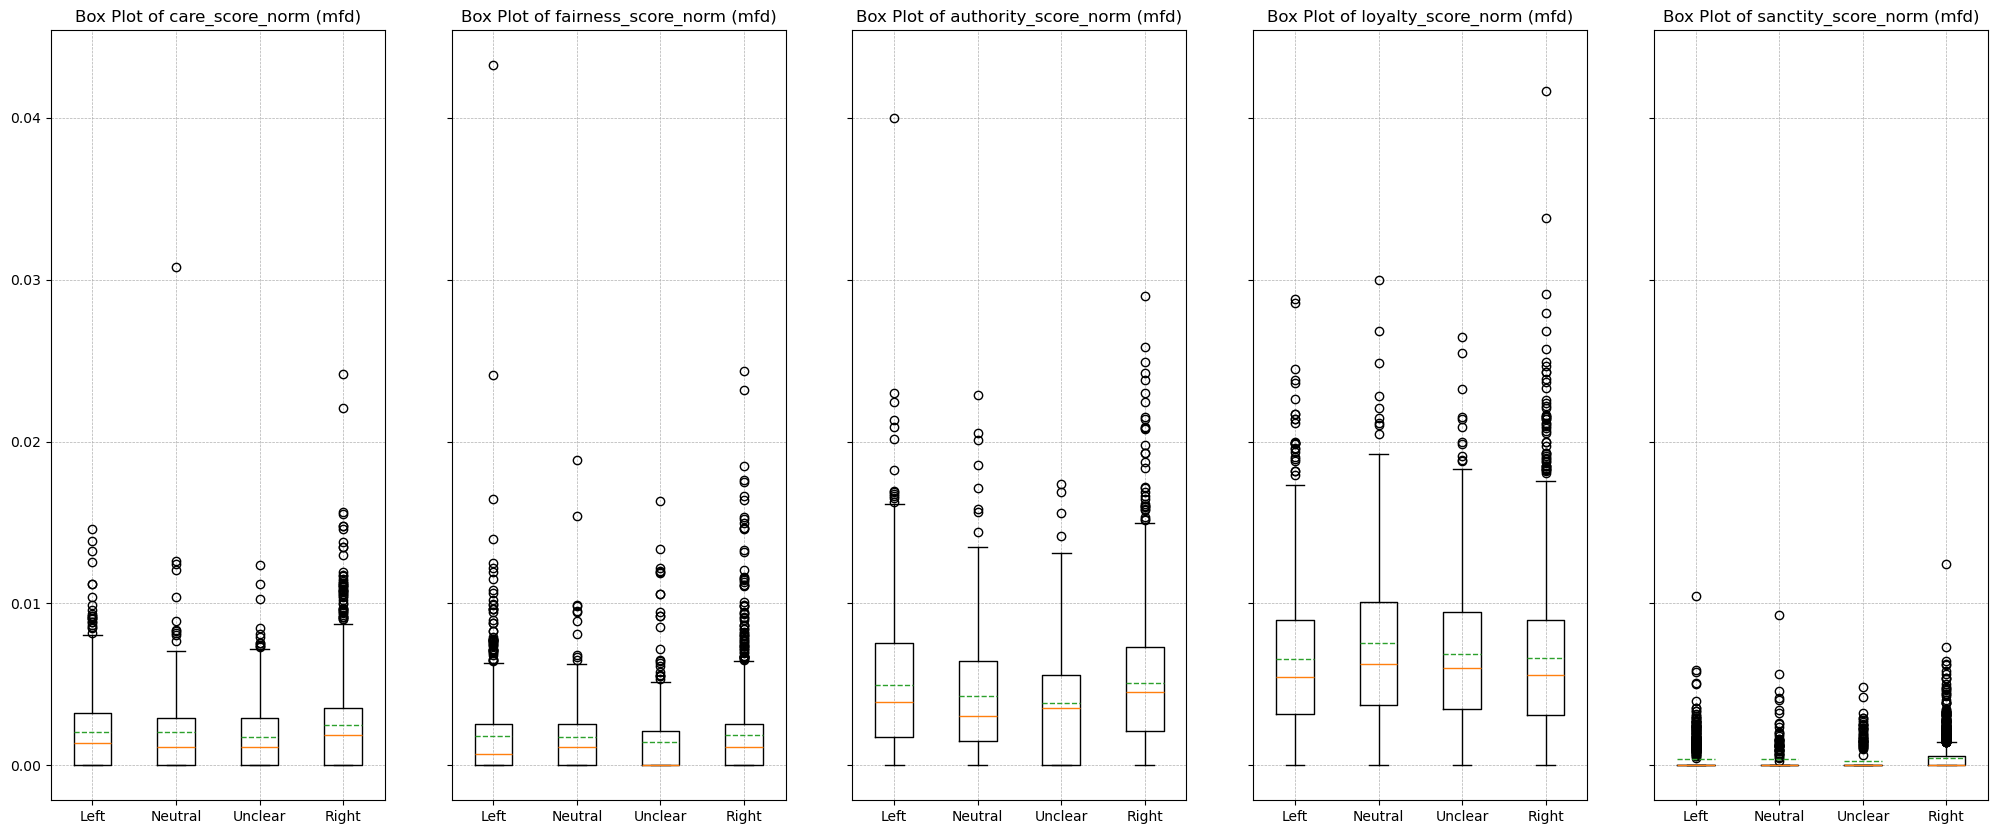

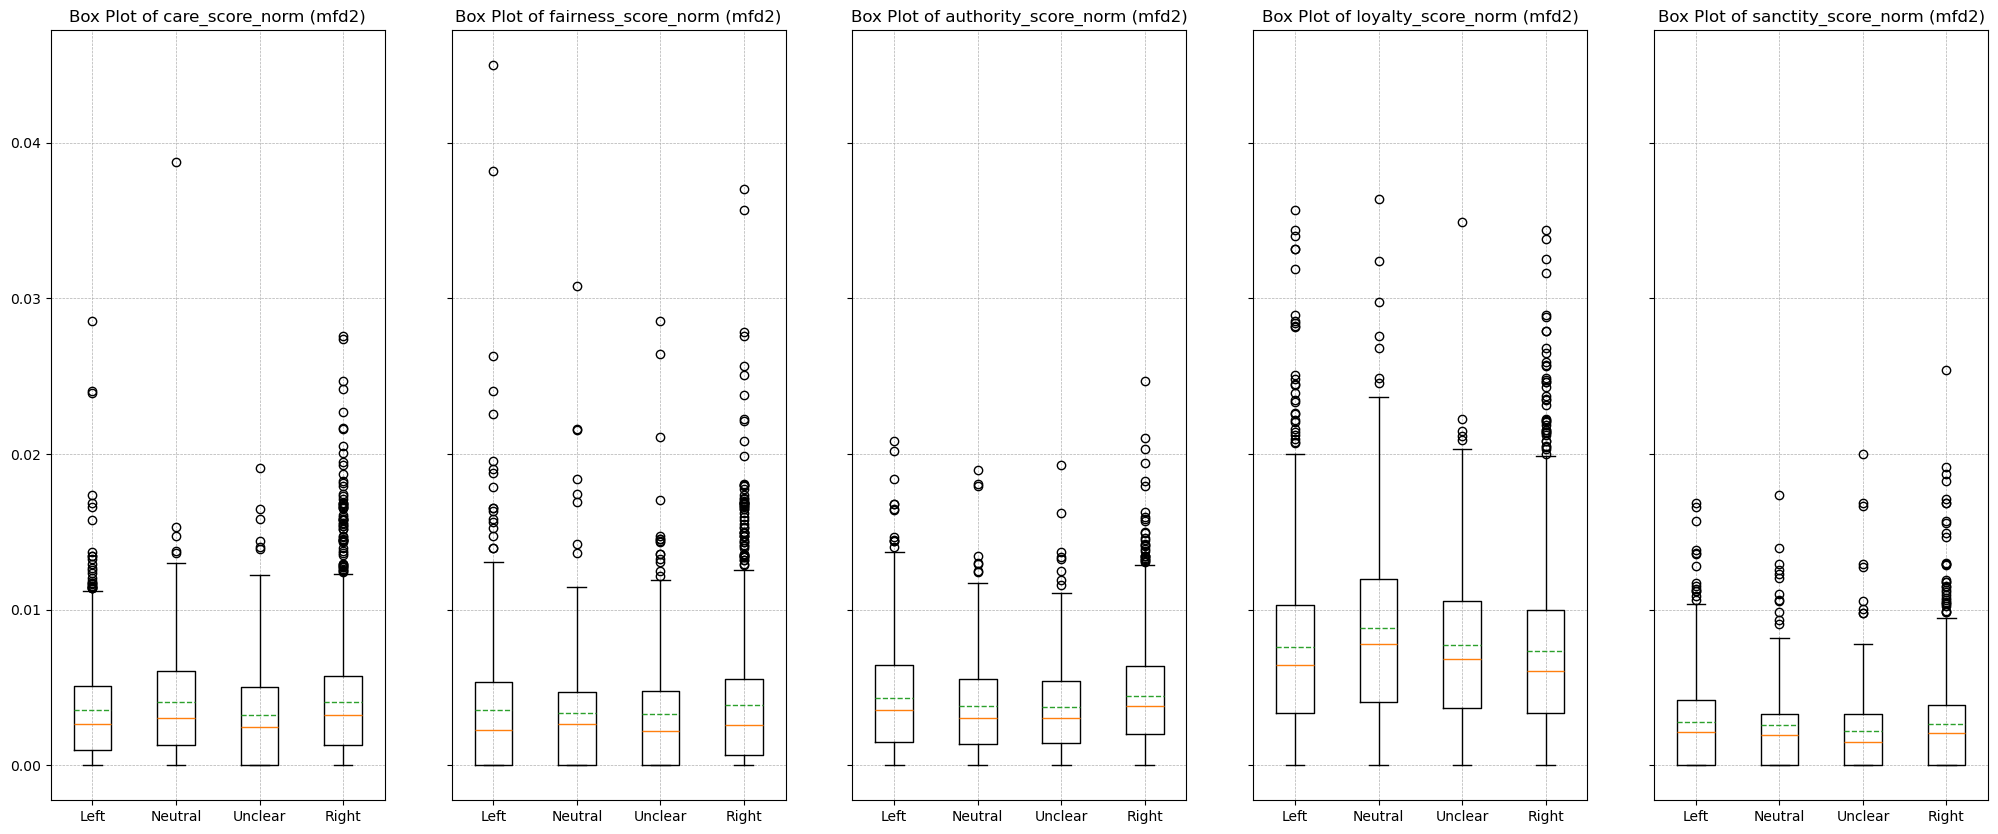

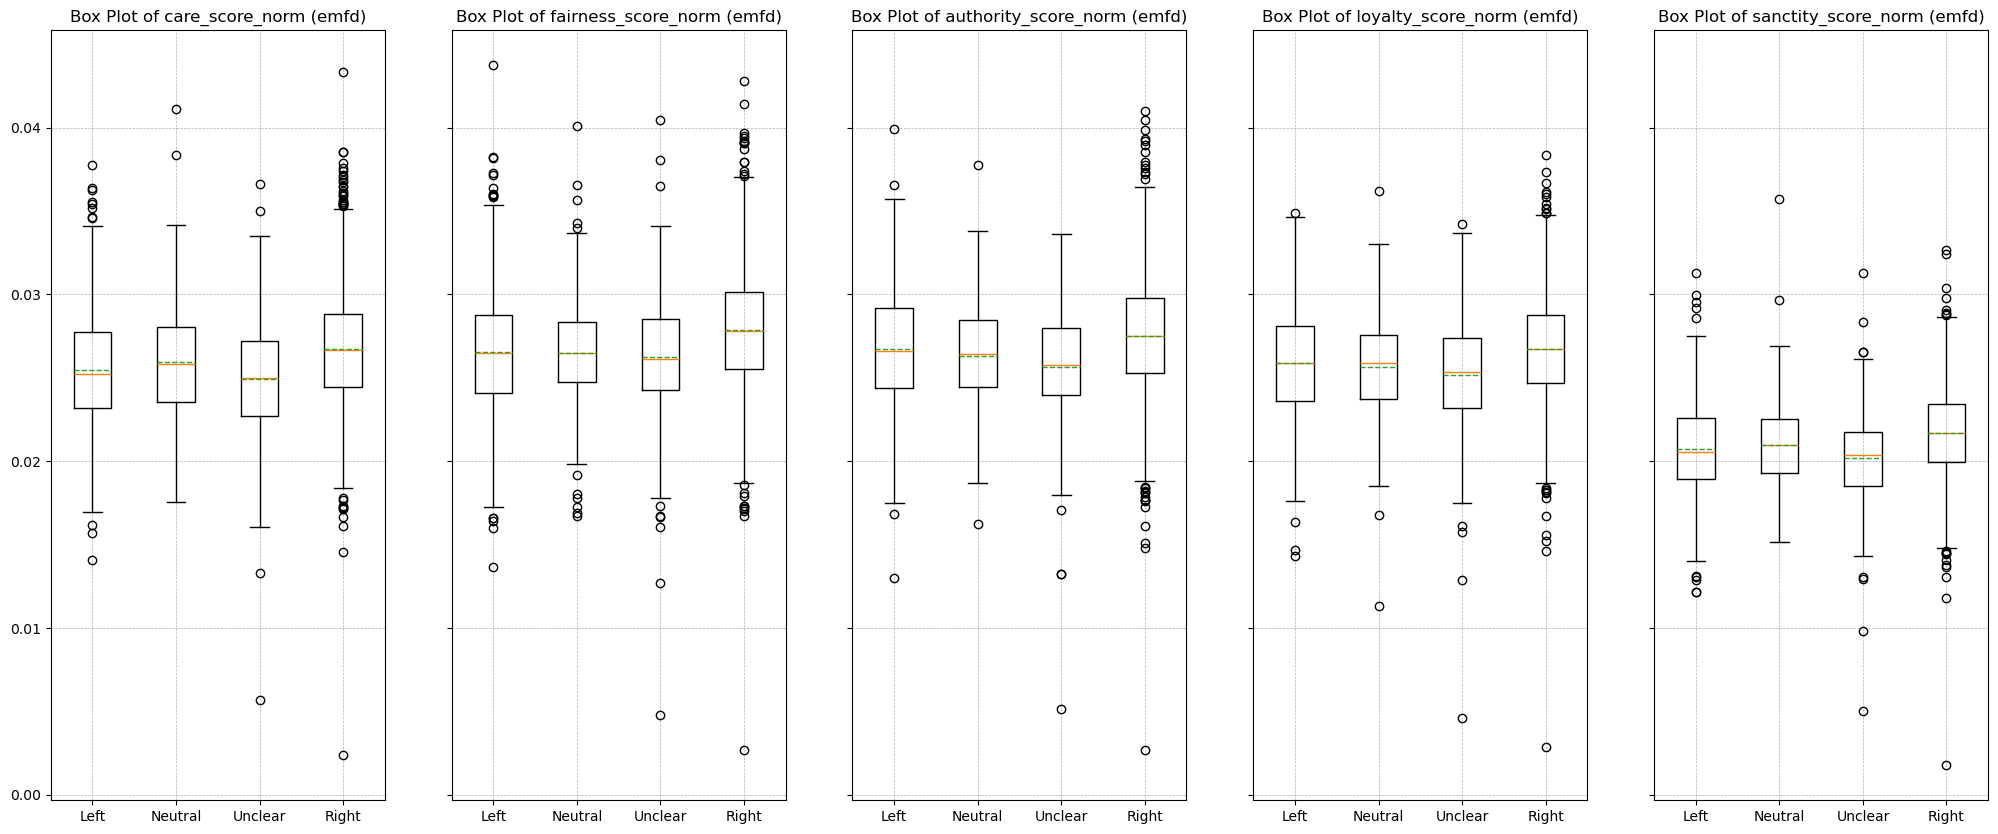

In [14]:
# Calculate scores
moral_foundations = ['care', 'fairness', 'authority', 'loyalty', 'sanctity']
df_list = [df_mfd, df_mfd2, df_emfd]
for i in range(len(df_list)):
    df_instance = df_list[i]
    for mf in moral_foundations:
        virtue_score = df_instance[f'{mf}.virtue']
        vice_score = df_instance[f'{mf}.vice']
        token_num = df_instance['text'].apply(lambda x: len(x.split()))
        df_instance[f'{mf}_score_norm'] = ( virtue_score + vice_score )/token_num

# Plot
mfd_vers = ['mfd', 'mfd2', 'emfd']
for j in range(len(df_list)):
    df_target = df_list[j]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 10), sharey=True)

    foundations = ['care', 'fairness', 'authority', 'loyalty', 'sanctity']
    for i in range(5):
        f = foundations[i]
        axs[i].boxplot([
            df_target[df_target['edit_stance']=='left'][f'{f}_score_norm'],
            df_target[df_target['edit_stance']=='neutral'][f'{f}_score_norm'],
            df_target[df_target['edit_stance']=='unclear'][f'{f}_score_norm'],
            df_target[df_target['edit_stance']=='right'][f'{f}_score_norm'],
        ], meanline=True, showmeans=True)

        axs[i].set_title(f'Box Plot of {f}_score_norm ({mfd_vers[j]})')
        axs[i].set_xticklabels(['Left', 'Neutral', 'Unclear', 'Right'])

        # Config grids
        axs[i].grid(linestyle='--', linewidth=0.5)

    plt.show()

    # df_pub_title_filtered.groupby('edit_stance').mean()

##### Mean aggregated by media (pub_title)

The Mercury (Online); Hobart Town
The Age; Melbourne, Vic.
WAToday.com.au
Advocate; Burnie, Tas.
The Northern Territory News; Darwin, N.T.
7.30; Sydney
The Advertiser; Adelaide, S. Aust.
Herald Sun; Melbourne, Vic.
The West Australian
Sunday Age; Melbourne, Vic.
The Courier - Mail; Brisbane, Qld.
Sydney Morning Herald; Sydney, N.S.W.
Sun-Herald; Sydney, N.S.W.
The Examiner; Launceston, Tas.
The Australian (Online); Canberra, A.C.T.
ABC Premium News; Sydney
The Daily Telegraph (Online); Surrey Hills, N.S.W.
The Canberra Times; Canberra, A.C.T.


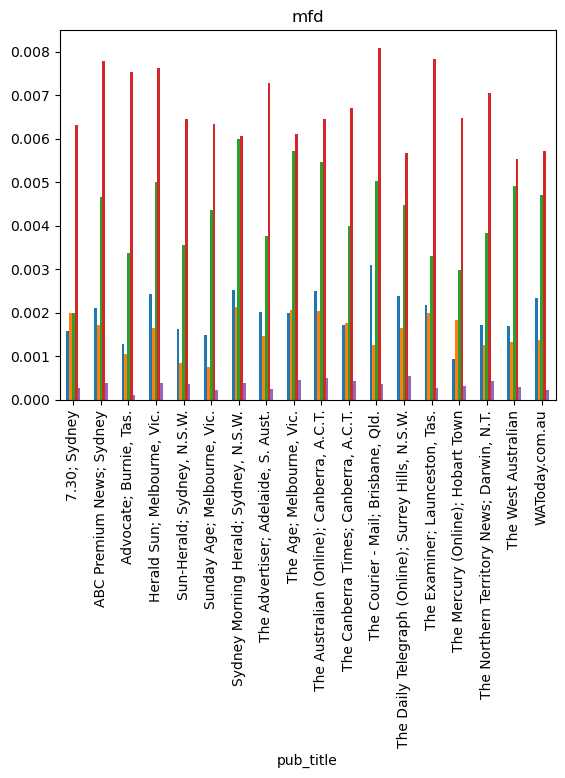

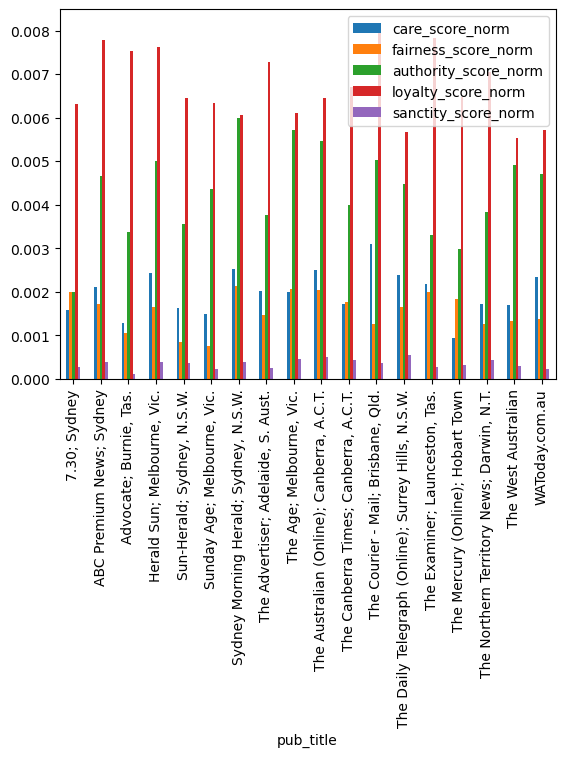

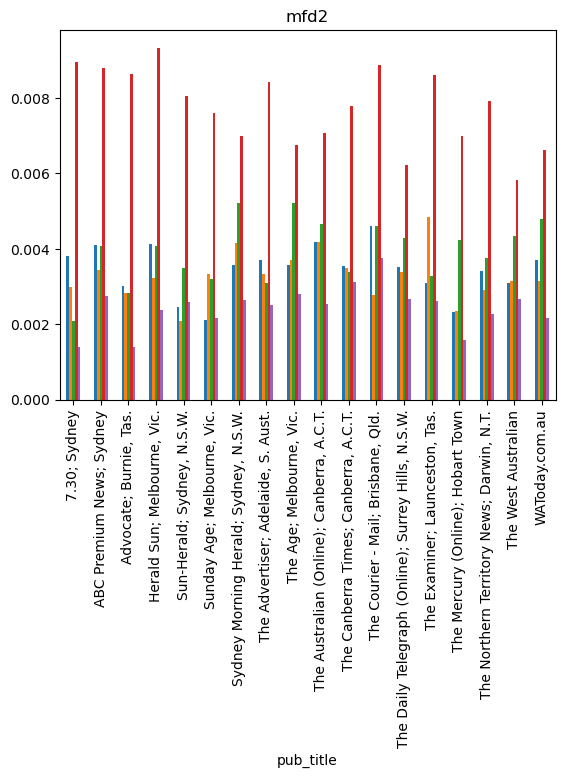

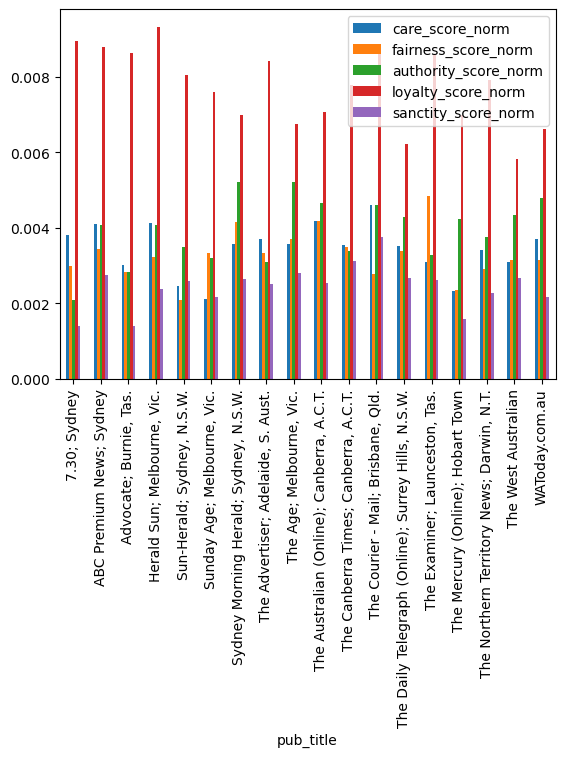

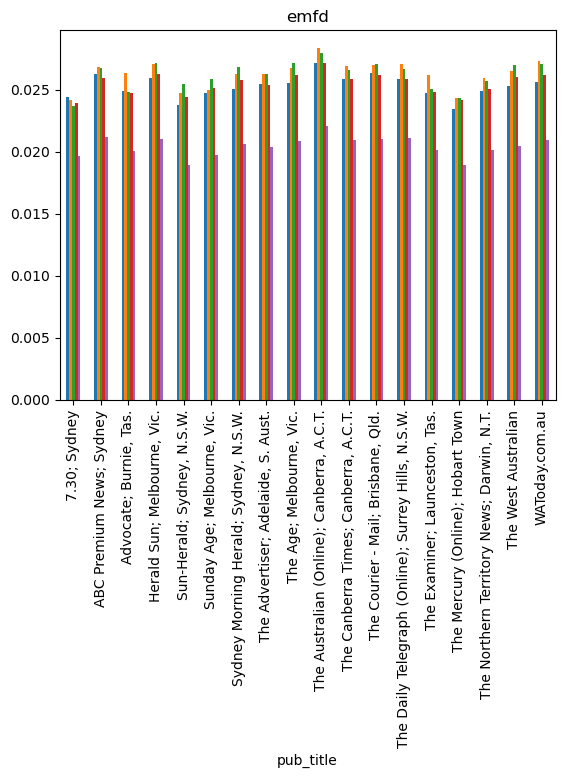

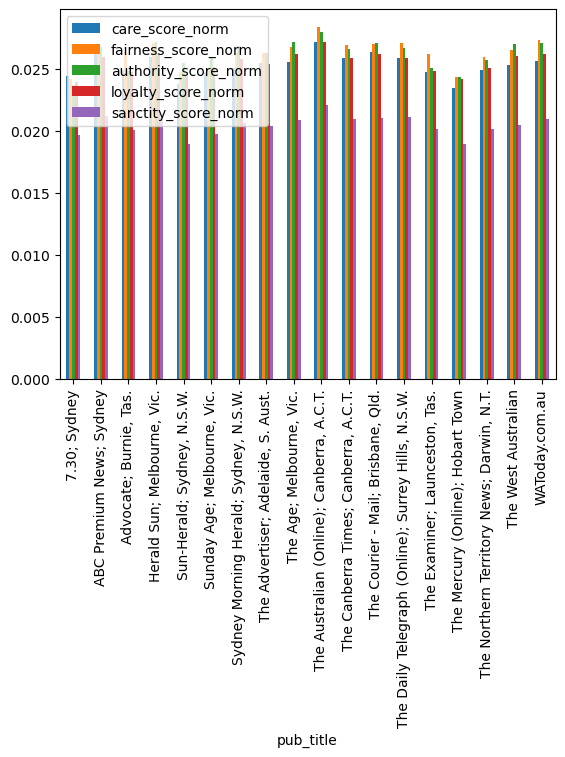

In [15]:
mfd_vers = ['mfd', 'mfd2', 'emfd']

for i in range(len(df_list)):
    mfd_ver = mfd_vers[i]
    df_target = df_list[i]
    if i == 0:
        for pub_title in list(set(df_target['pub_title'])):
            print(pub_title)
    
    df_target_score = df_target[['pub_title', 'care_score_norm', 'fairness_score_norm', 'authority_score_norm', 'loyalty_score_norm', 'sanctity_score_norm']].copy()
    df_target_score.groupby('pub_title').mean().plot.bar(legend=False, title=f"{mfd_ver}")
    df_target_score.groupby('pub_title').mean().plot.bar()

#### Time series

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

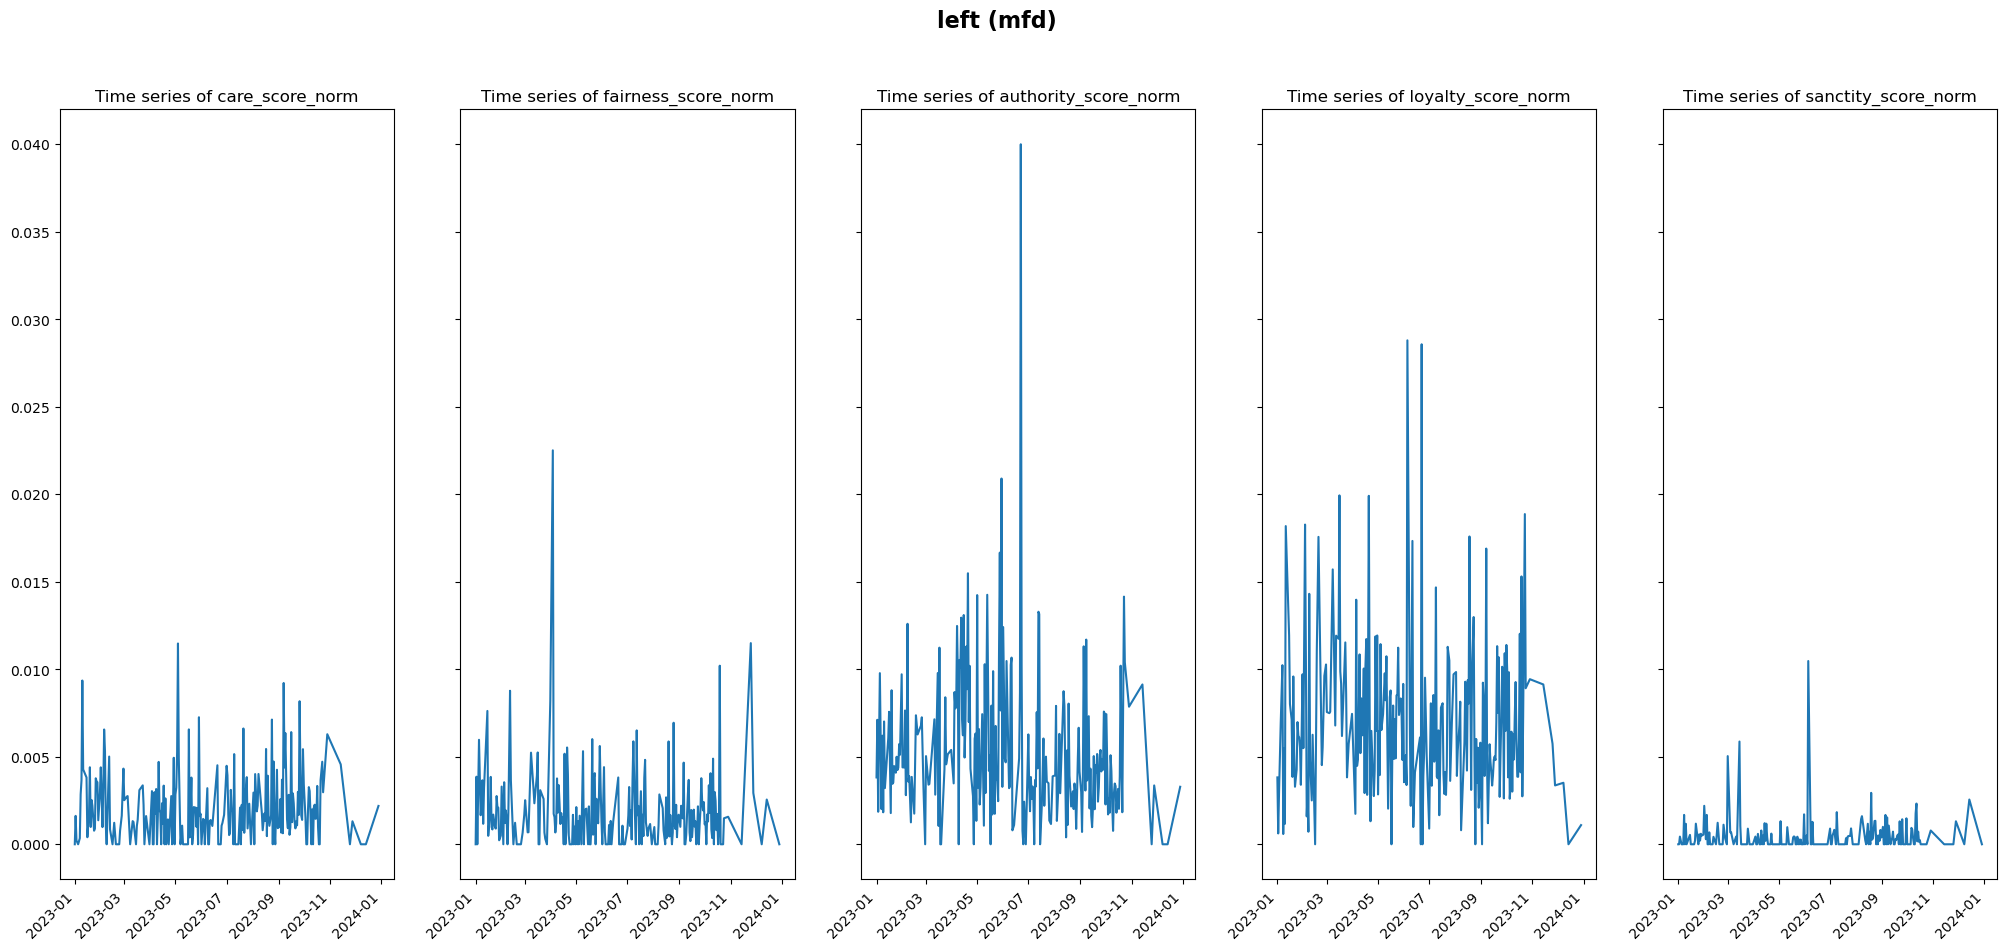

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

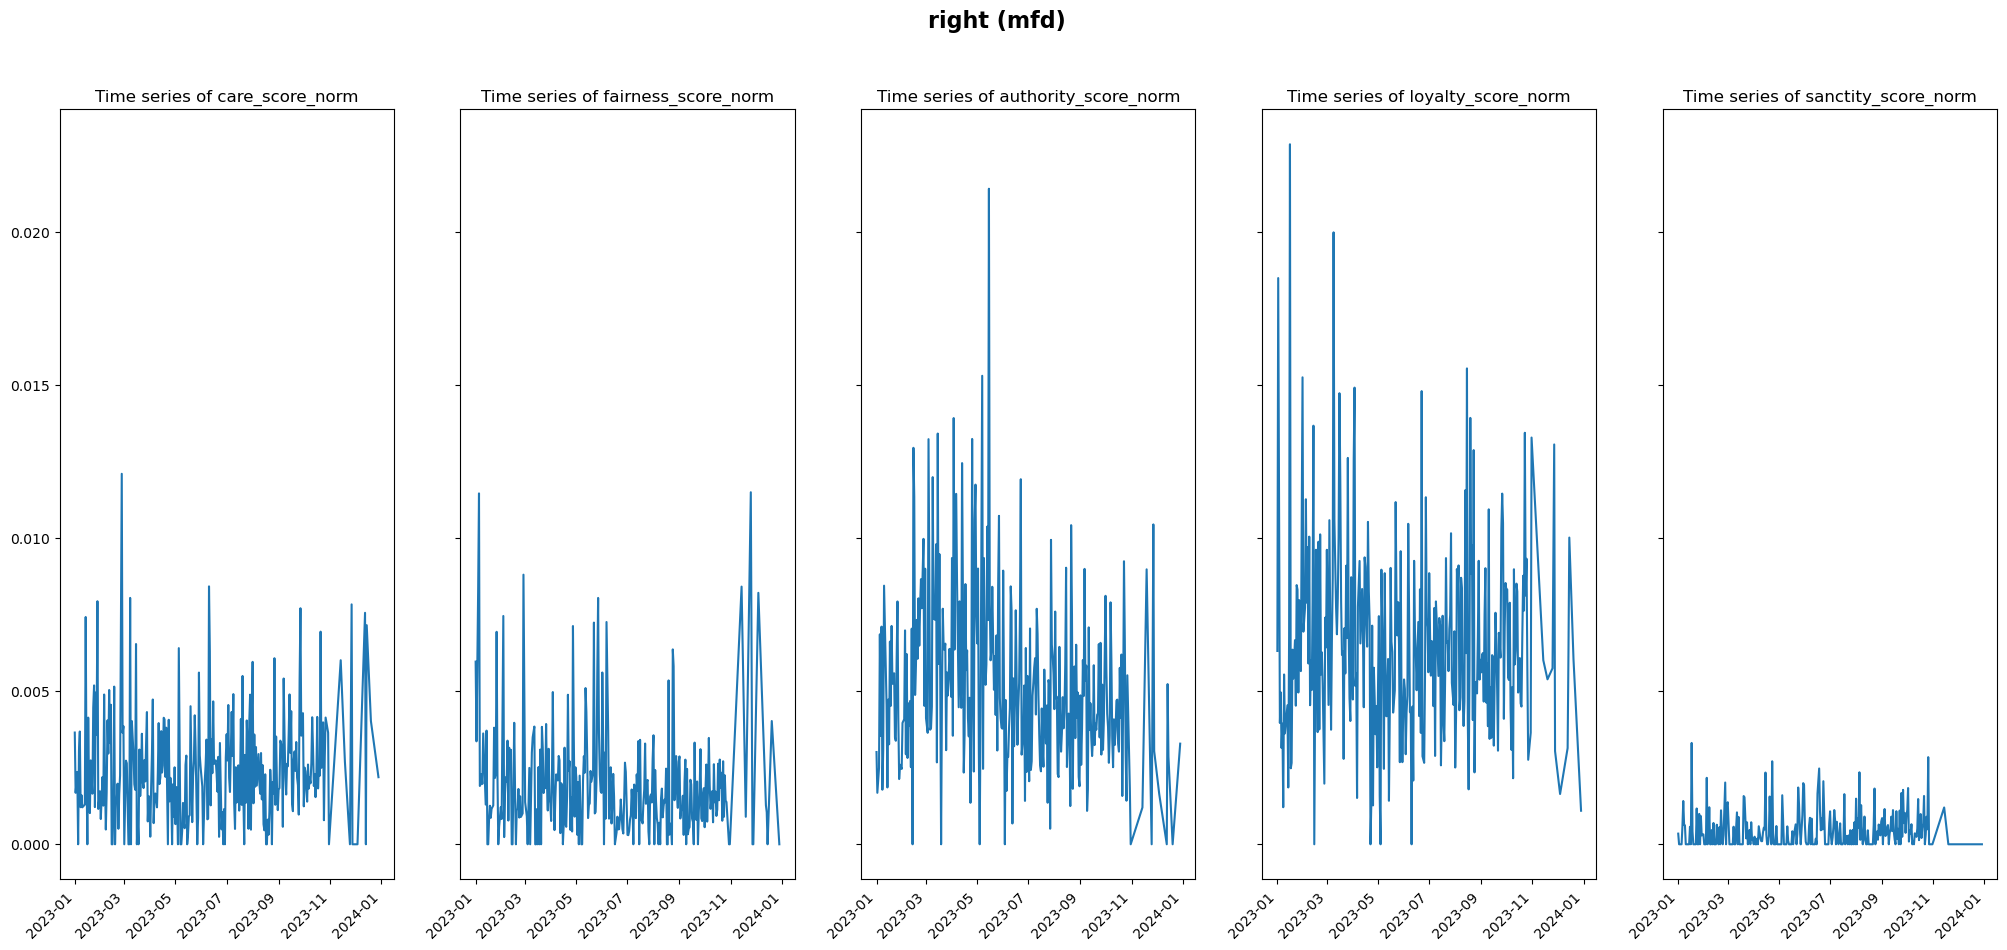

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

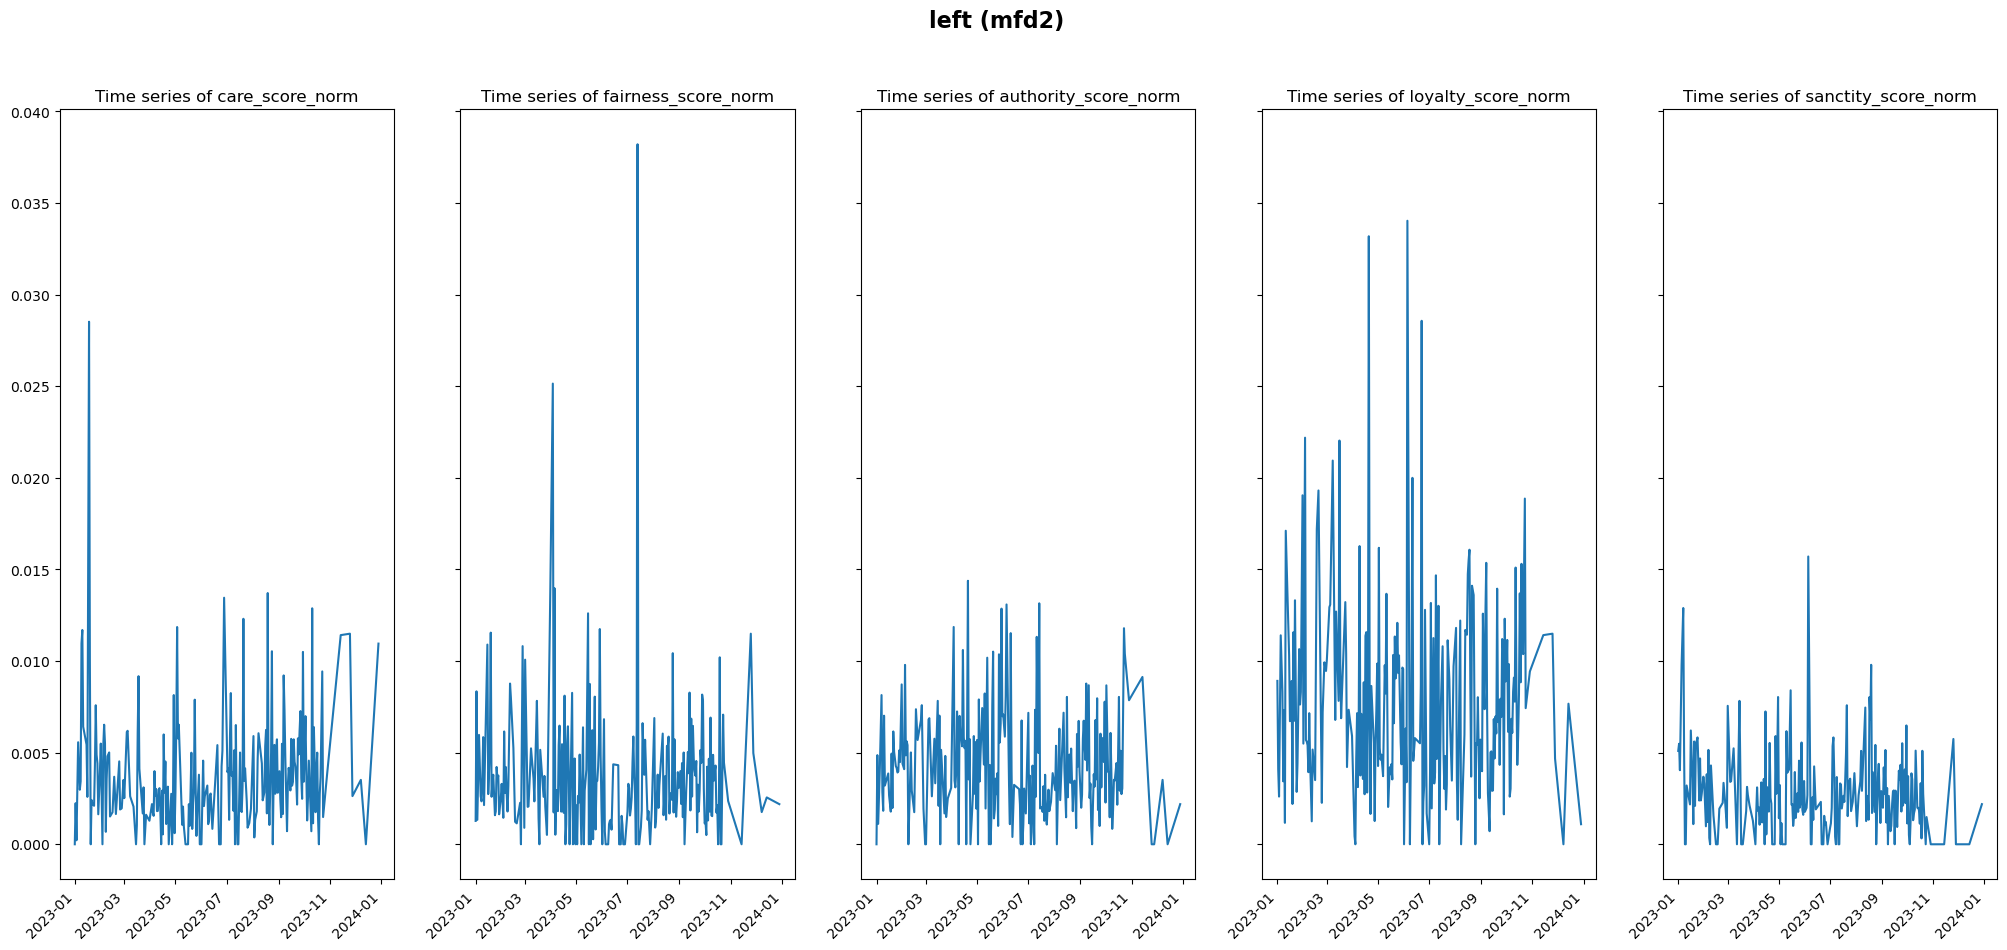

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

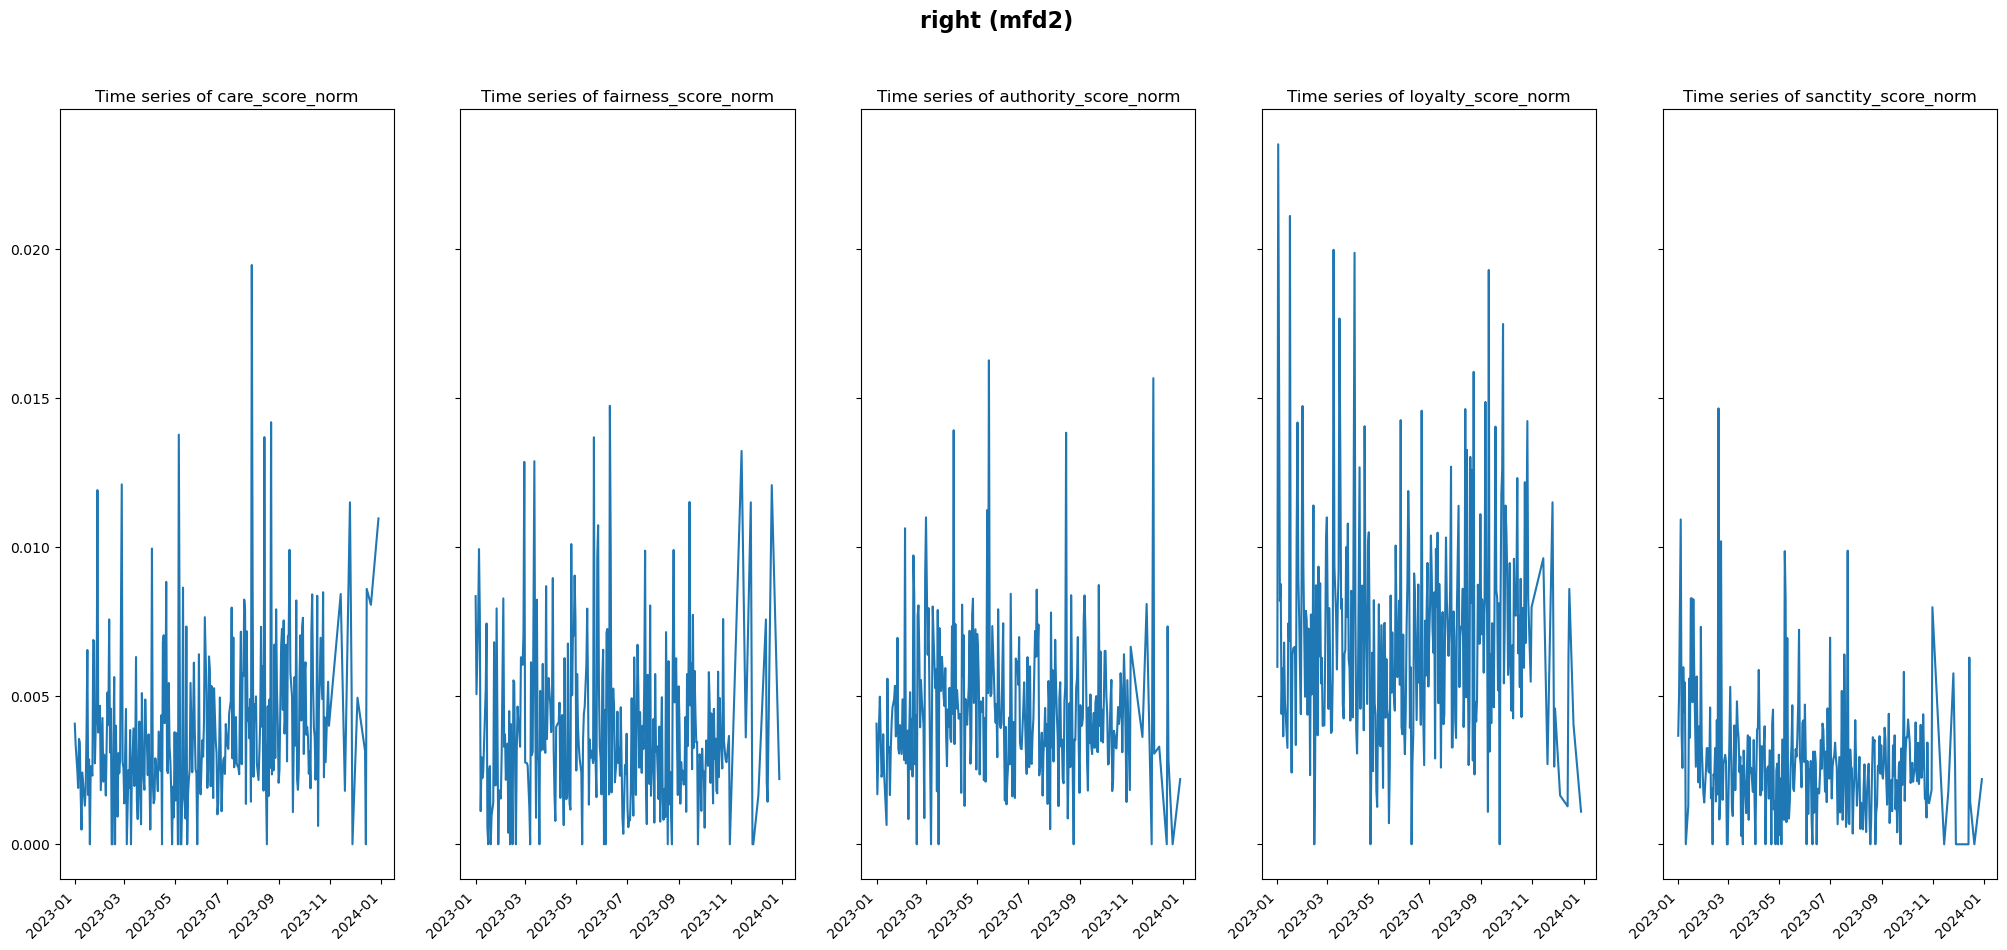

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

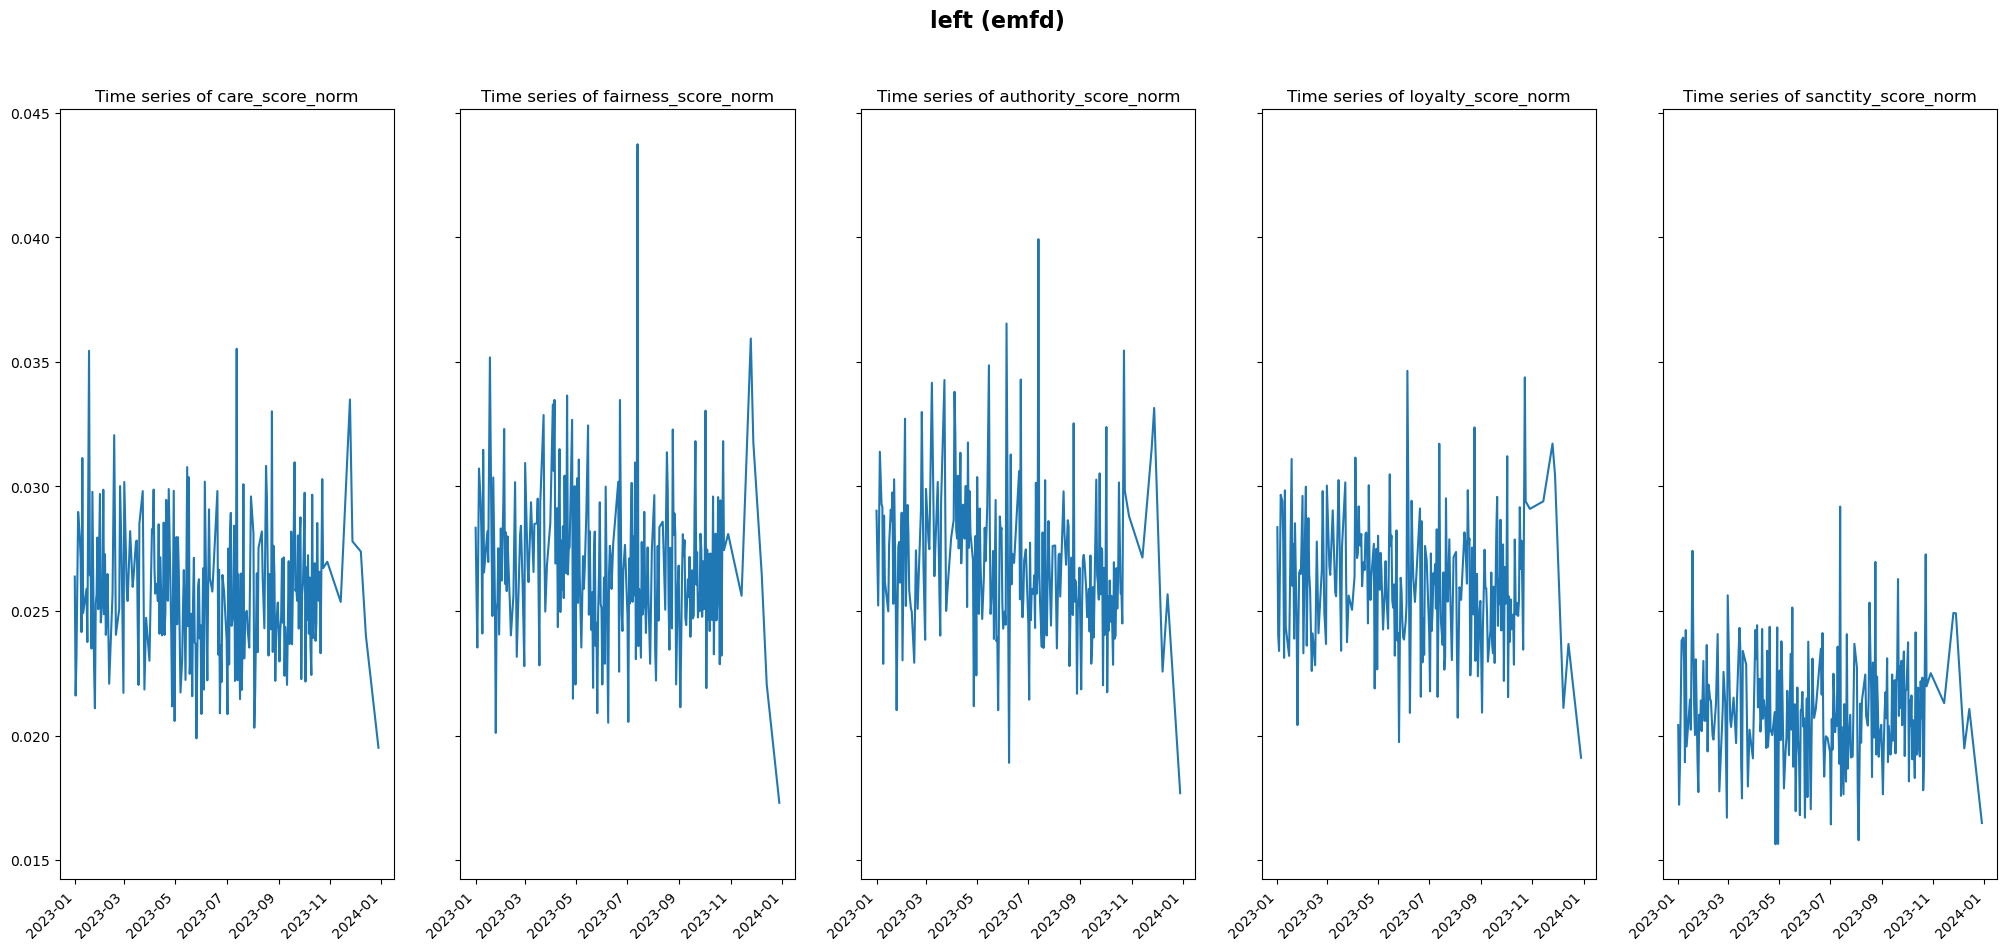

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/1796659318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

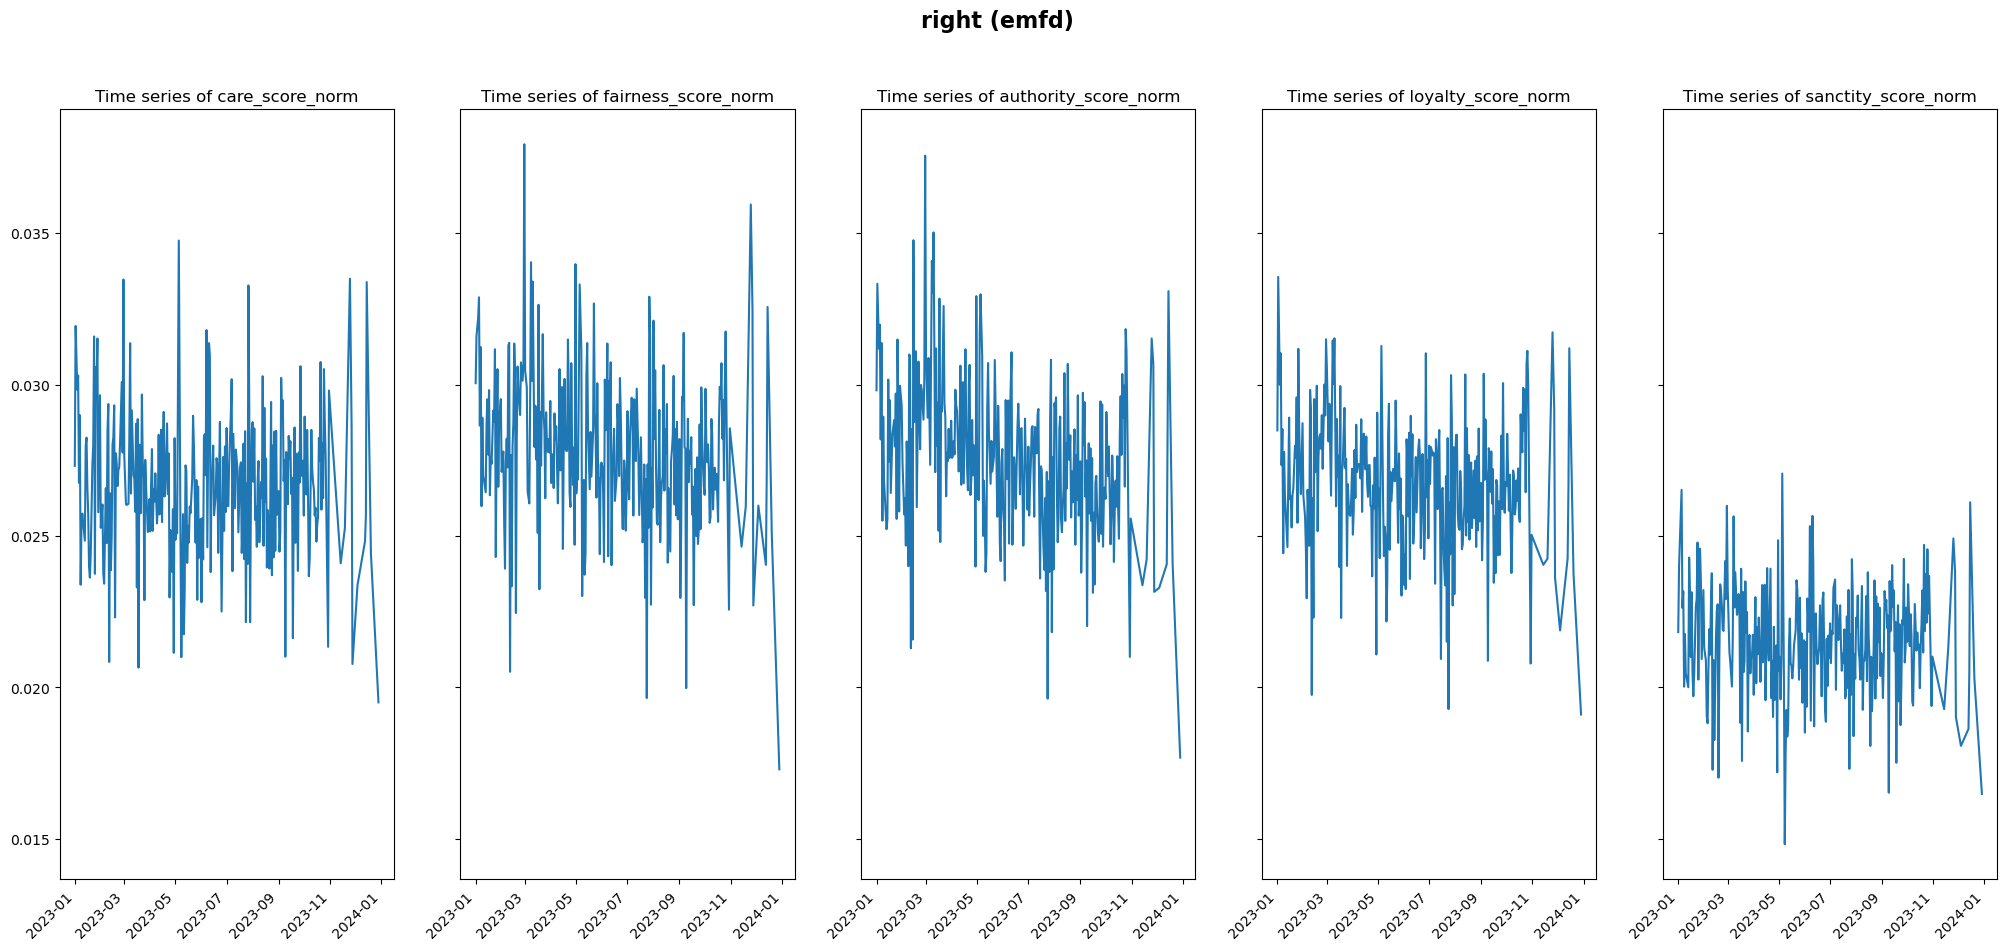

In [16]:
stances = ['left', 'right']
mfd_vers = ['mfd', 'mfd2', 'emfd']
for k in range(len(df_list)):
    mfd_ver = mfd_vers[k]
    df_target = df_list[k]
    df_stance_ts = df_target[['care_score_norm', 'fairness_score_norm', 'authority_score_norm', 'loyalty_score_norm', 'sanctity_score_norm', 'edit_stance', 'date']].groupby(['edit_stance', 'date']).mean().copy()
    df_stance_ts.reset_index(inplace=True)


    for stance in stances:
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 10), sharey=True)

        foundations = ['care', 'fairness', 'authority', 'loyalty', 'sanctity']
        for i in range(5):
            f = foundations[i]
            axs[i].plot(df_stance_ts[df_stance_ts['edit_stance']==stance]["date"], 
                df_stance_ts[df_stance_ts['edit_stance']==stance][f'{f}_score_norm'], 
            )

            axs[i].set_title(f'Time series of {f}_score_norm')
            
            # Config grids
            # axs[i].grid(linestyle='--', linewidth=0.5)

        for ax in axs:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
        fig.suptitle(f'{stance} ({mfd_ver})', fontsize=16, fontweight='bold')

        plt.show()

### State aggregation

##### Mean aggregated by state

VIC
WA
SA
NT
national
ACT
QLD
TAS
NSW


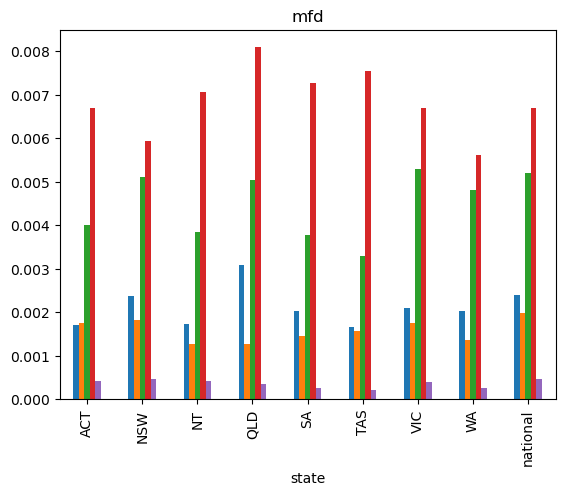

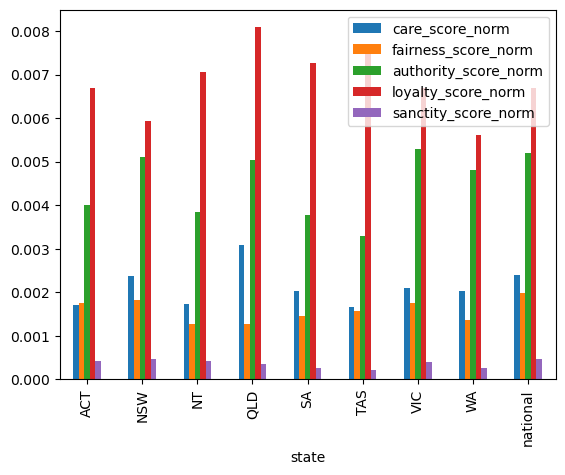

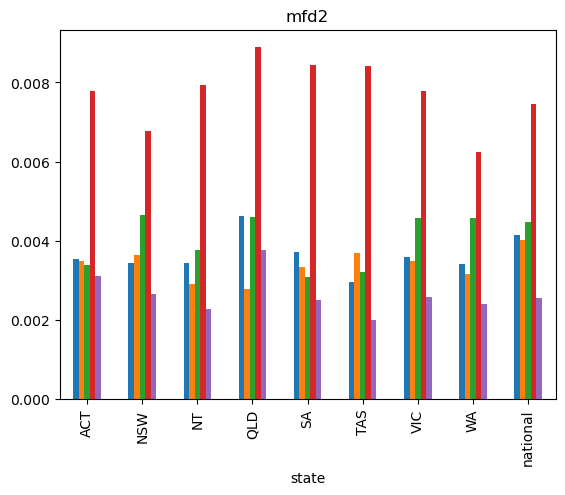

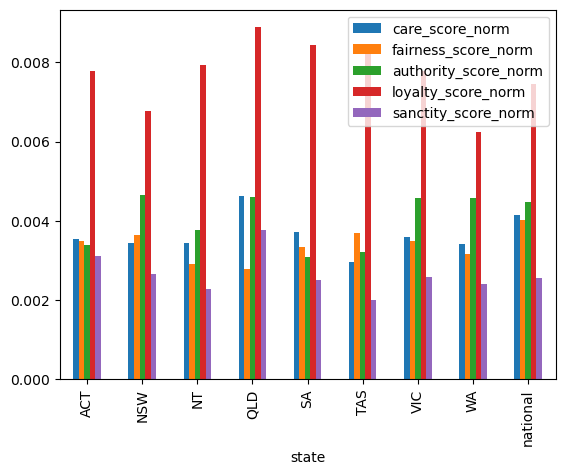

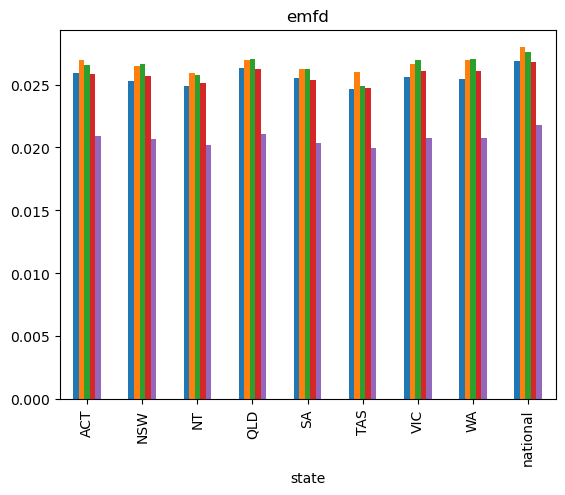

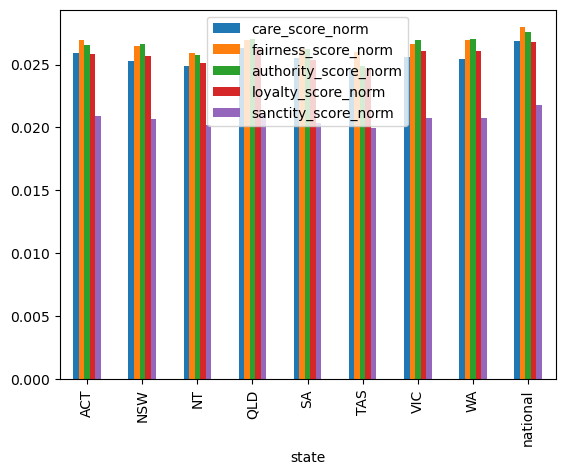

In [17]:
mfd_vers = ['mfd', 'mfd2', 'emfd']

for i in range(len(df_list)):
    mfd_ver = mfd_vers[i]
    df_target = df_list[i]
    if i == 0:
        for state in list(set(df_target['state'])):
            print(state)
    
    df_target_score = df_target[['state', 'care_score_norm', 'fairness_score_norm', 'authority_score_norm', 'loyalty_score_norm', 'sanctity_score_norm']].copy()
    df_target_score.groupby('state').mean().plot.bar(legend=False, title=f"{mfd_ver}")
    df_target_score.groupby('state').mean().plot.bar()

##### Time series

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

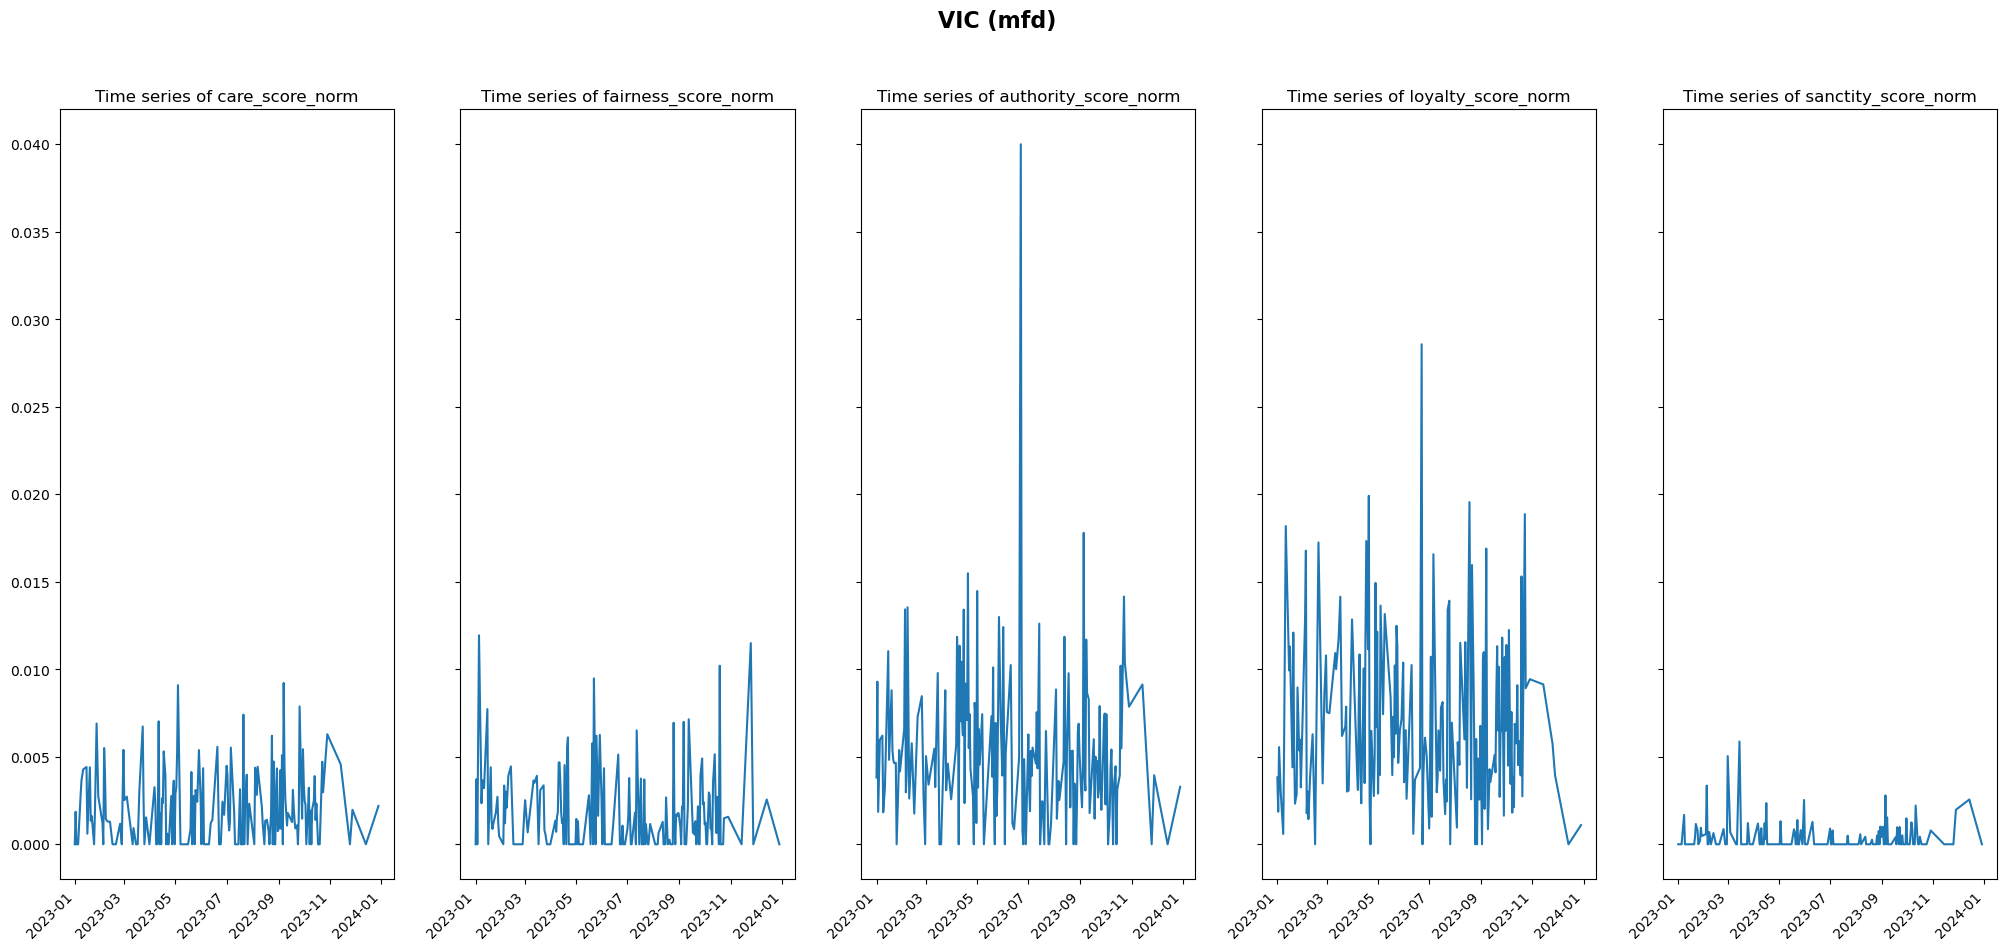

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

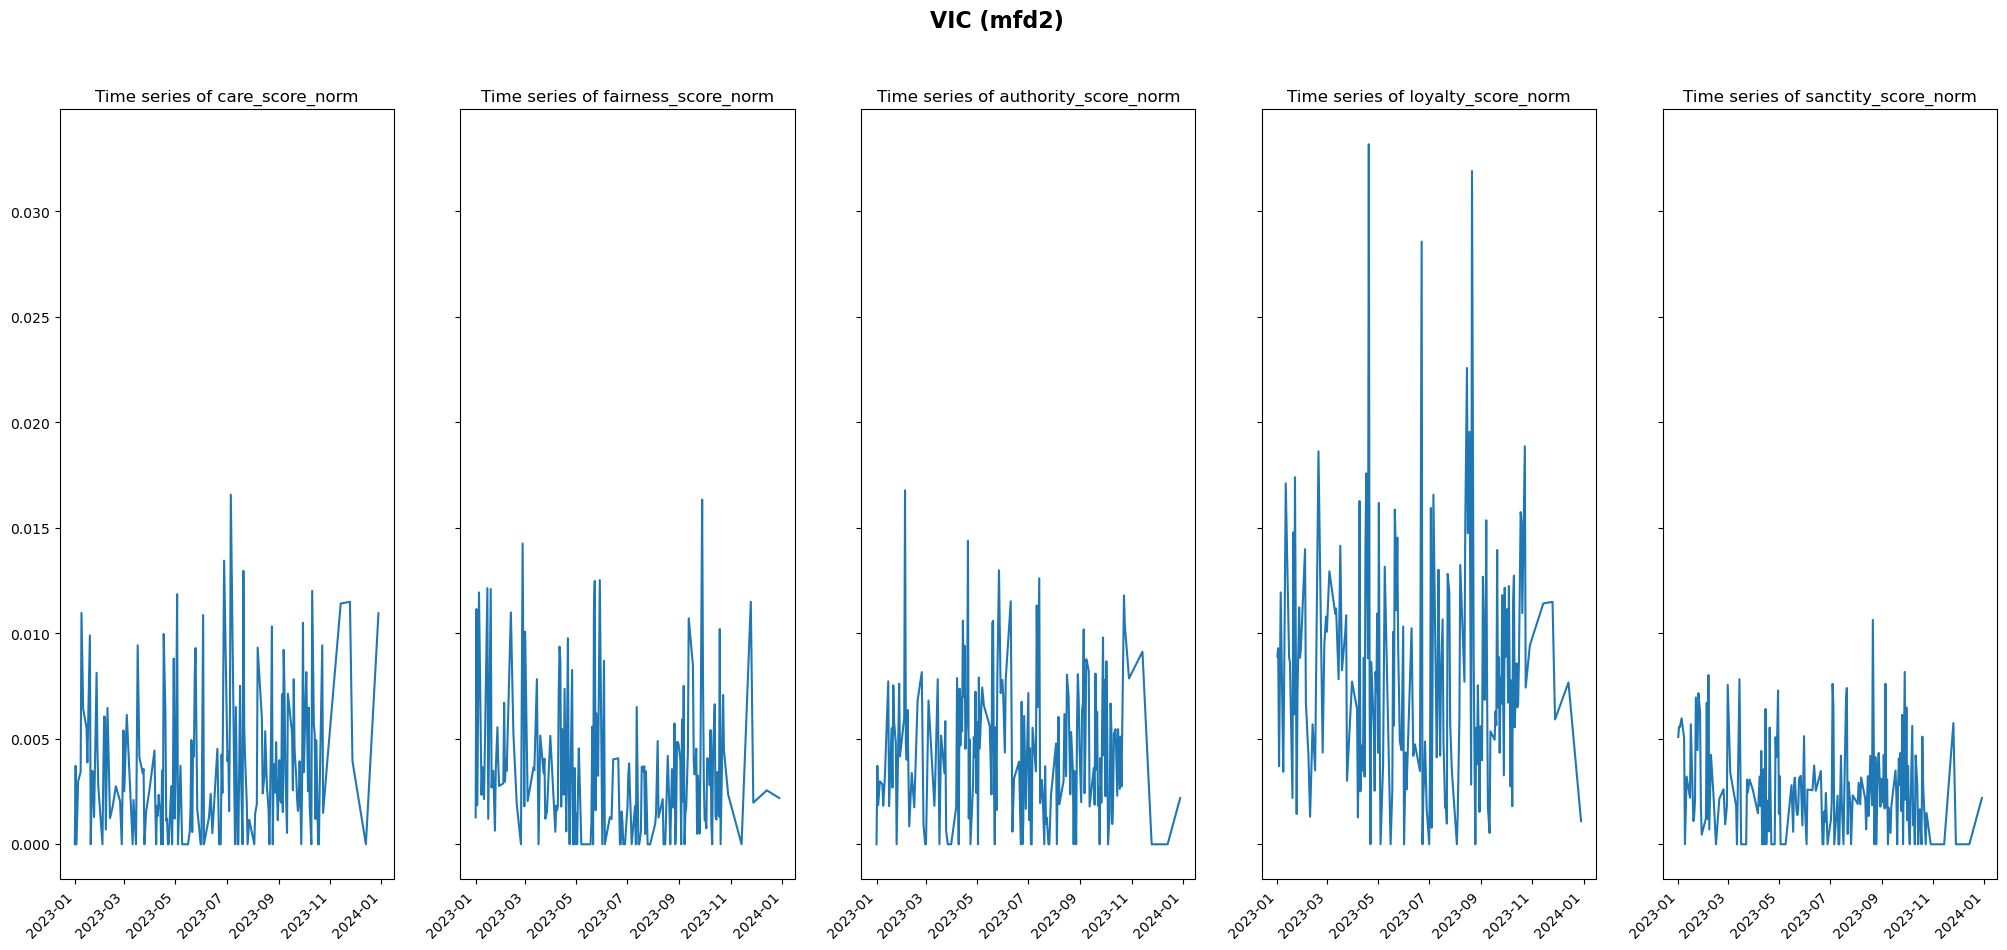

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

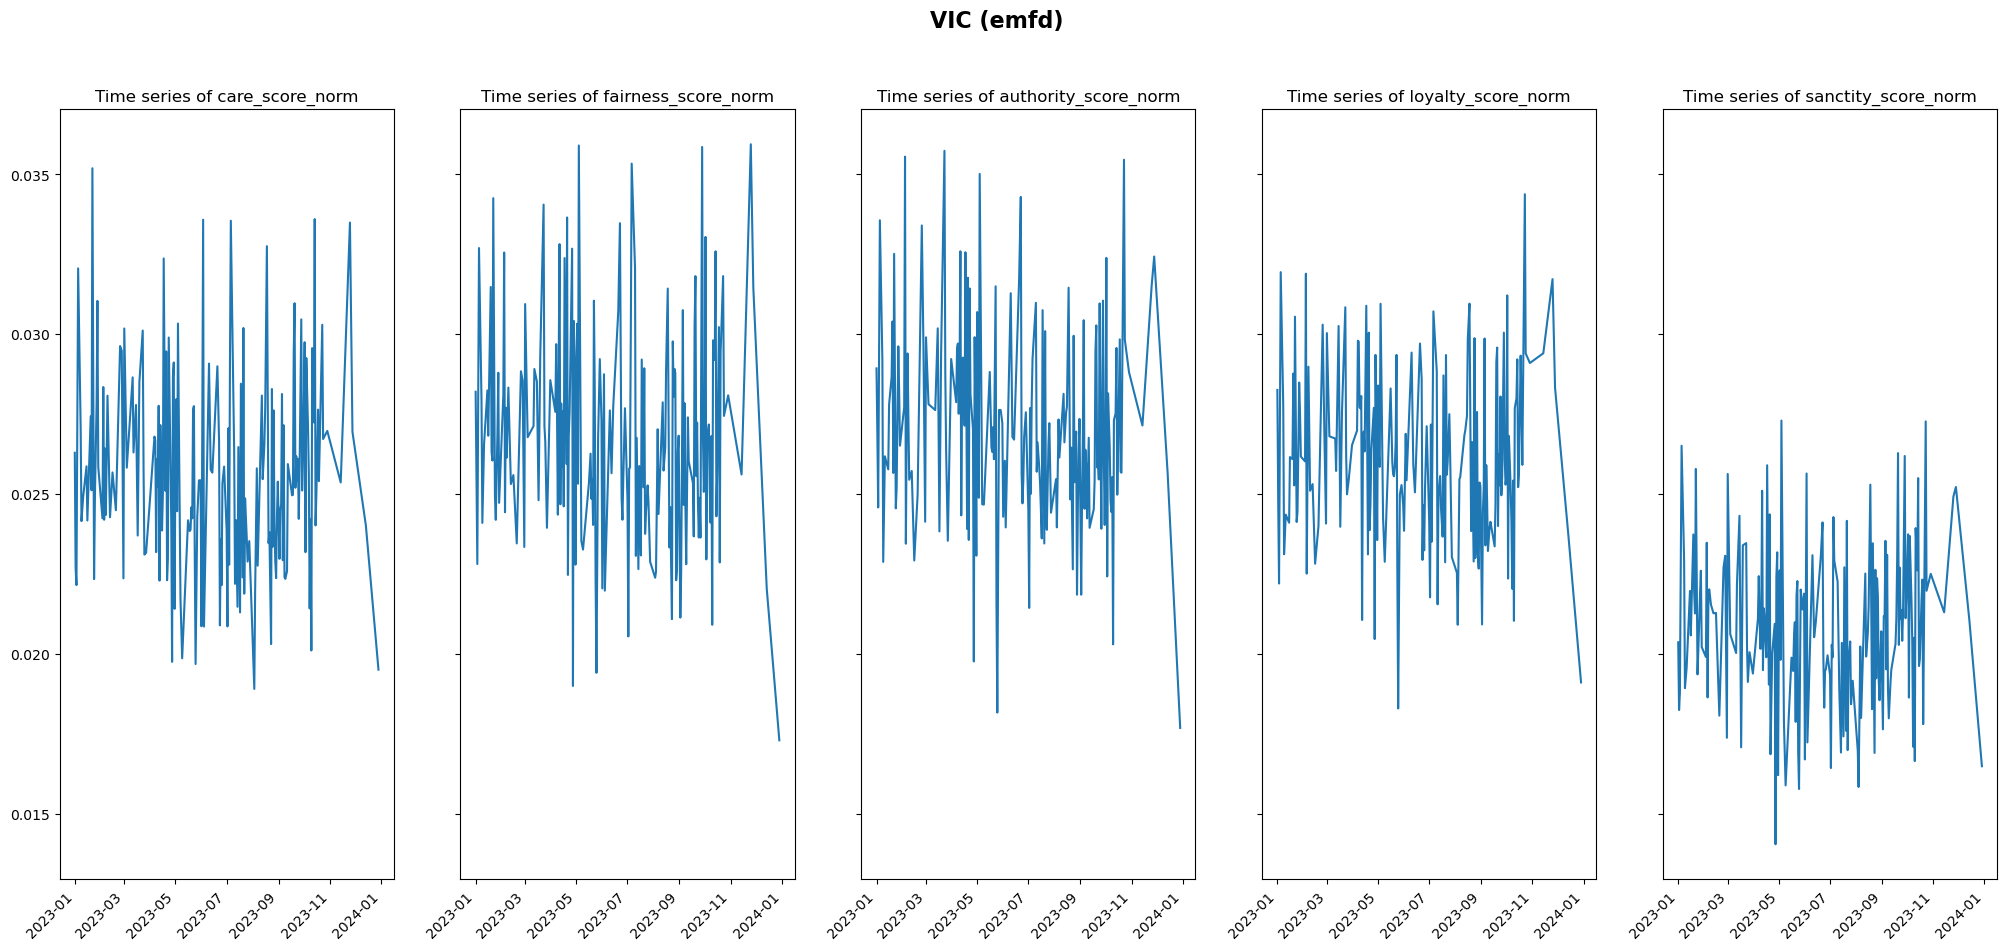

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

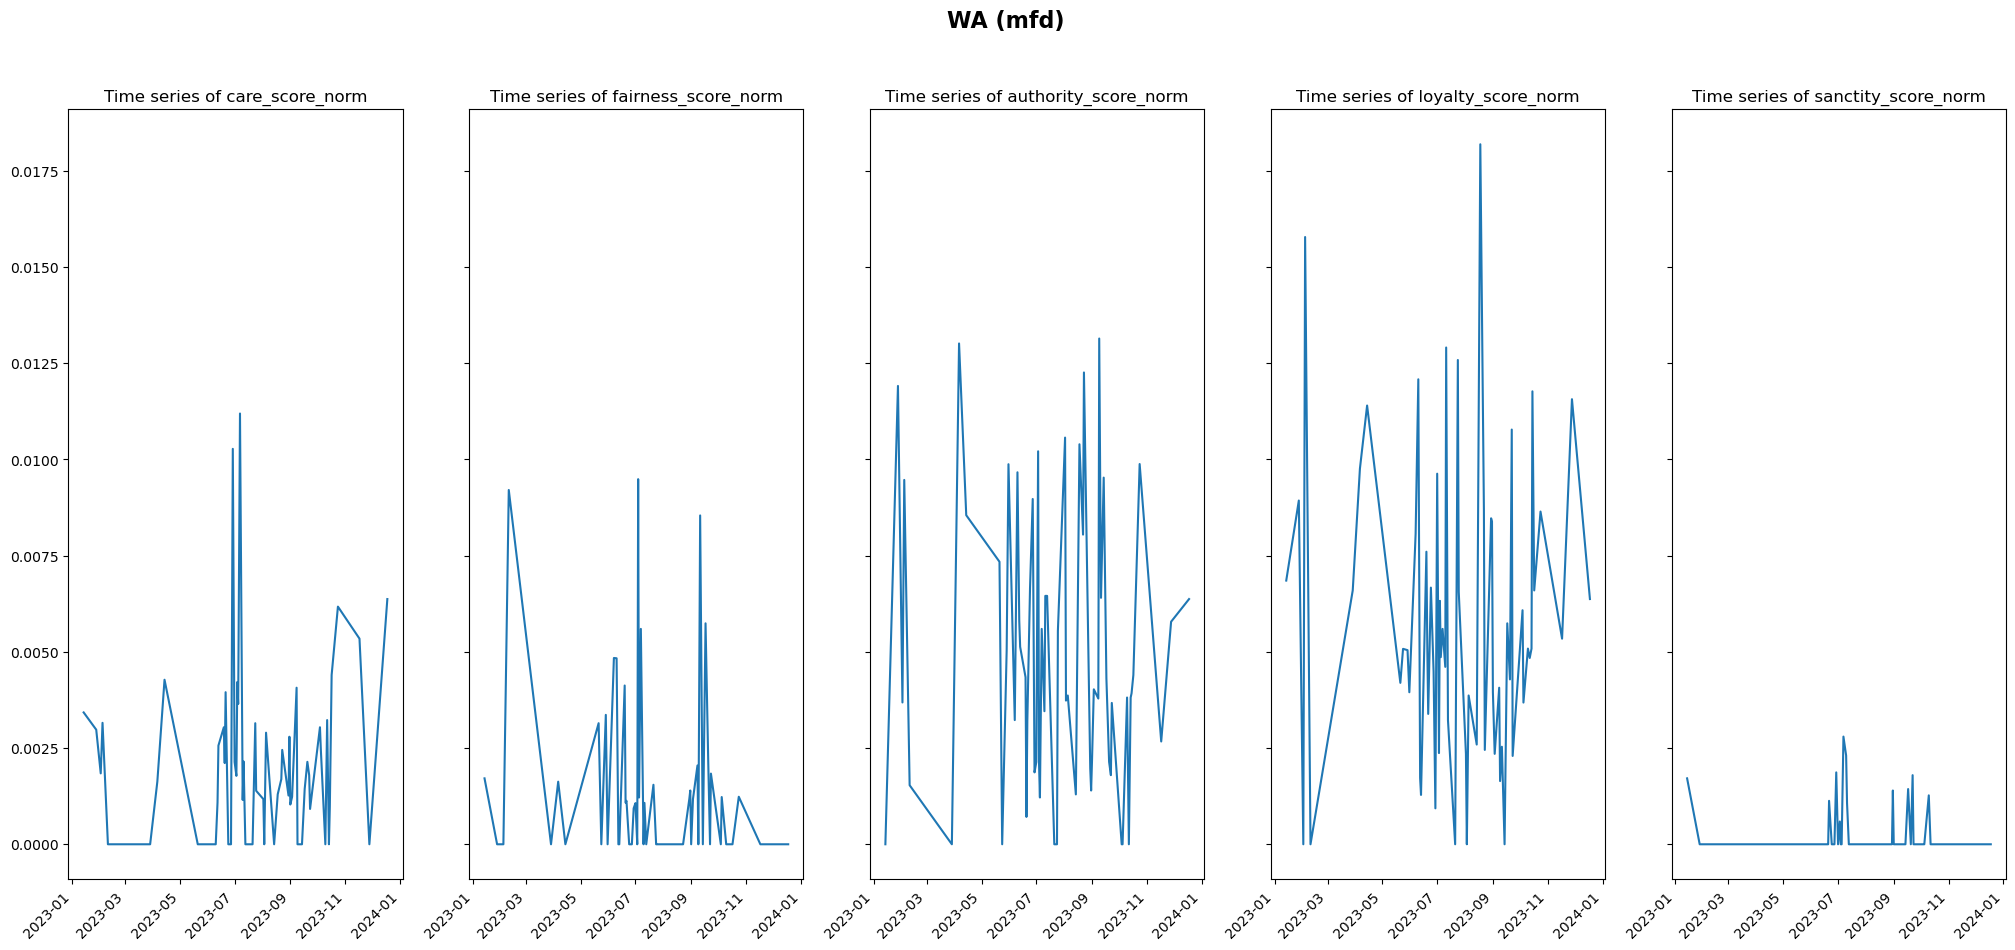

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

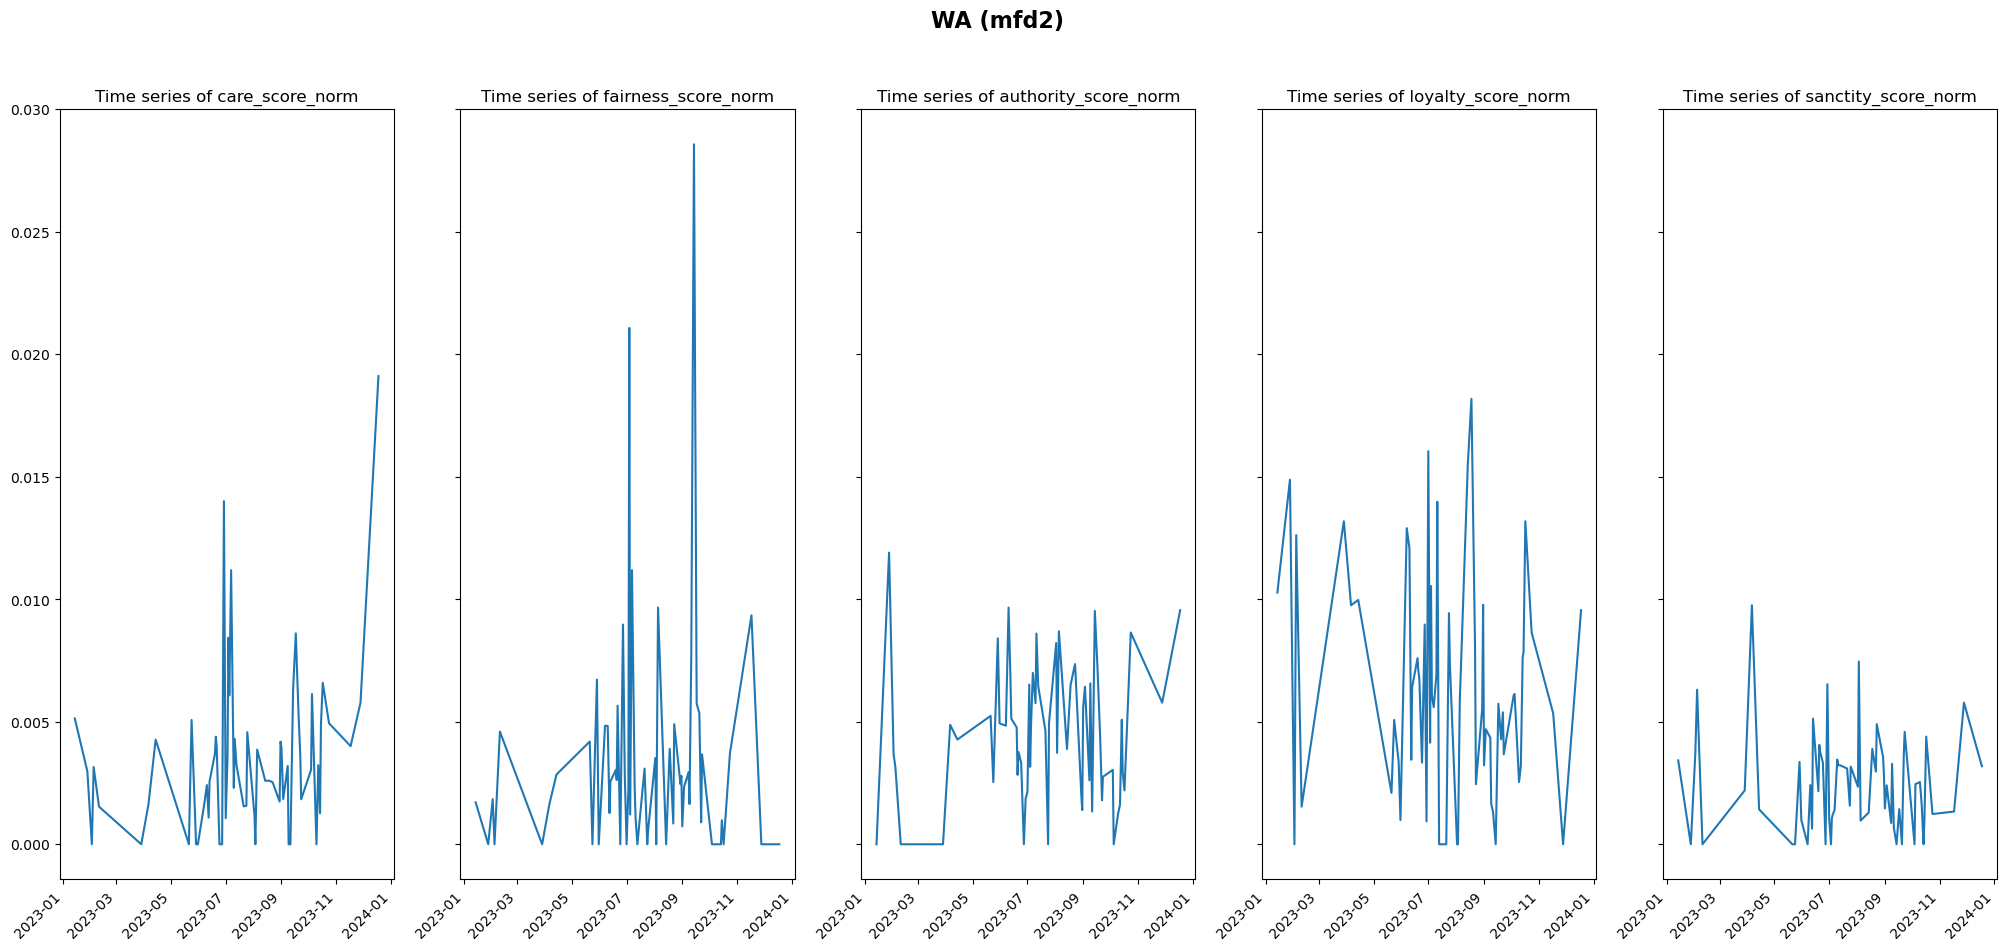

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

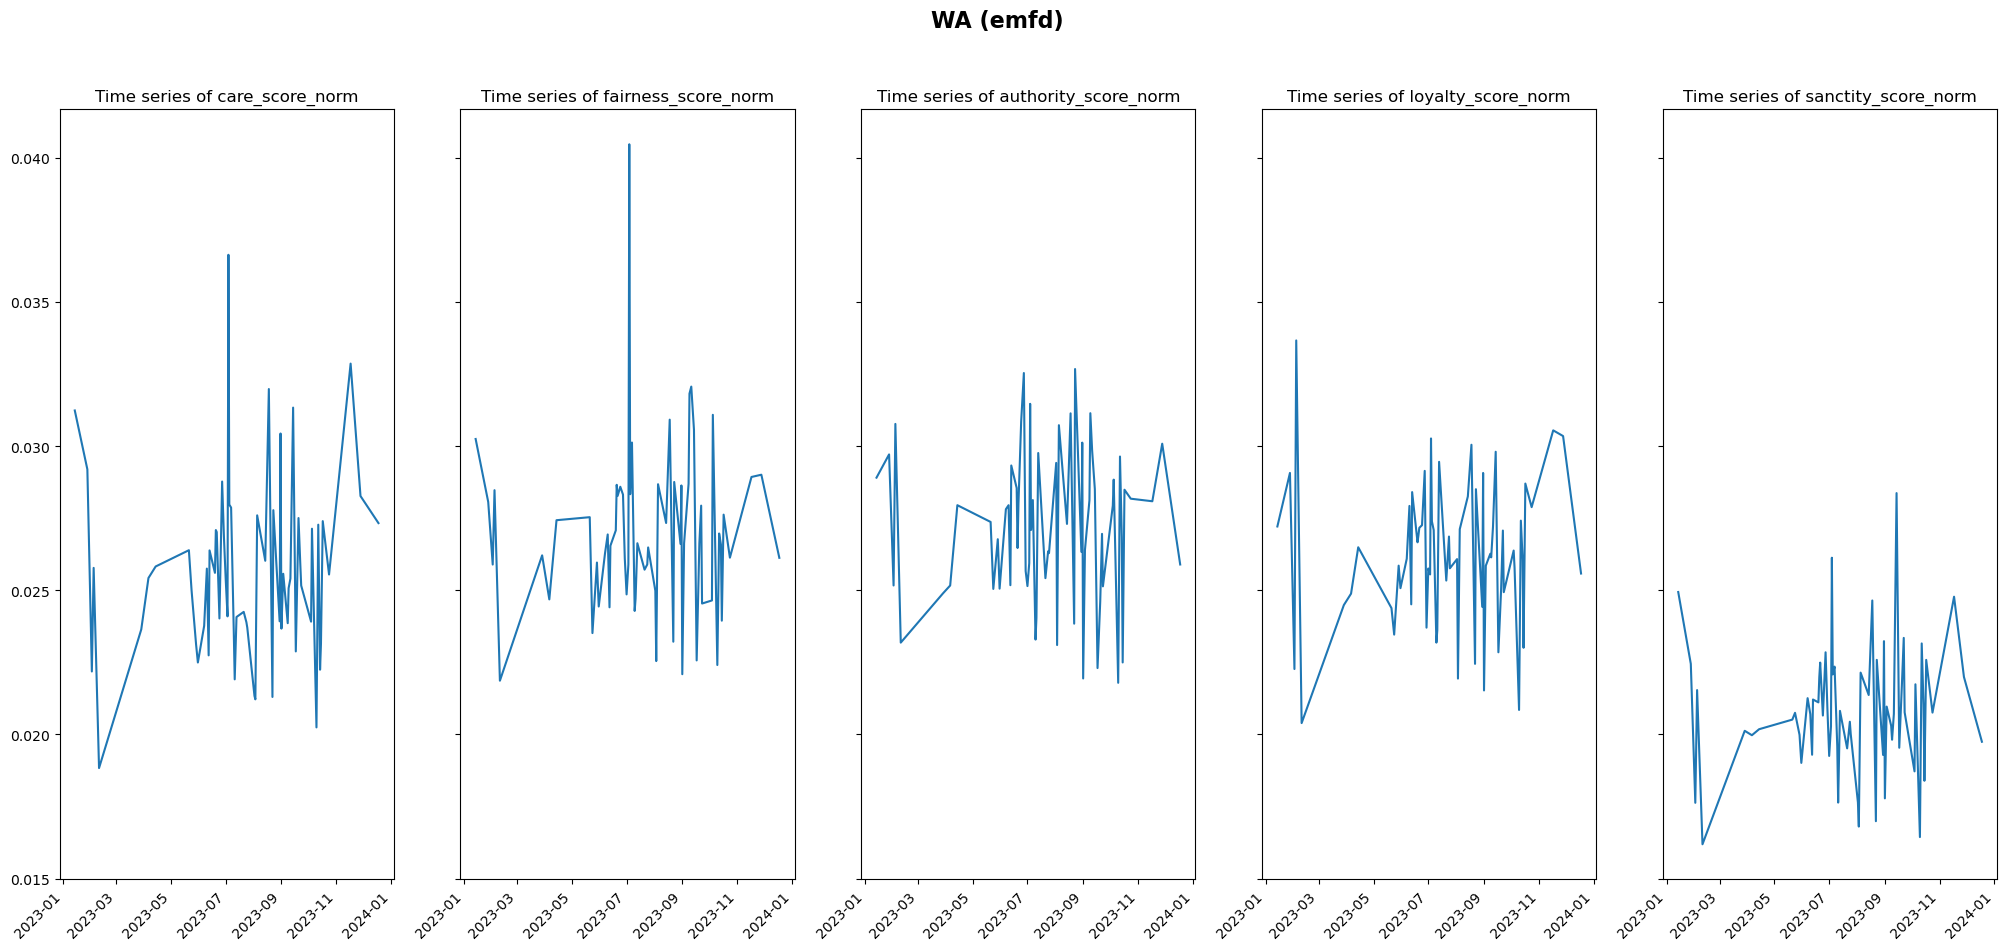

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

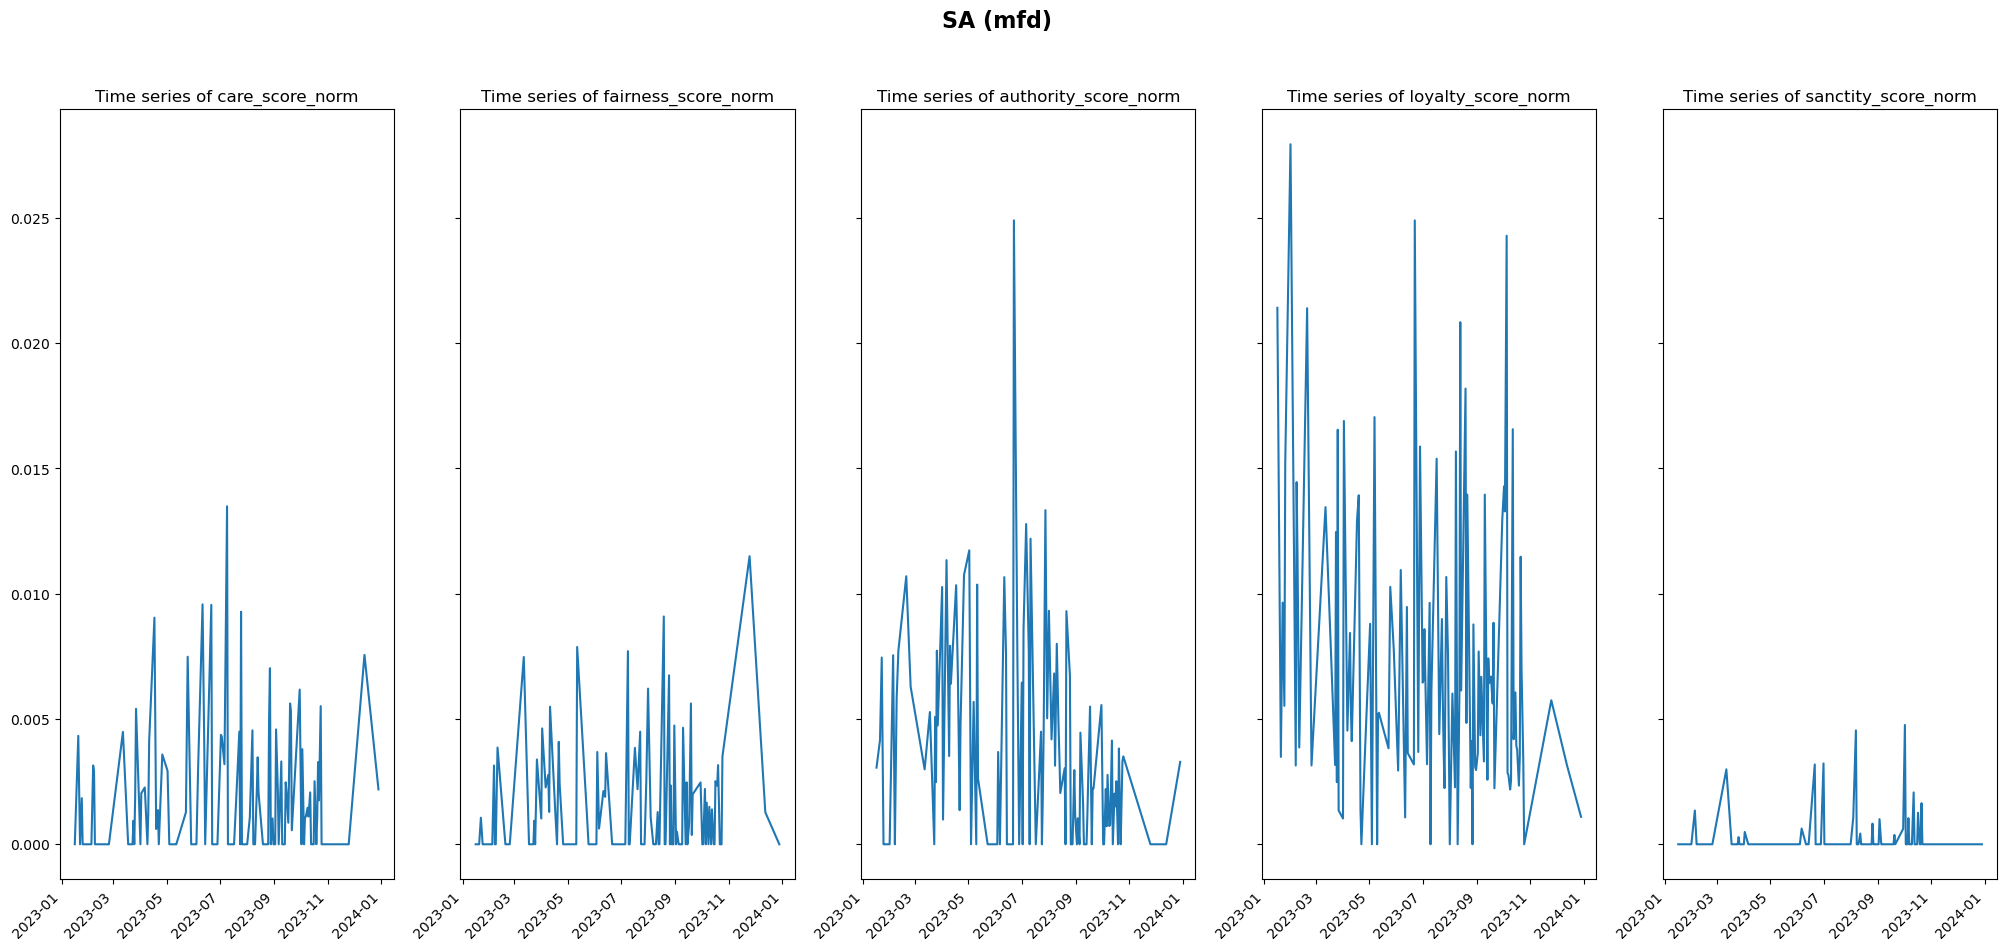

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

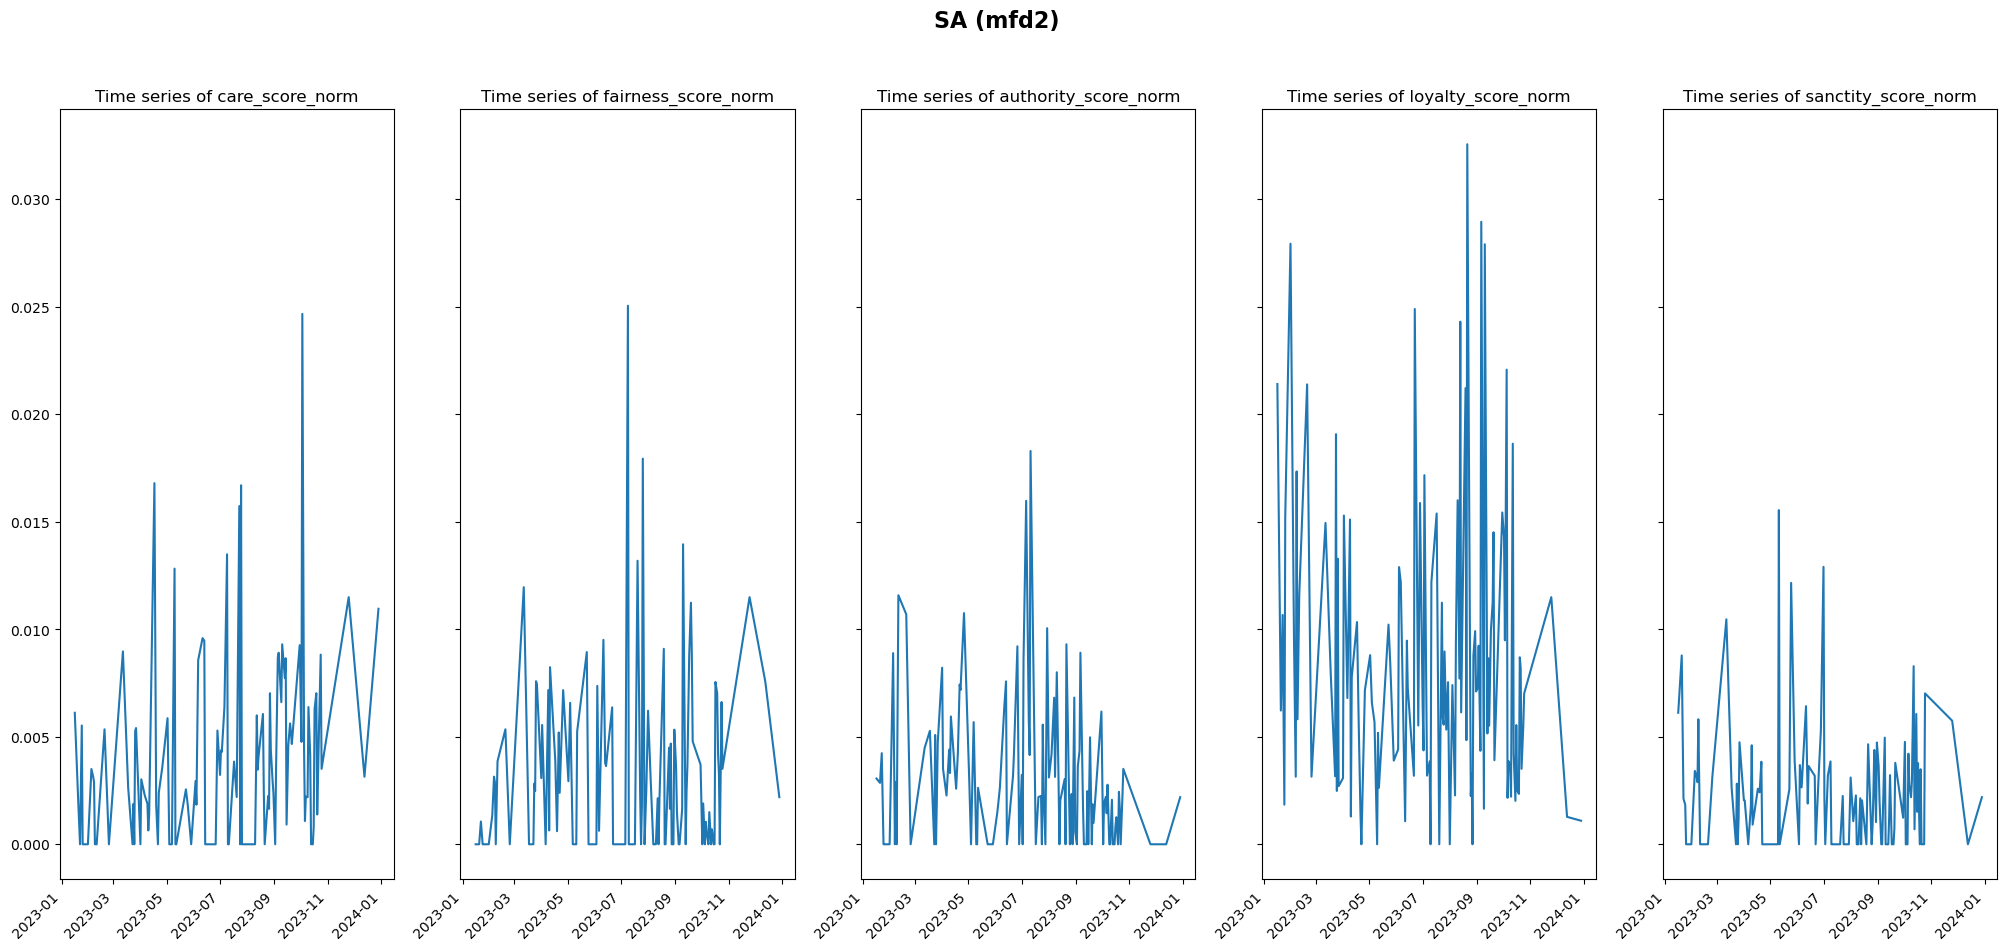

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

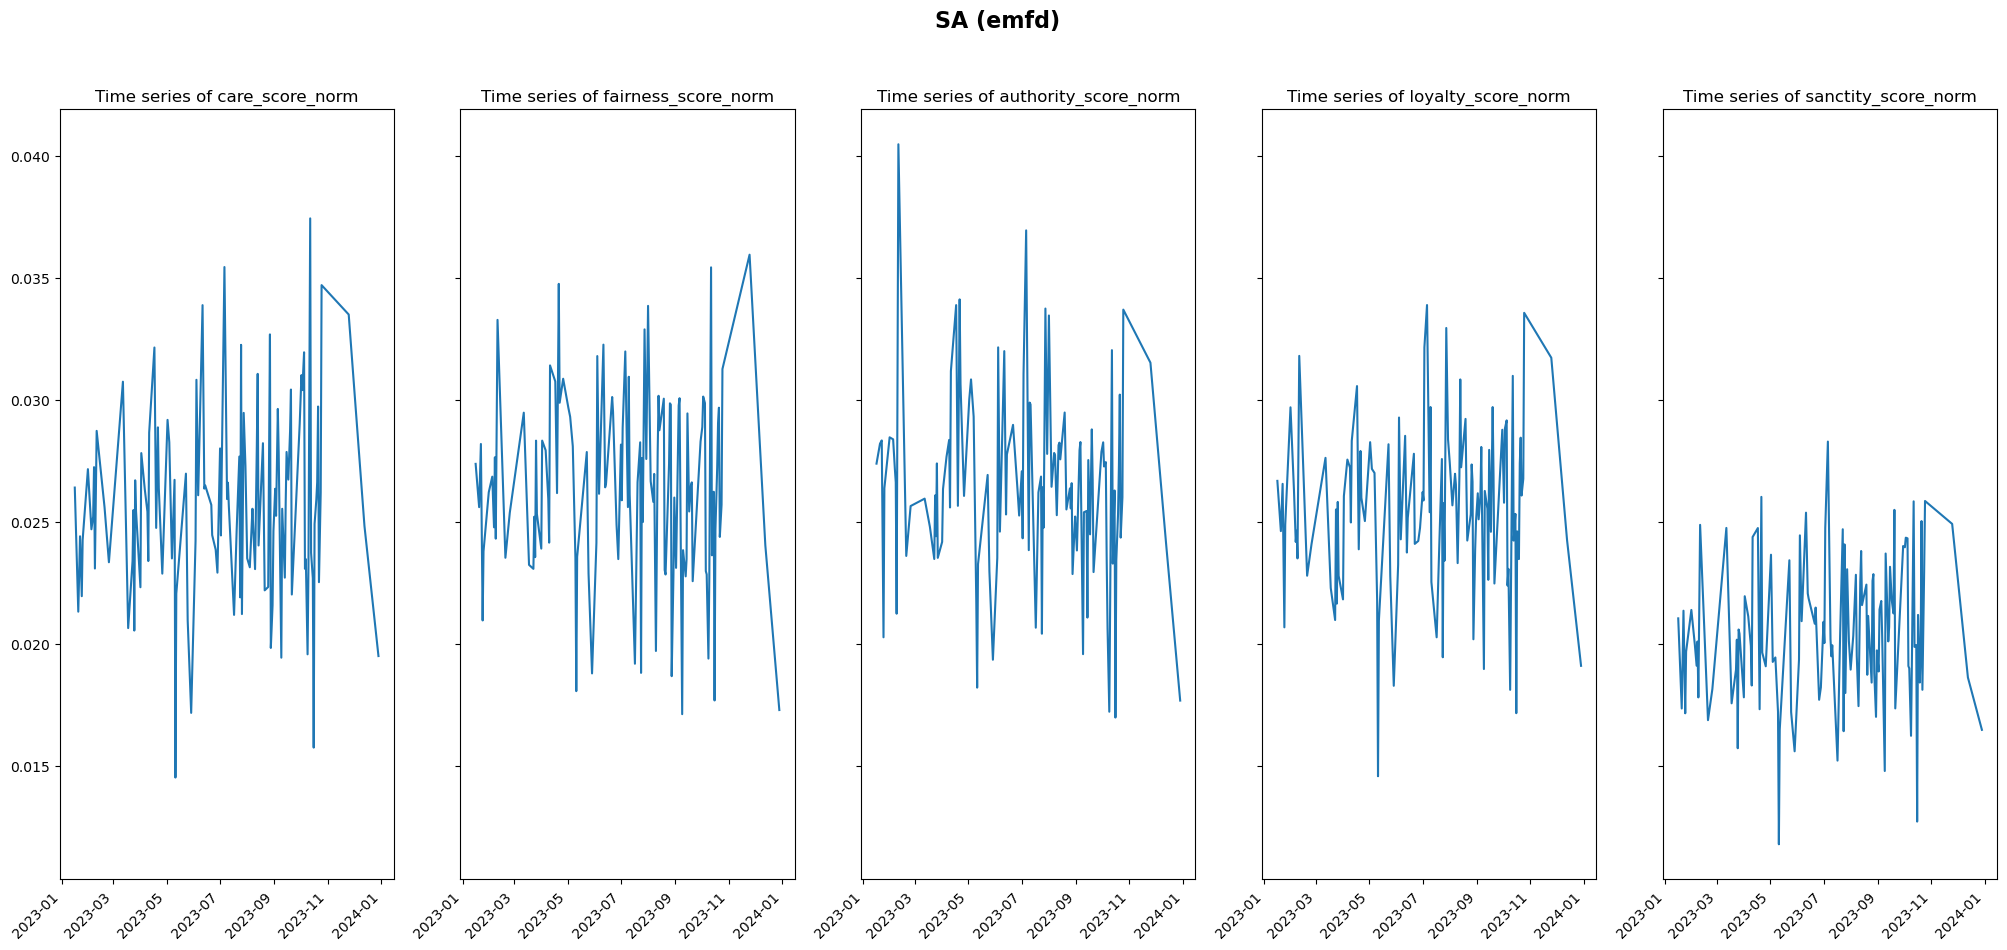

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

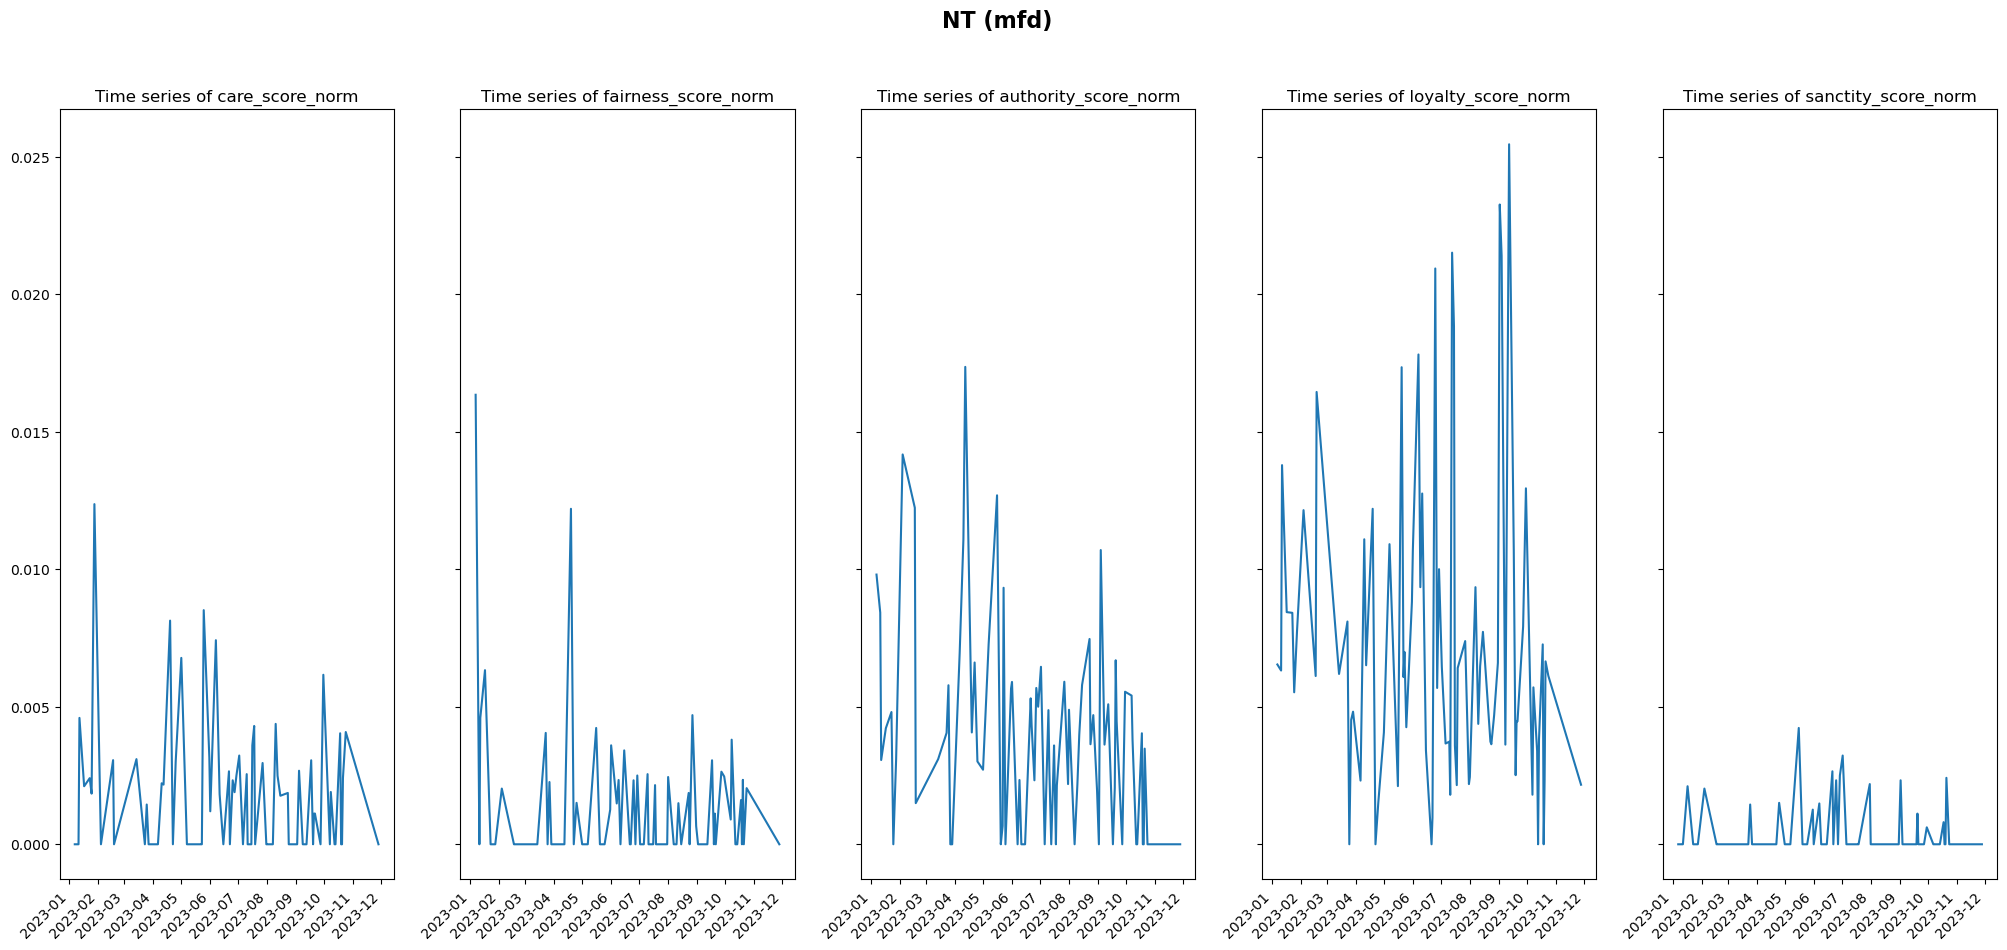

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

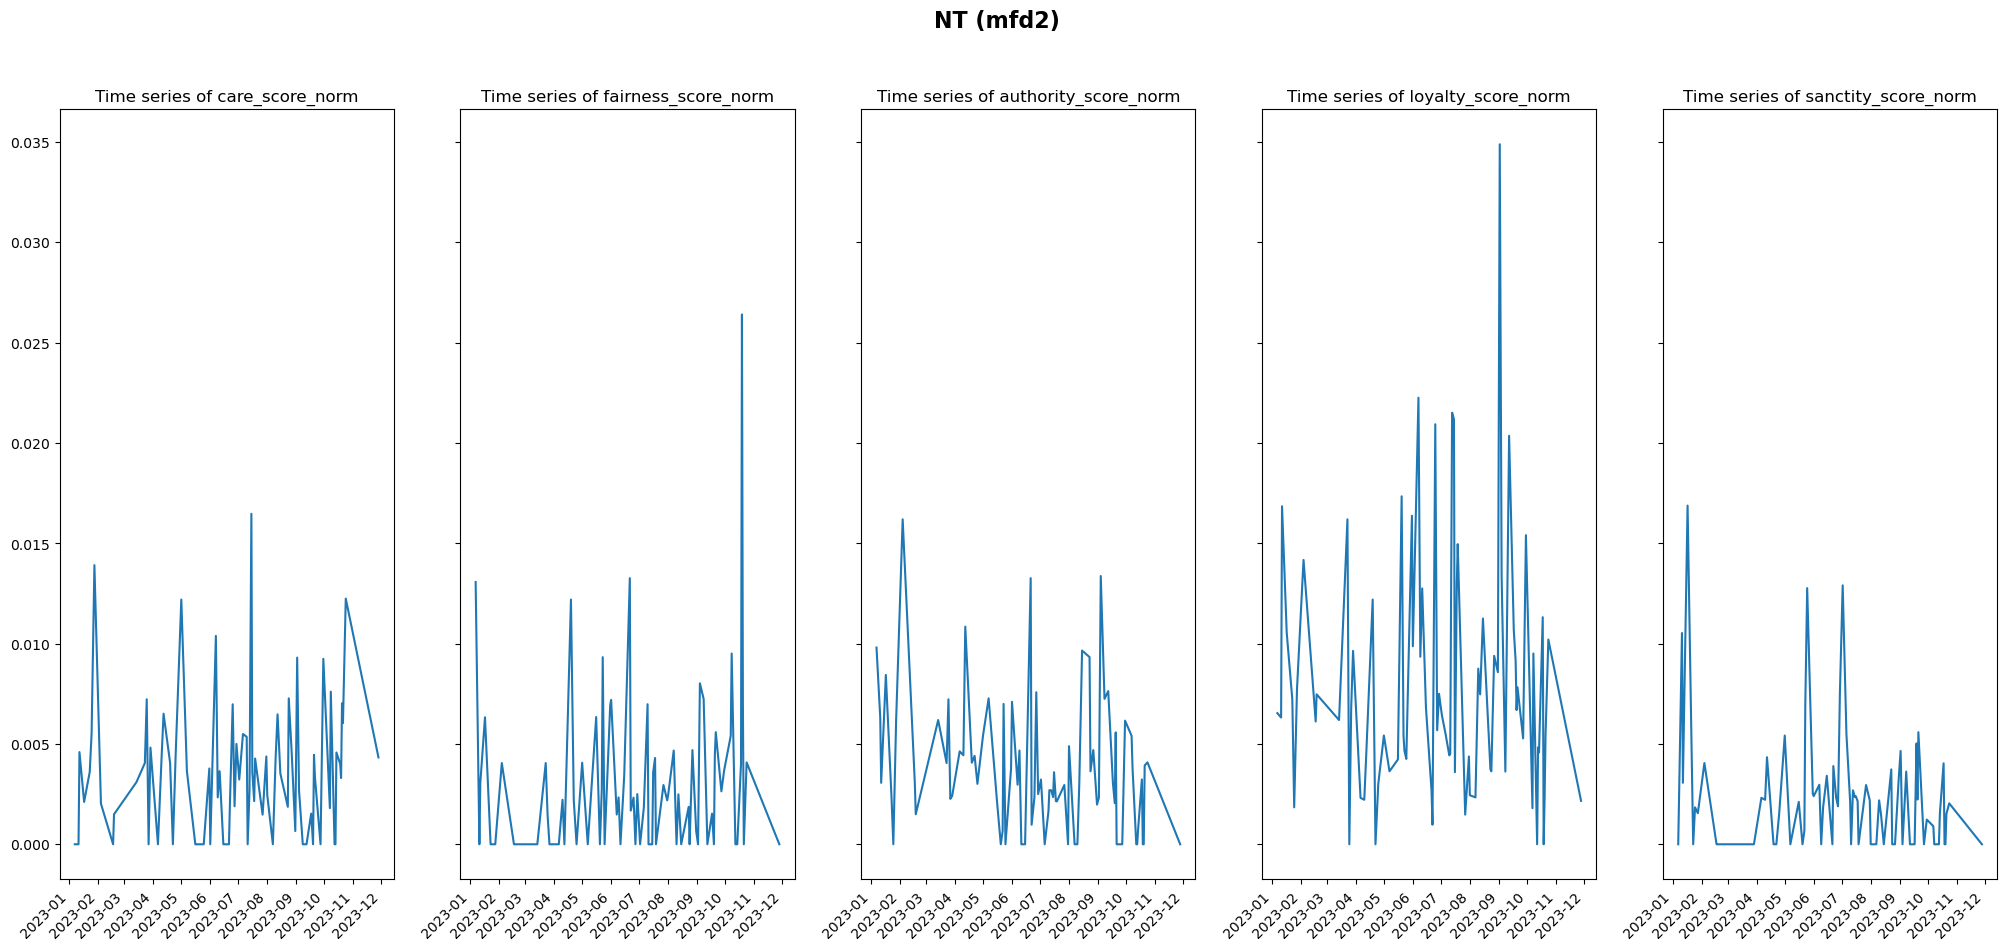

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

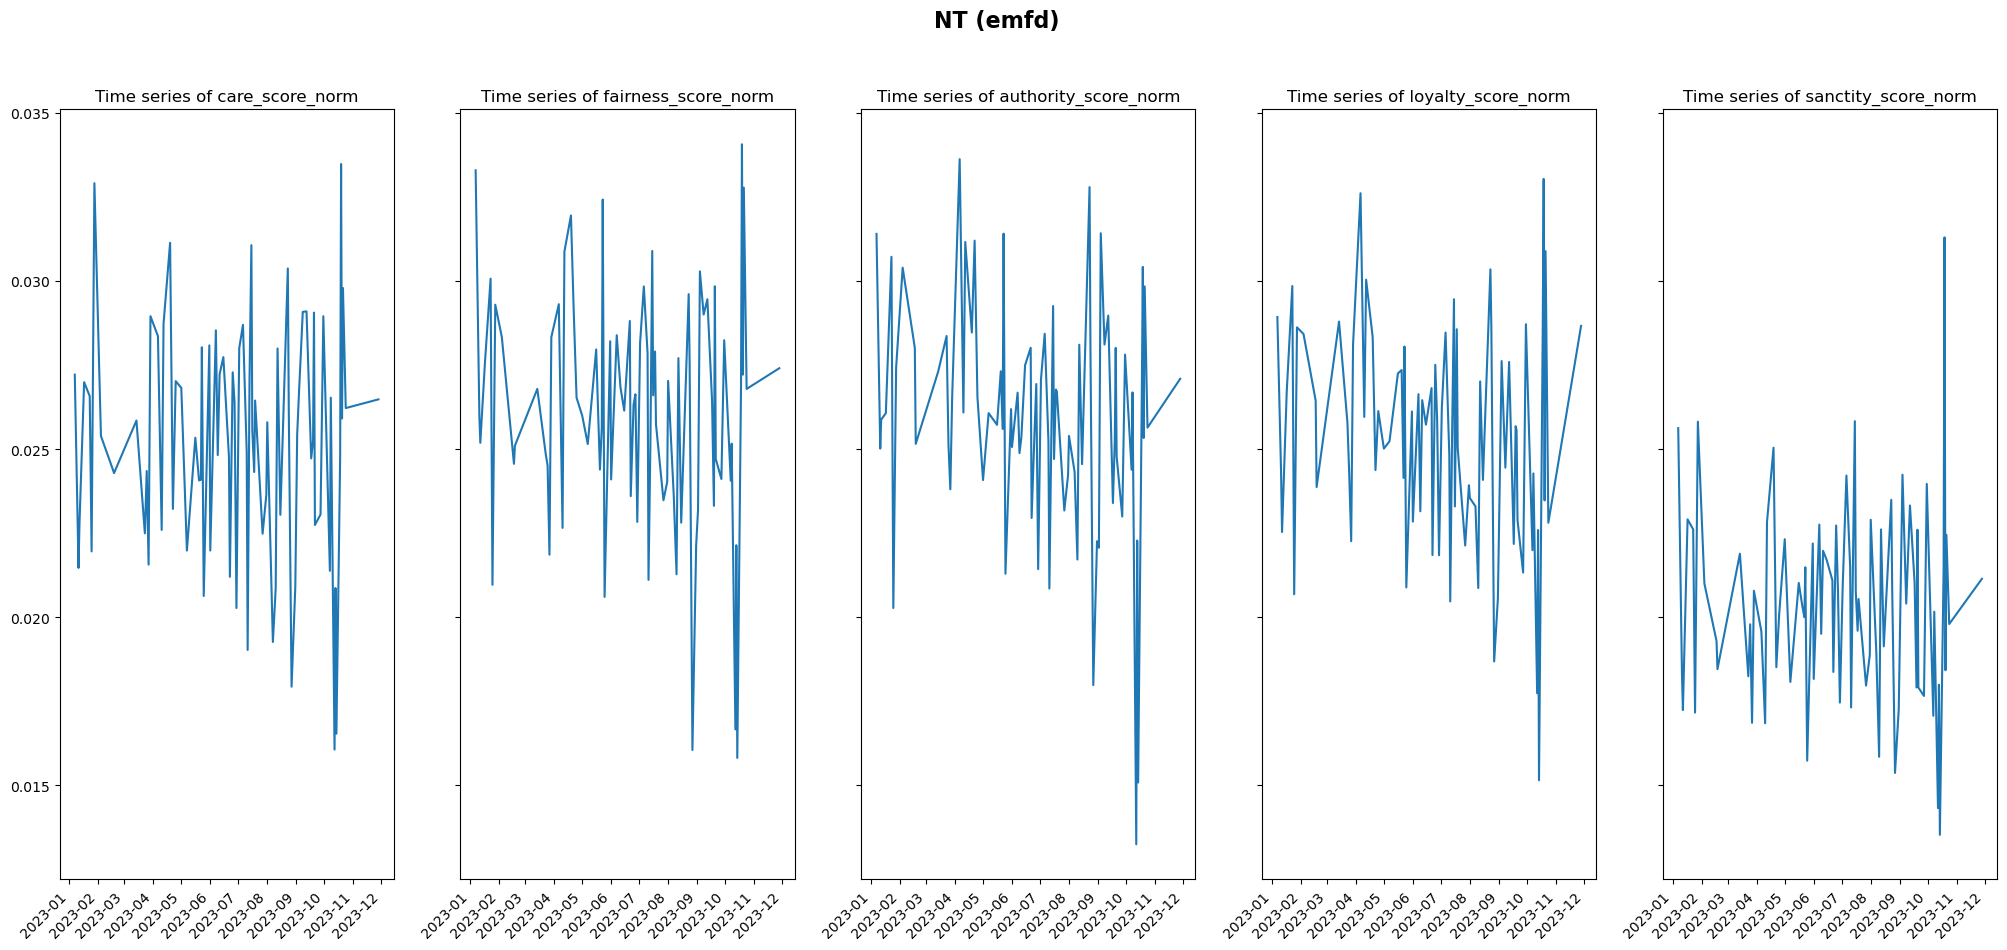

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

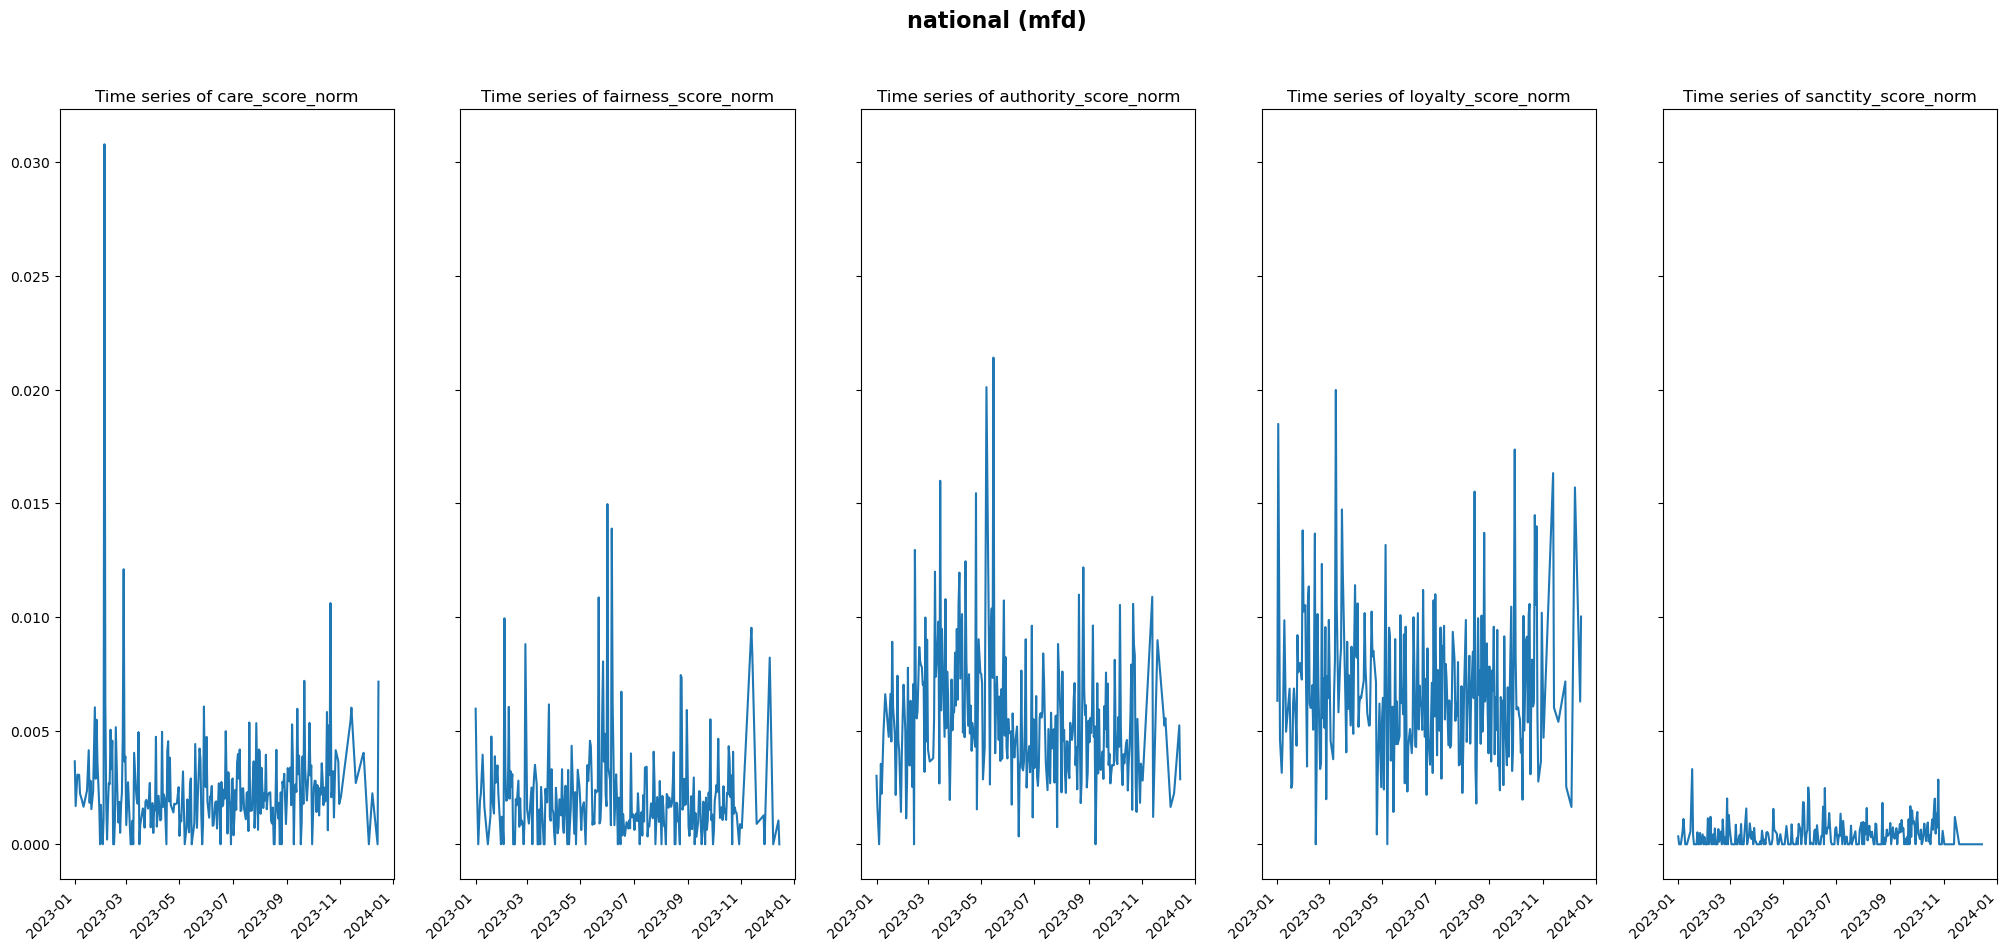

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

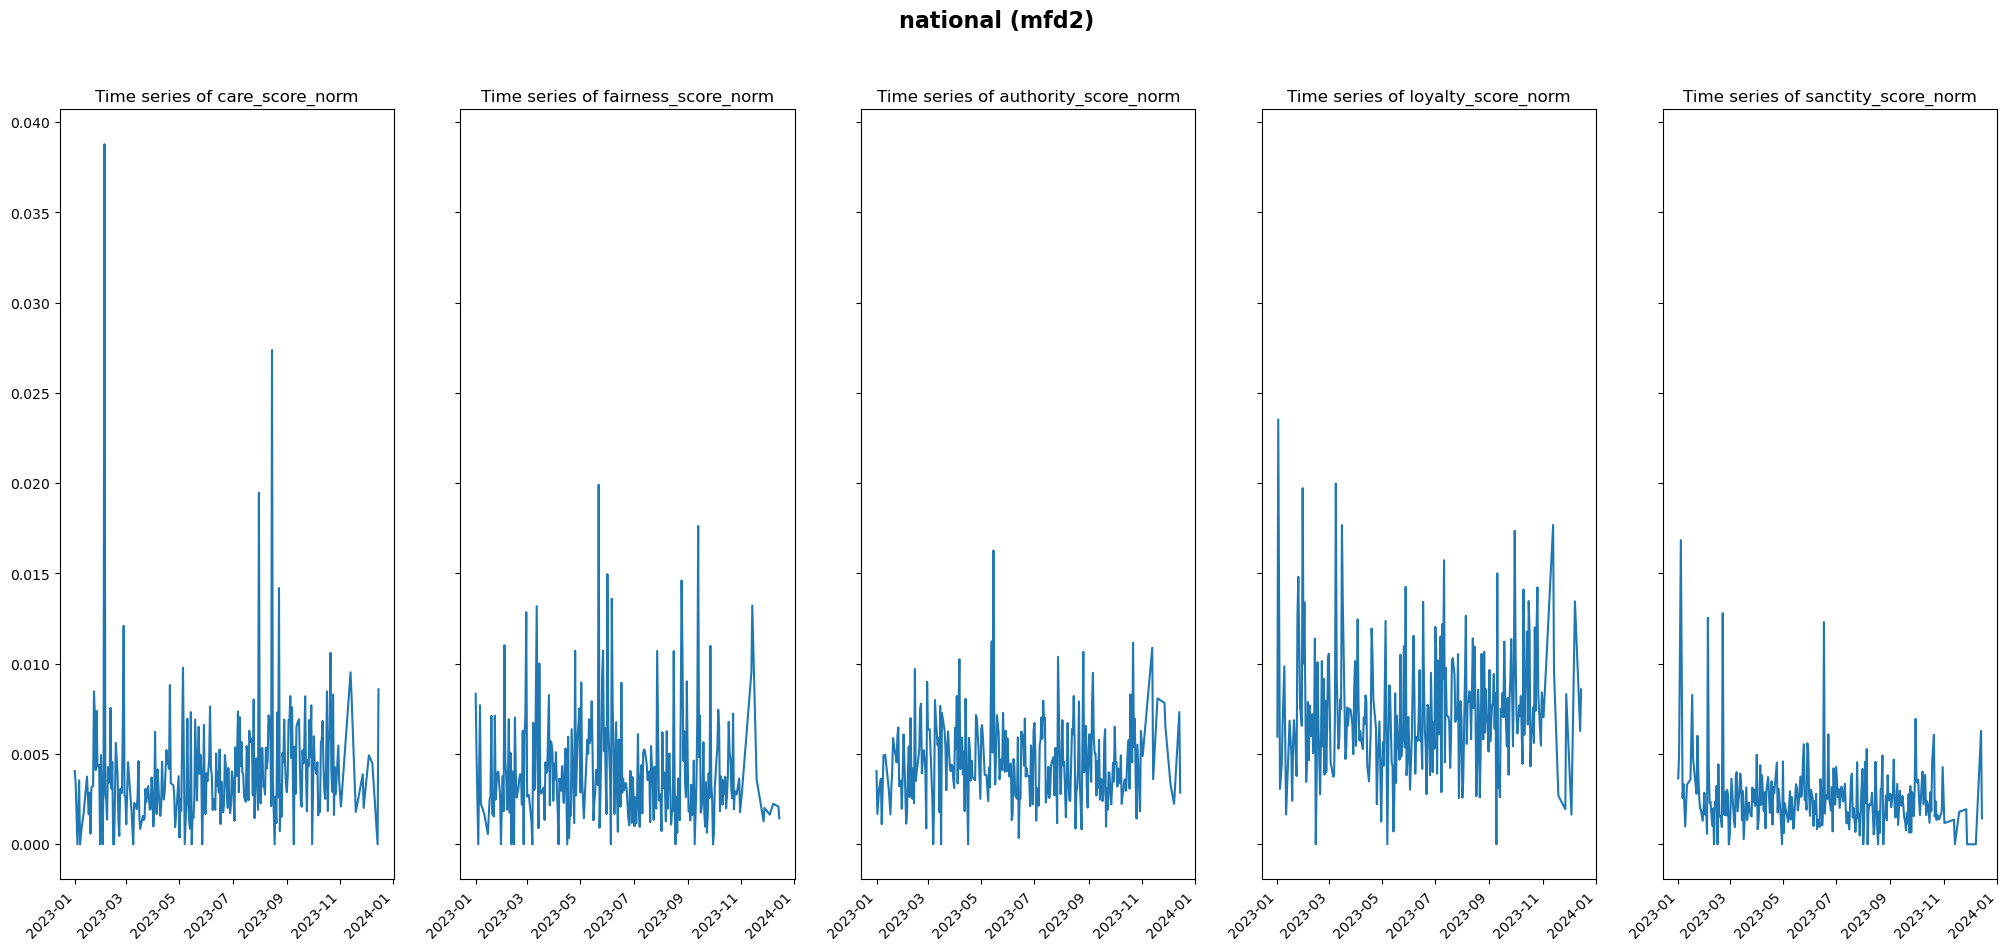

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

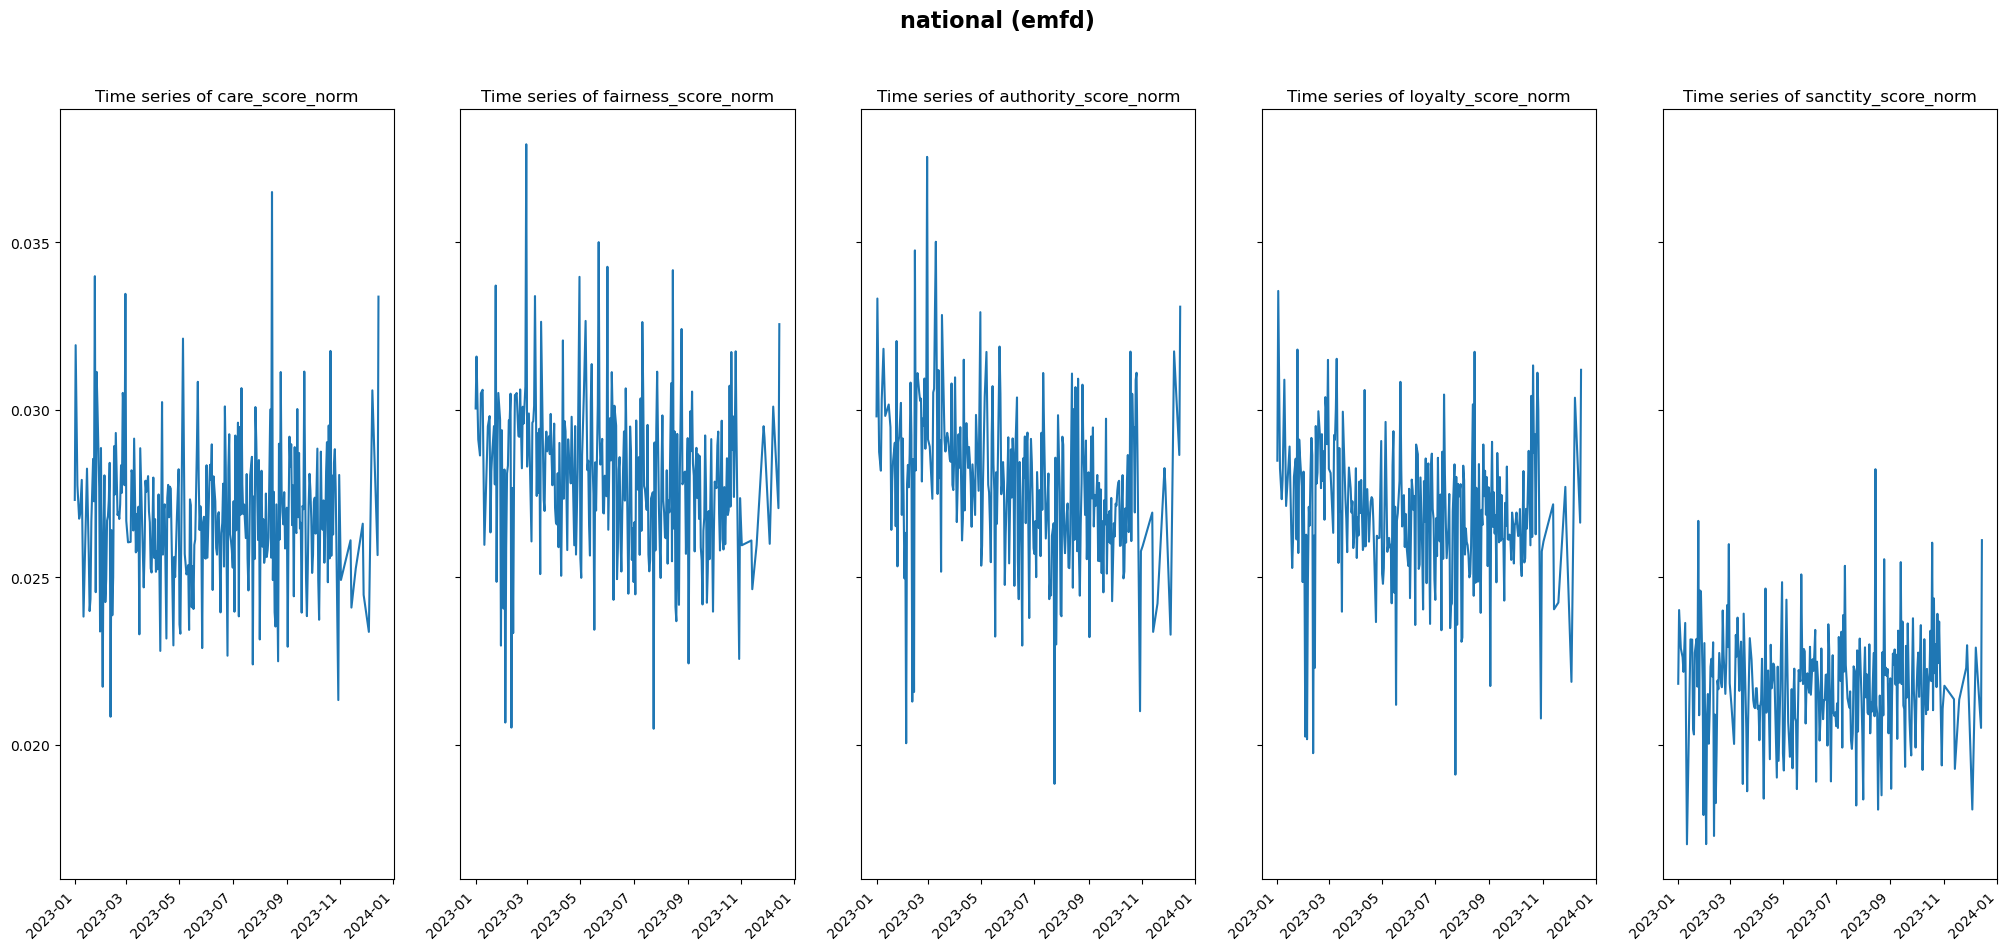

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

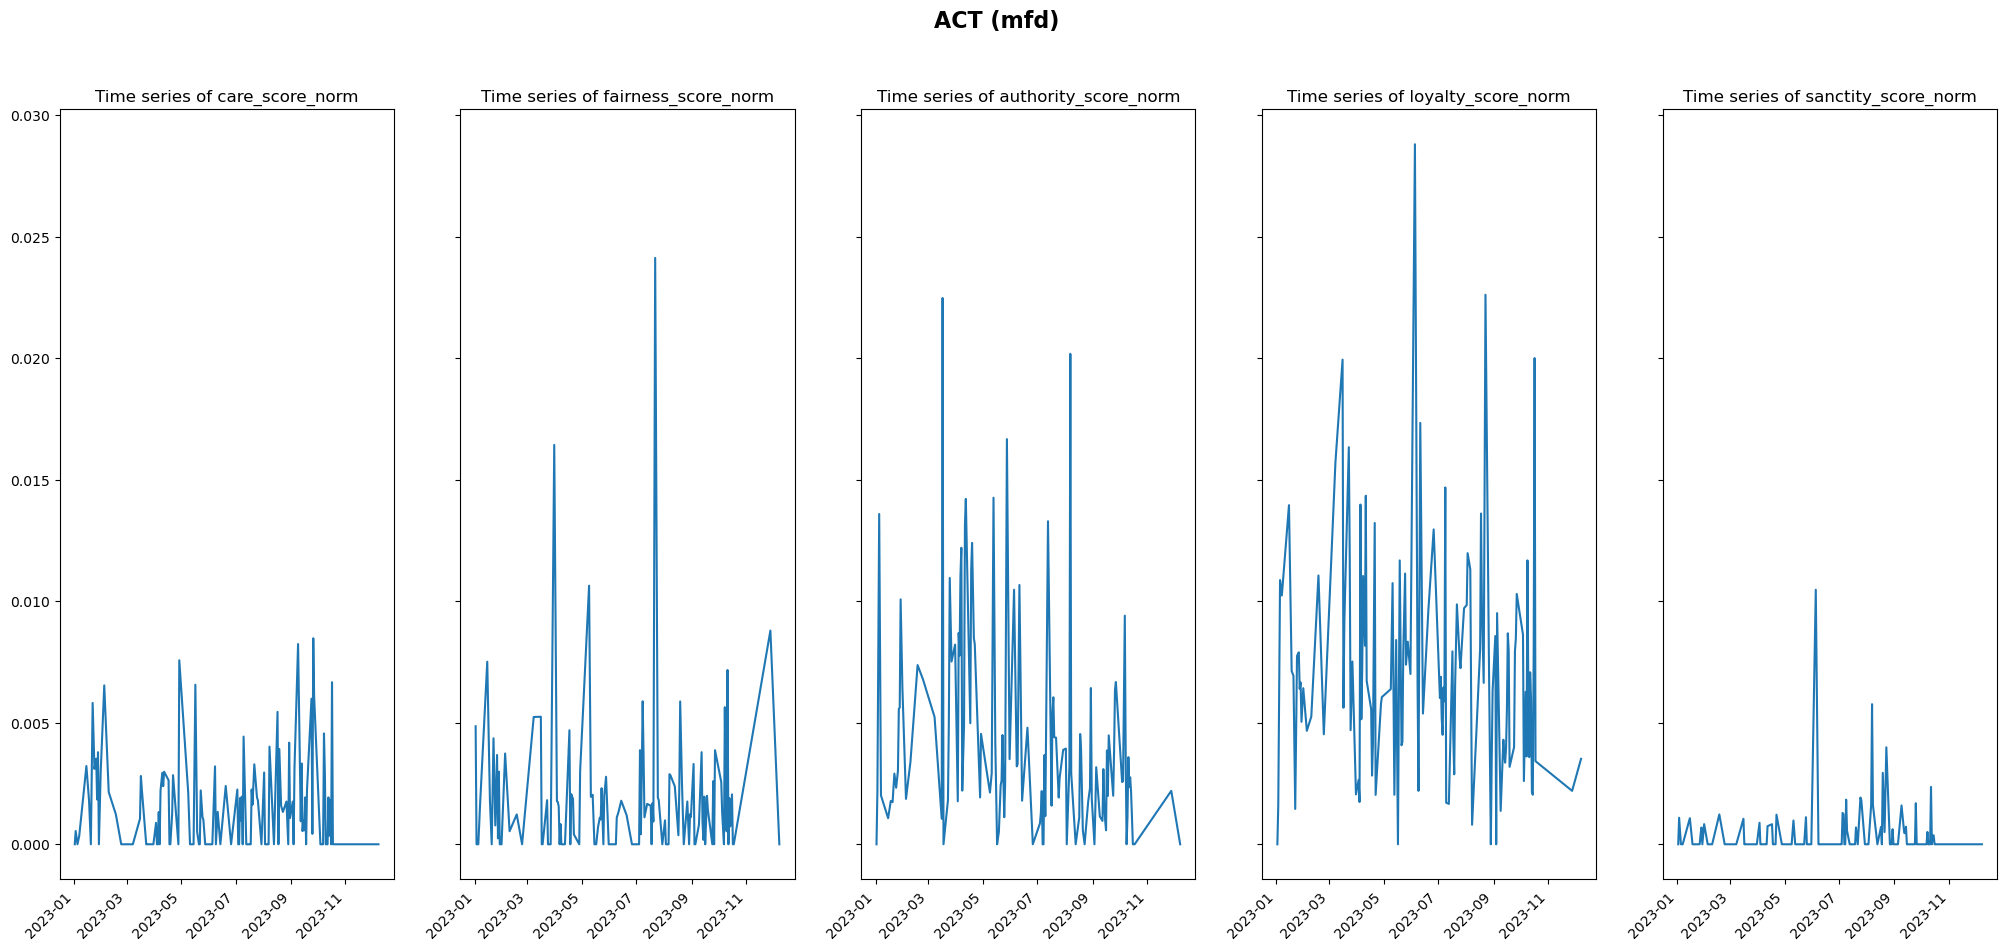

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

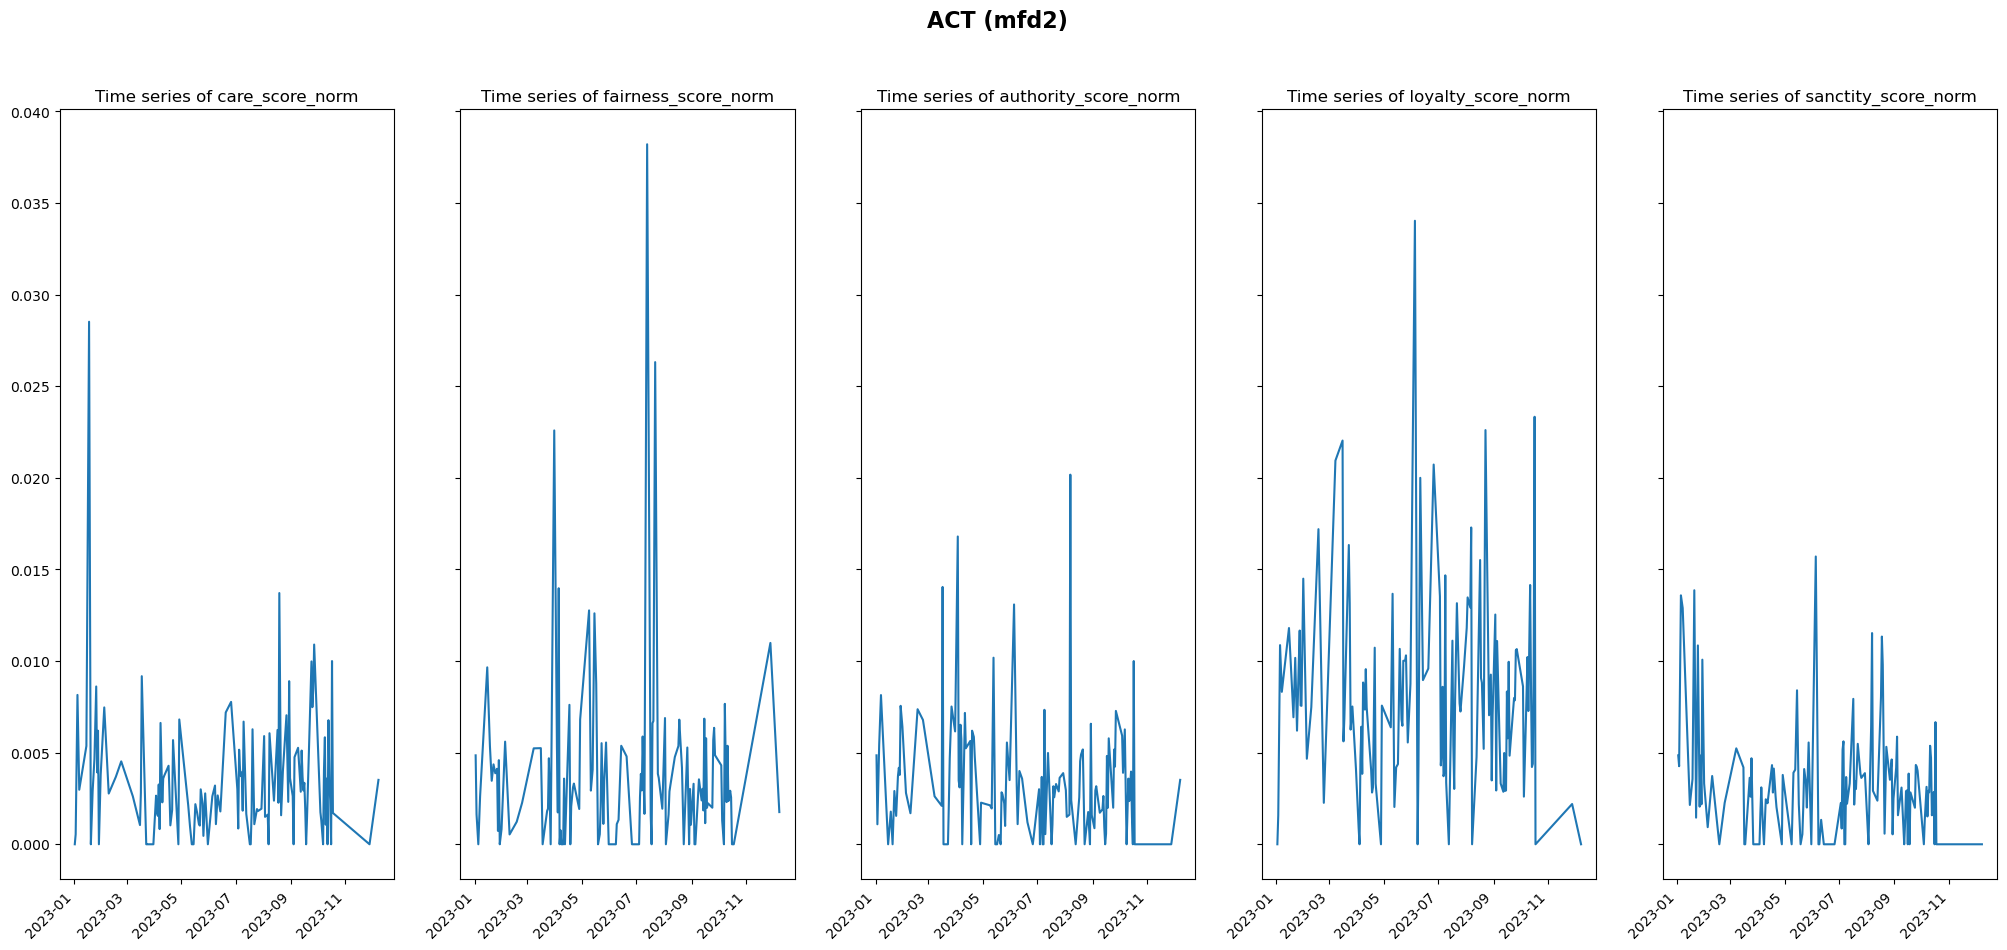

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

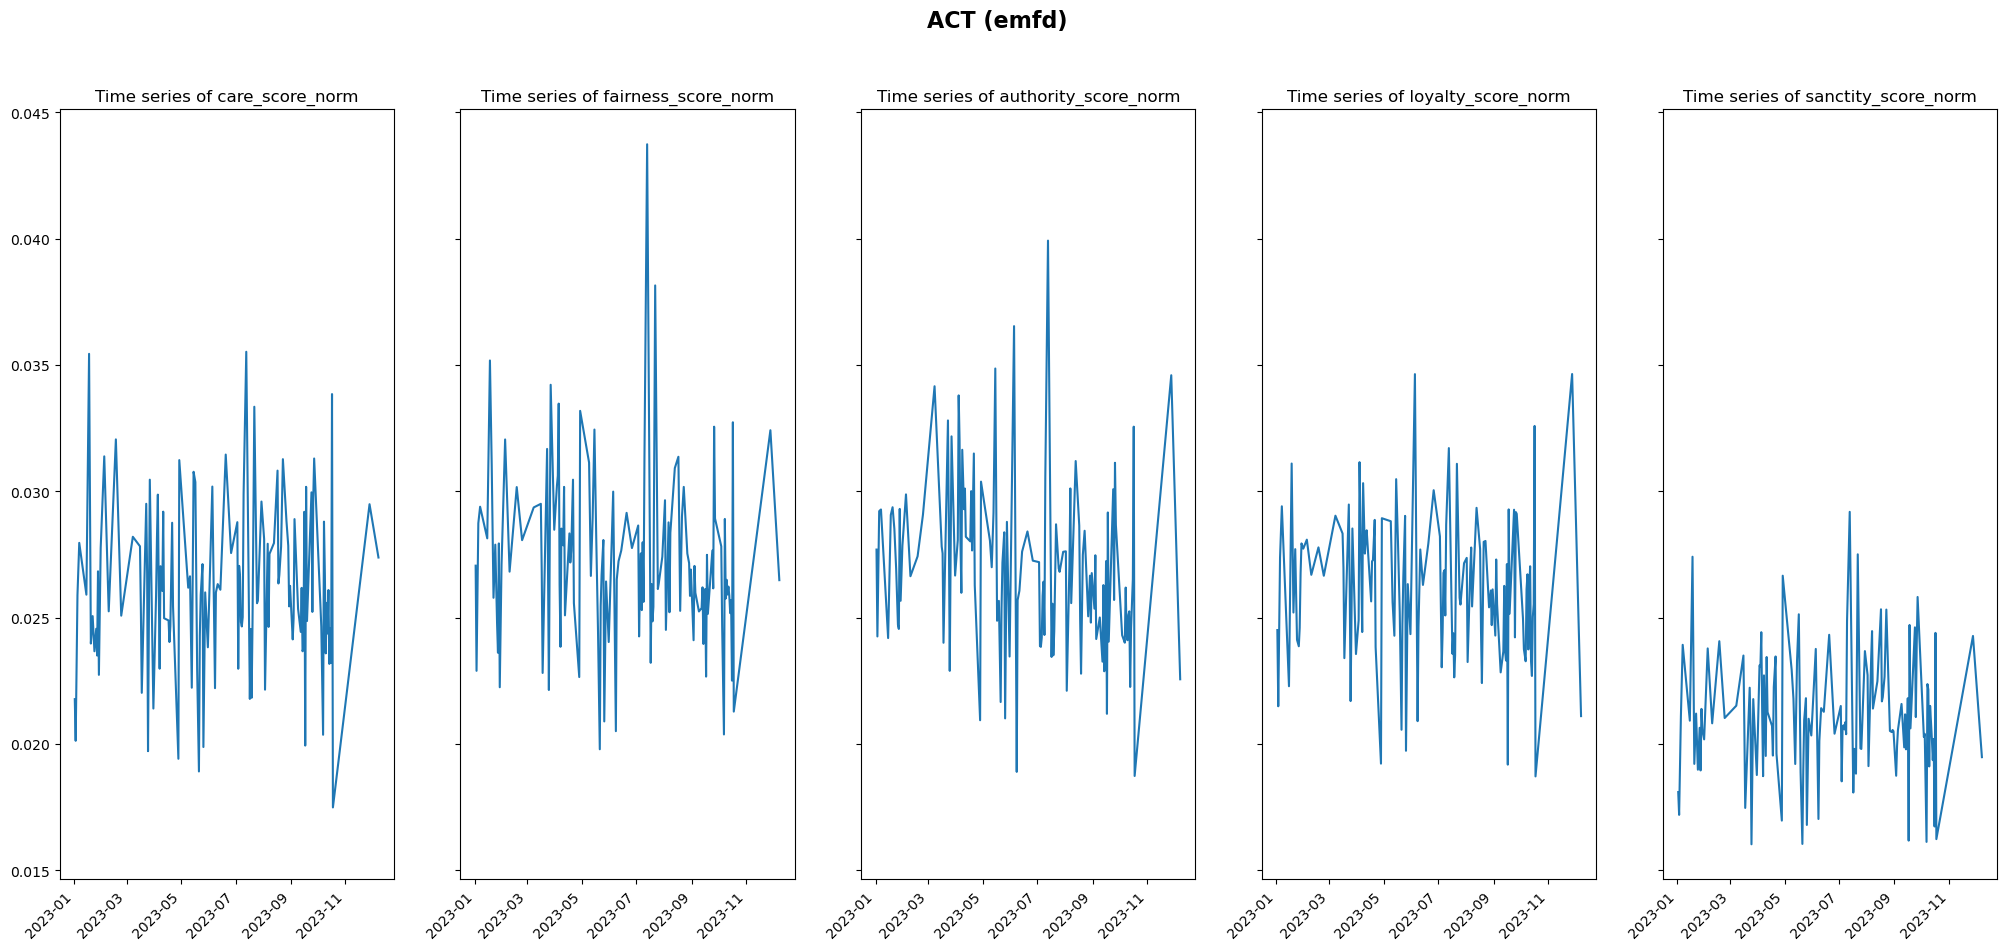

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

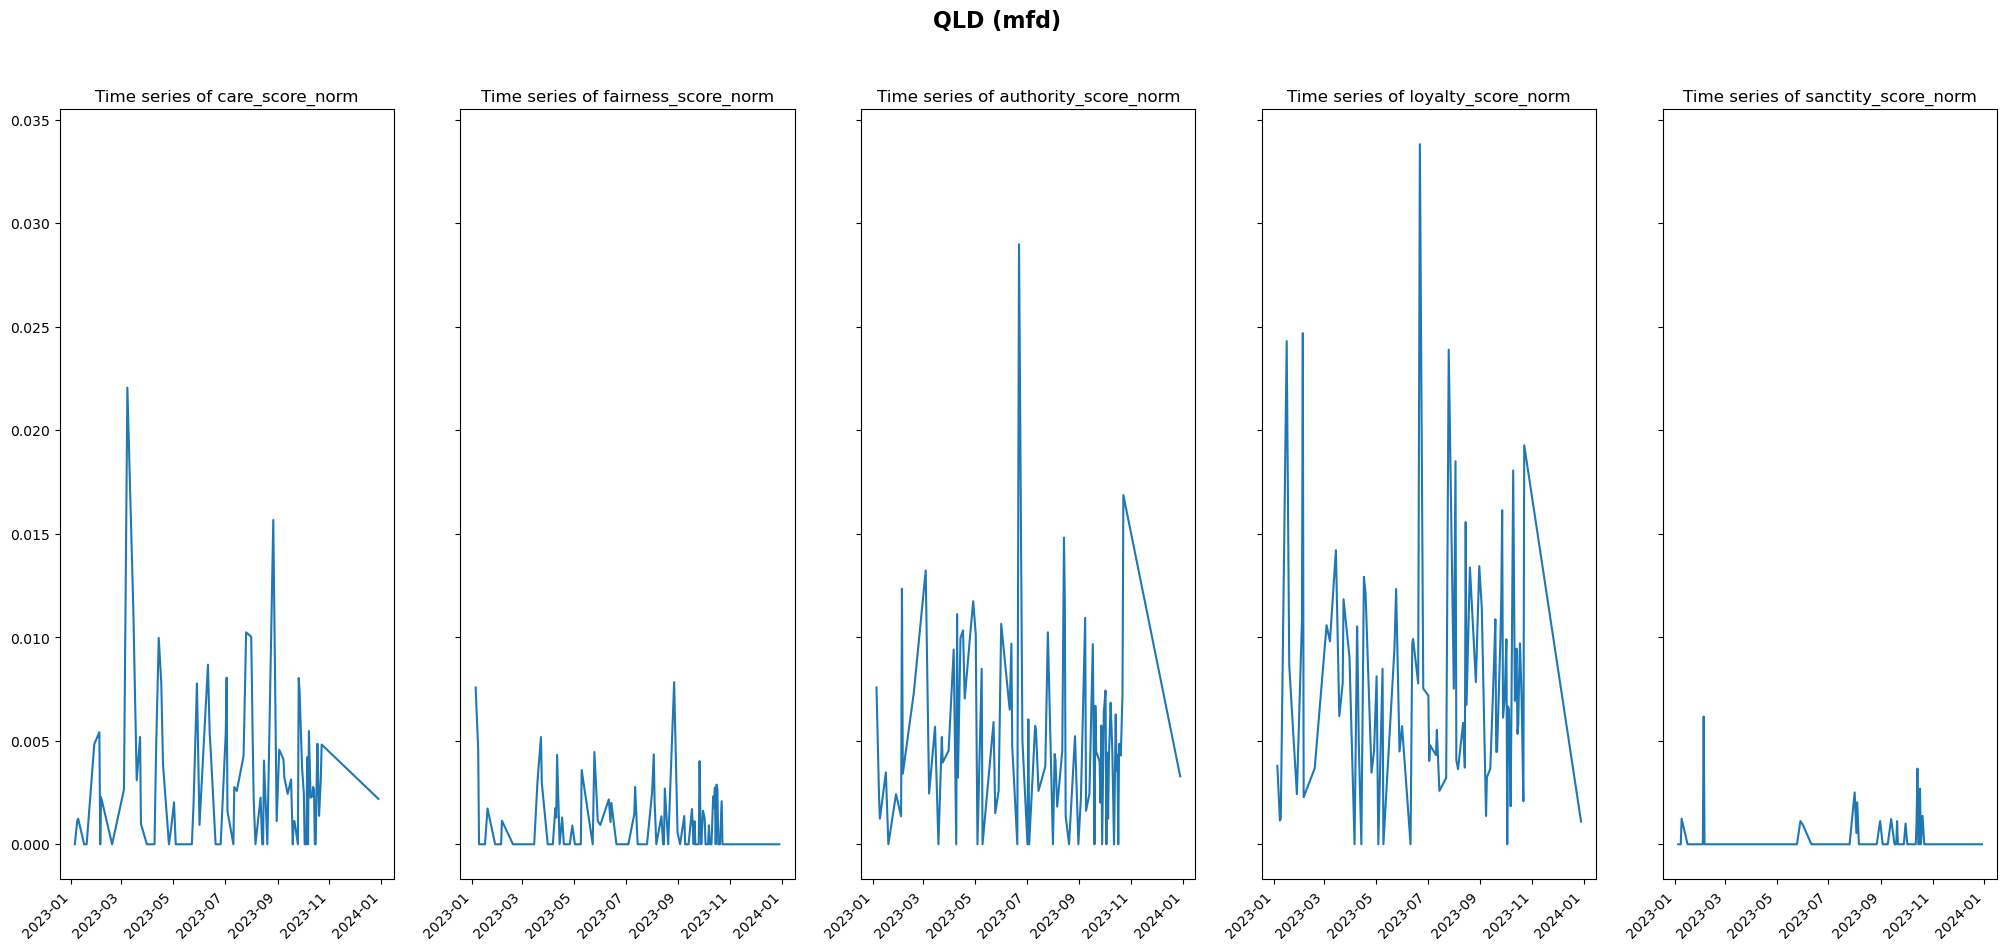

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

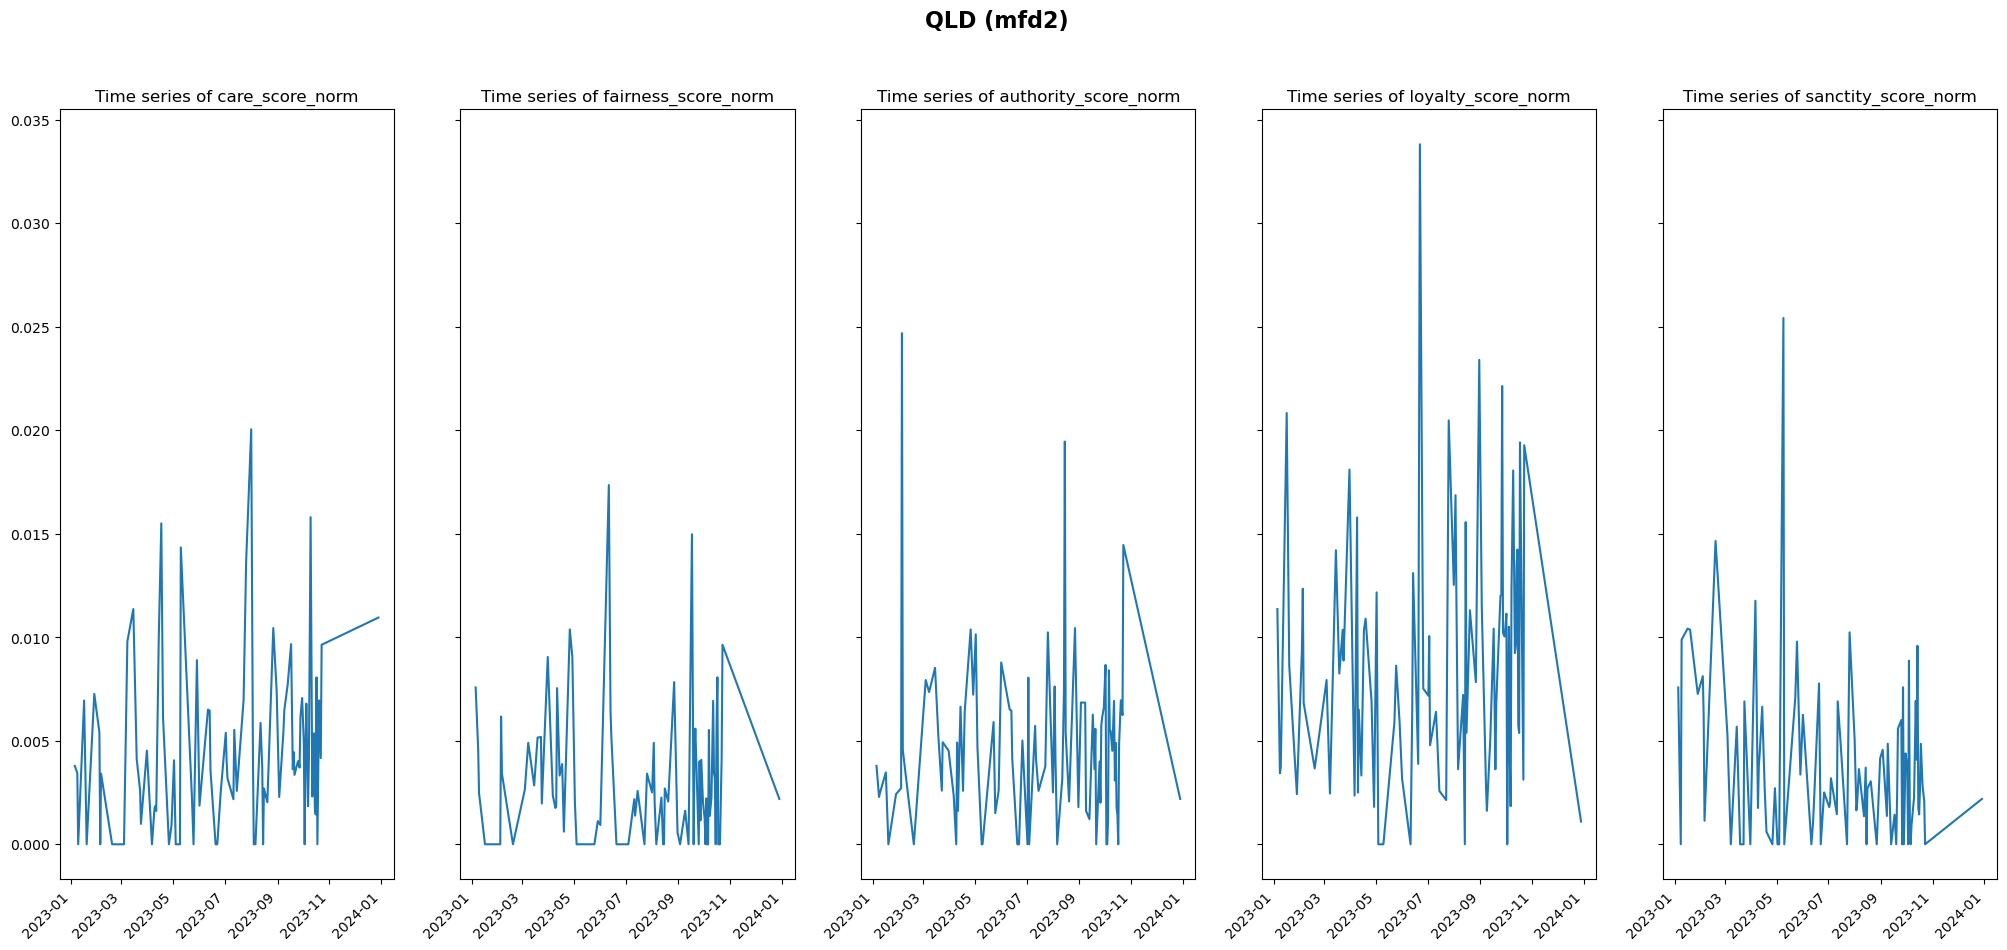

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

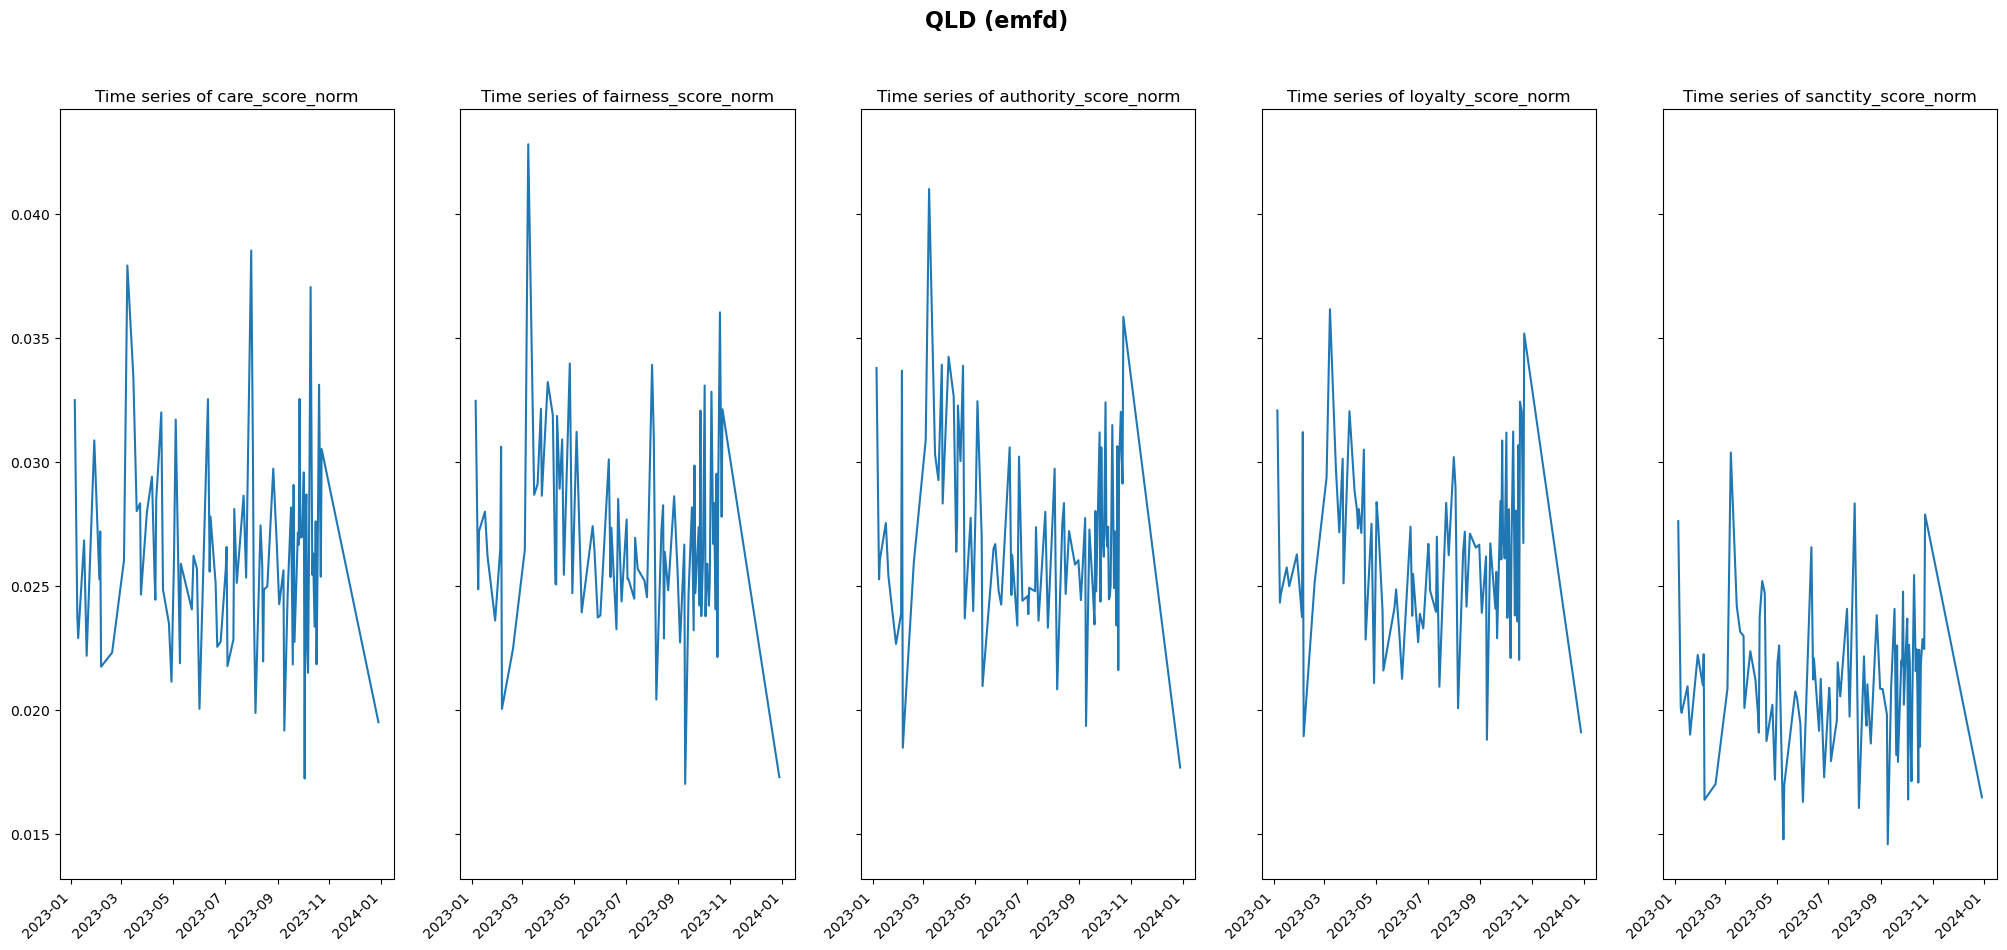

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

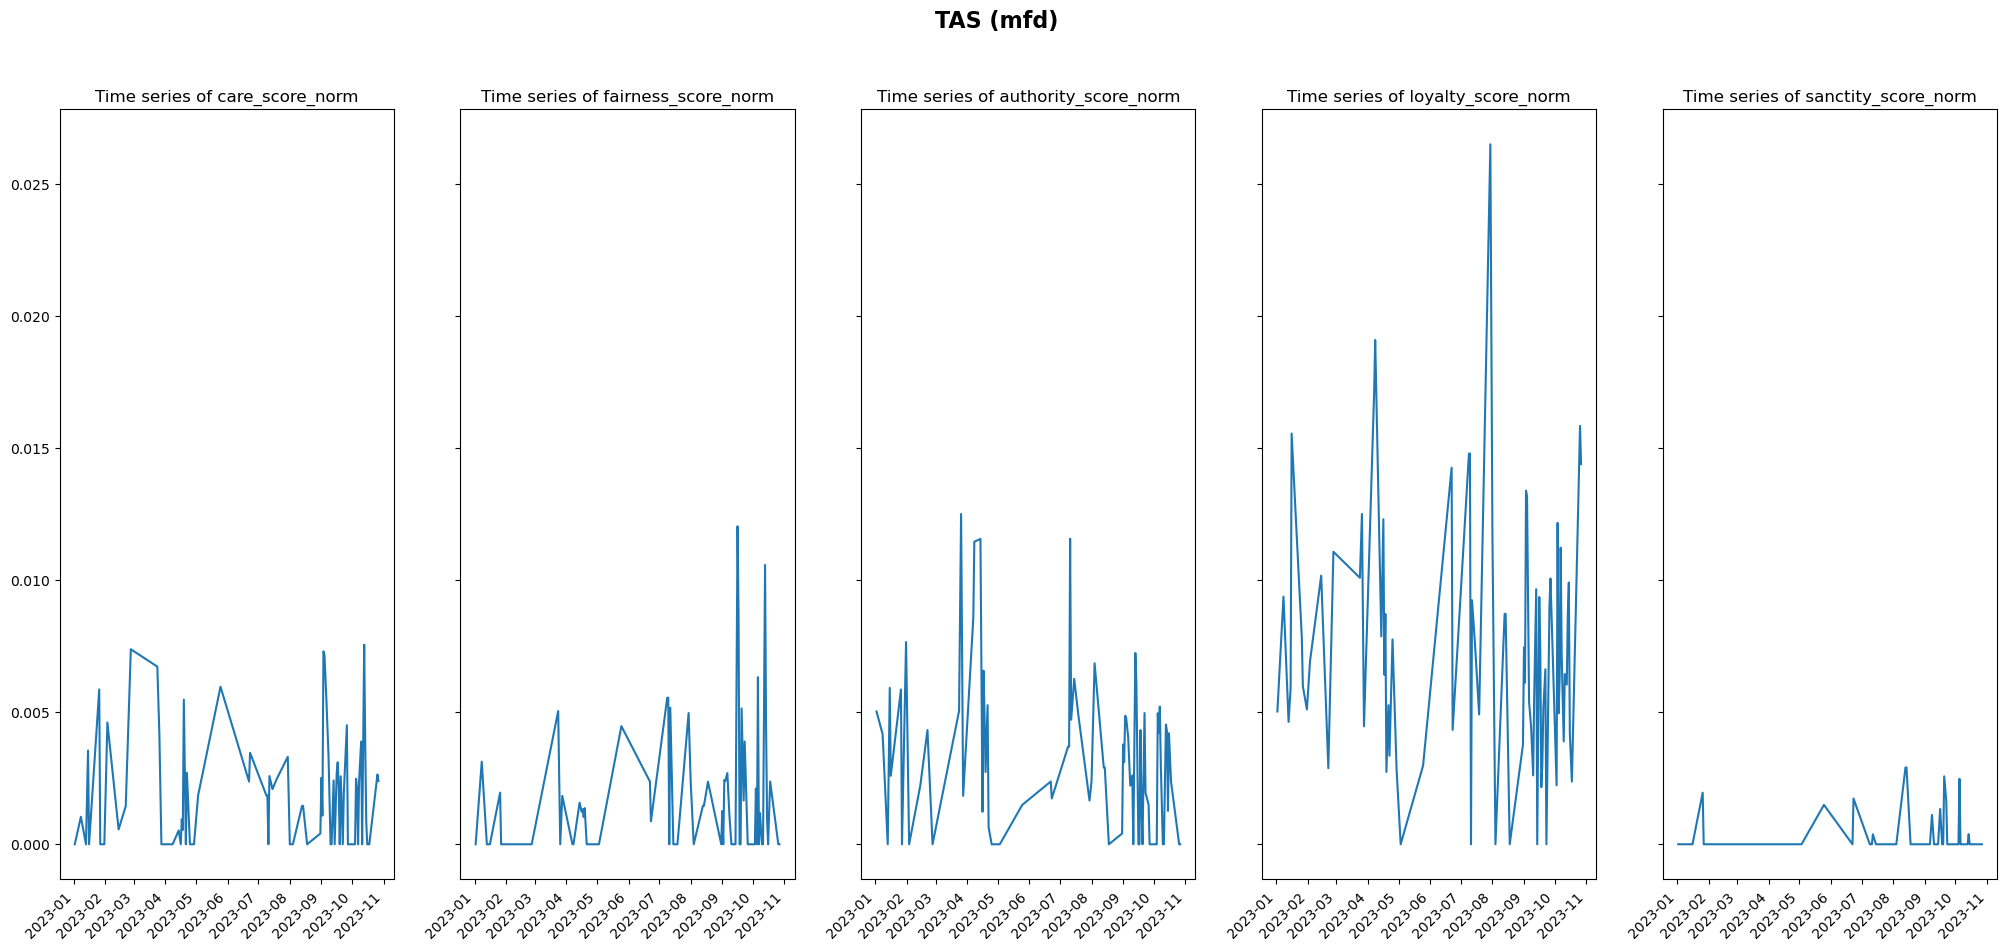

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

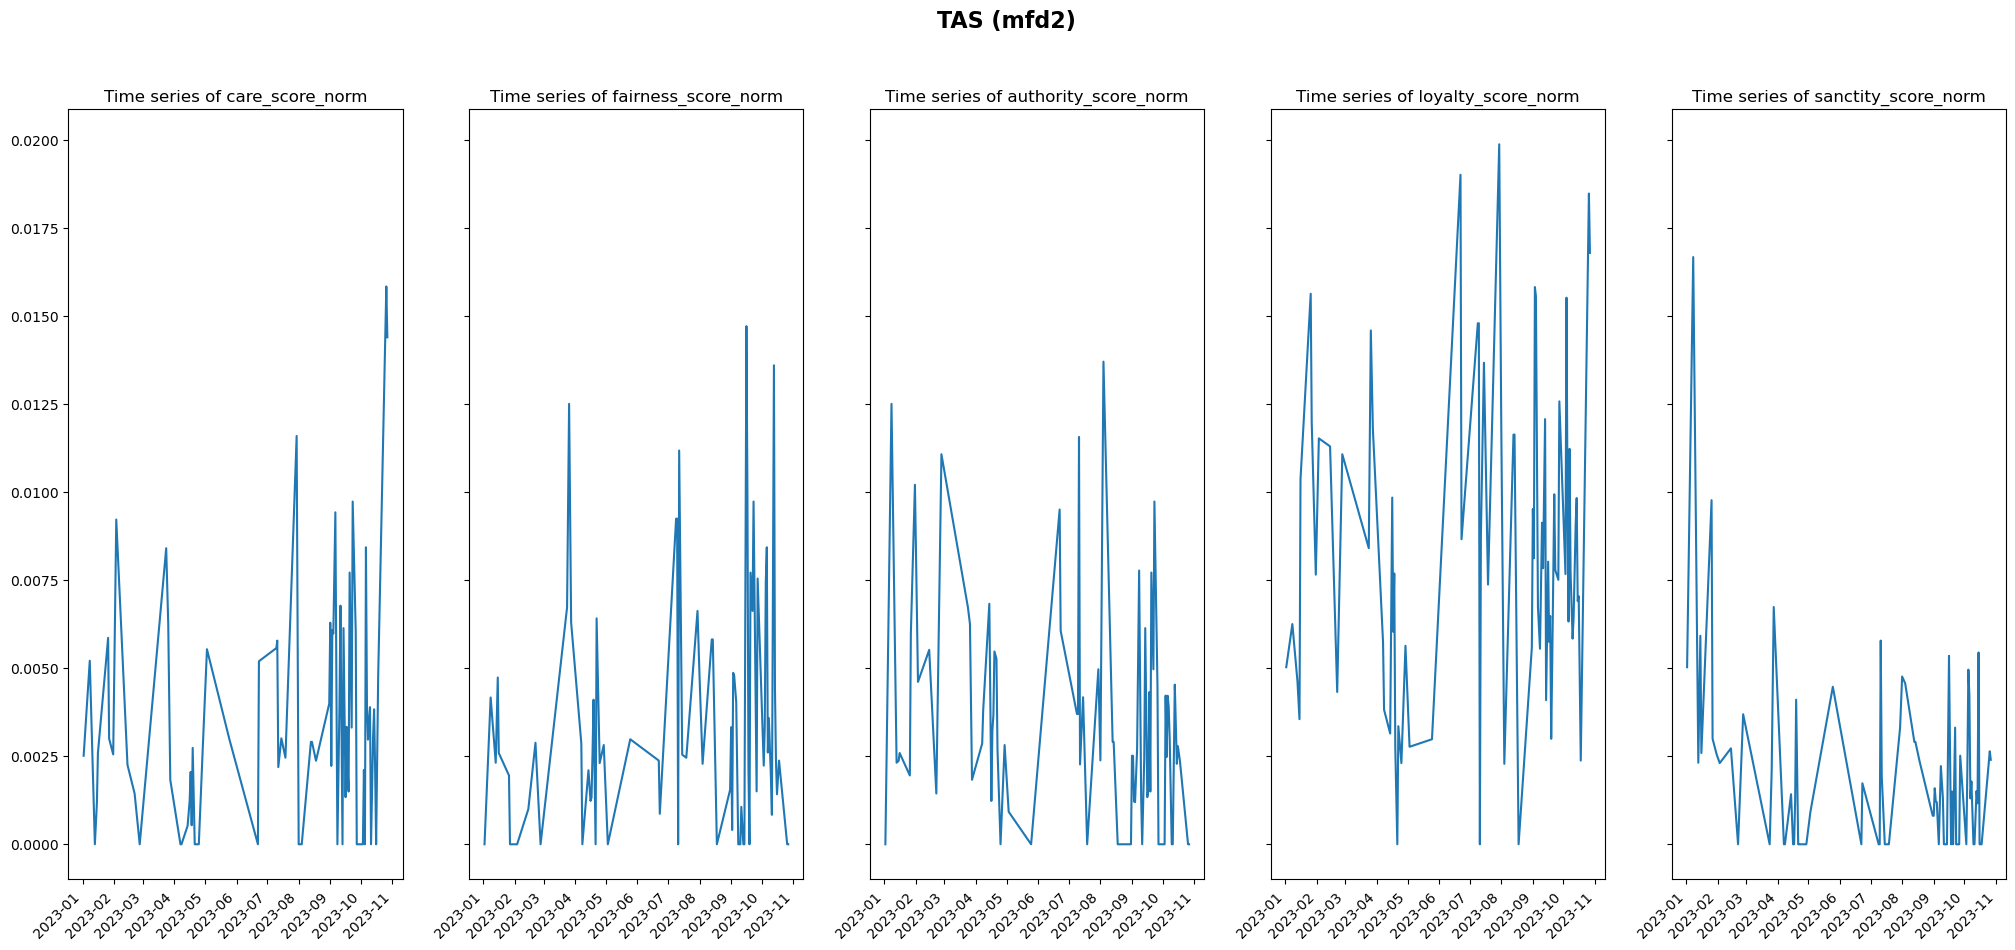

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

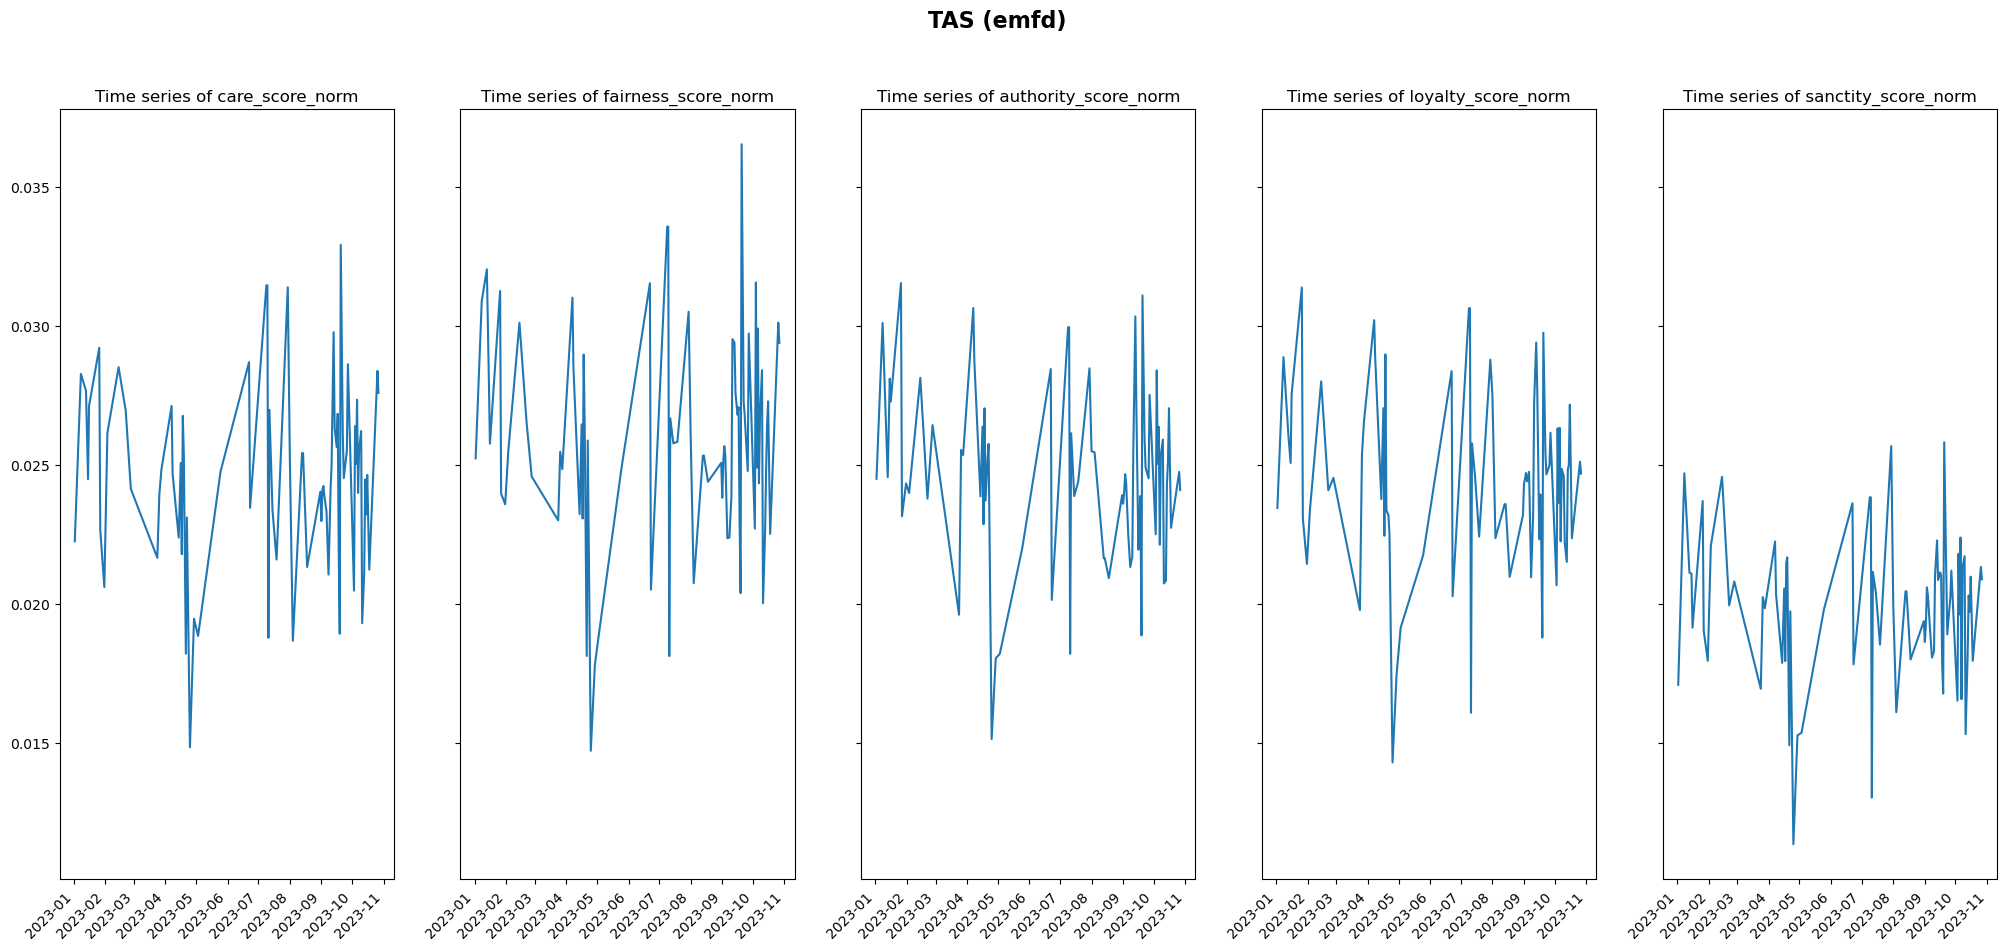

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

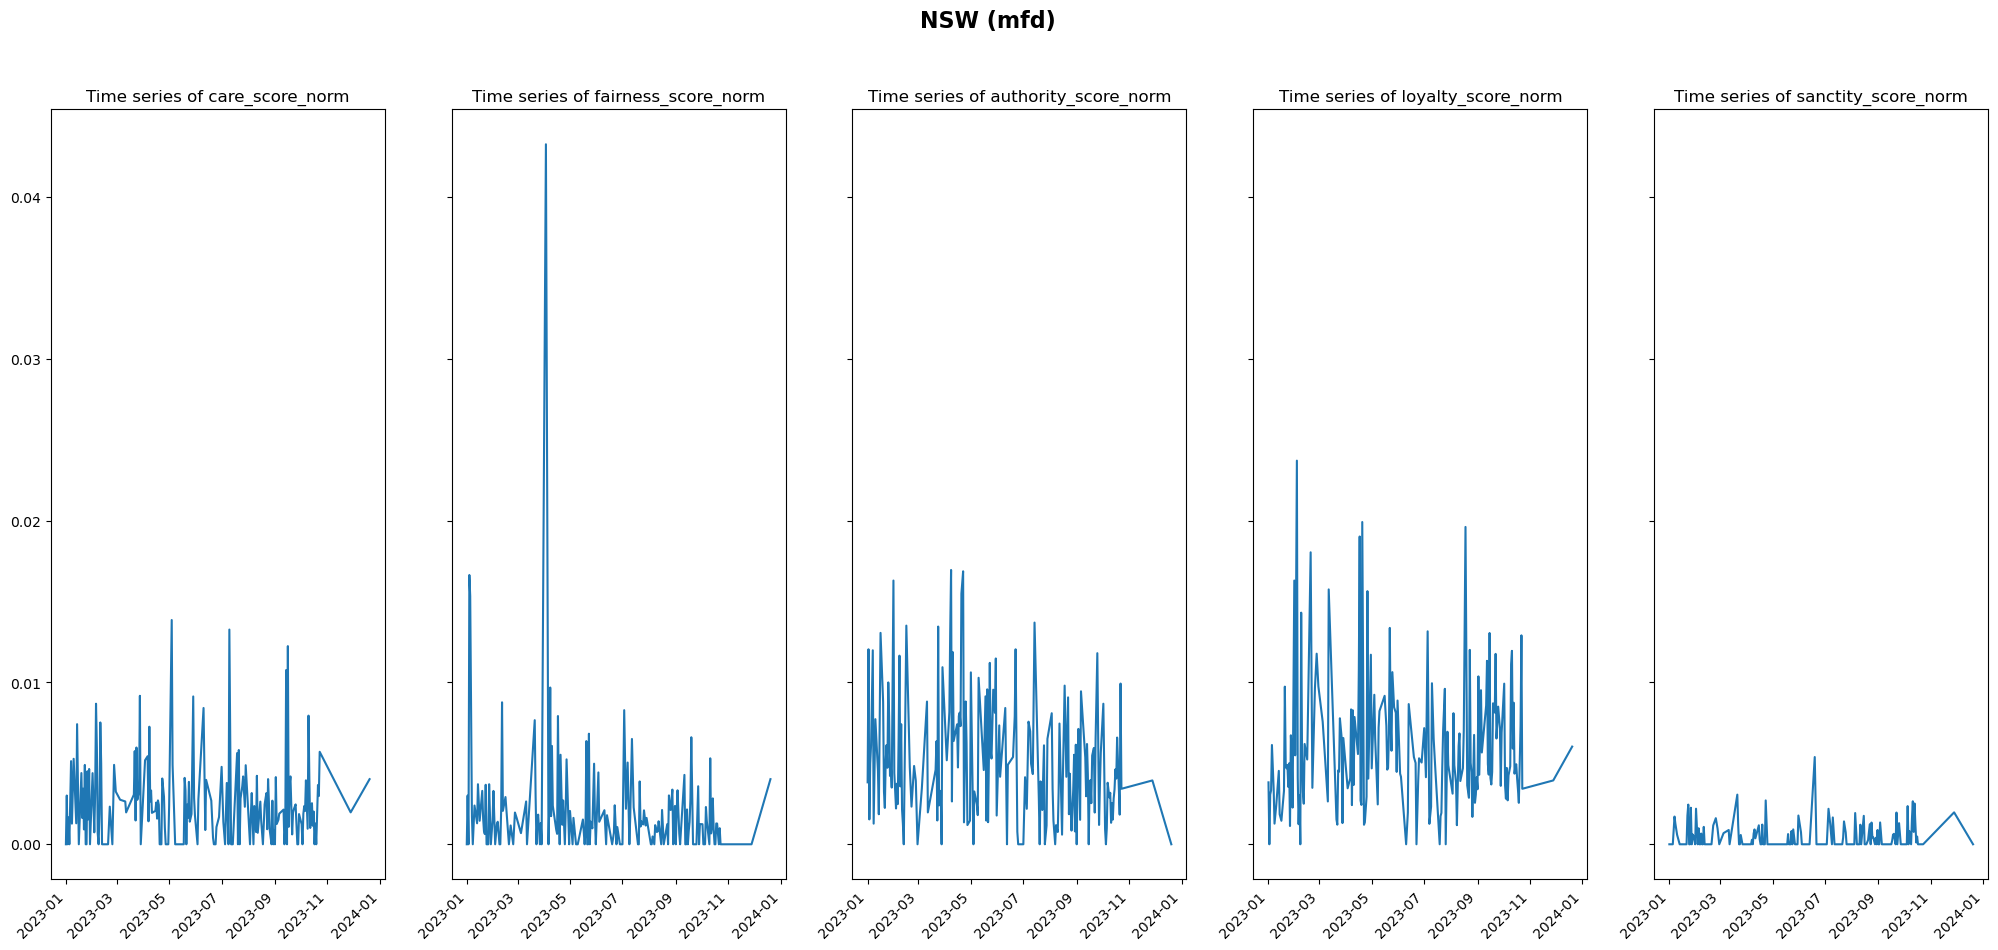

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

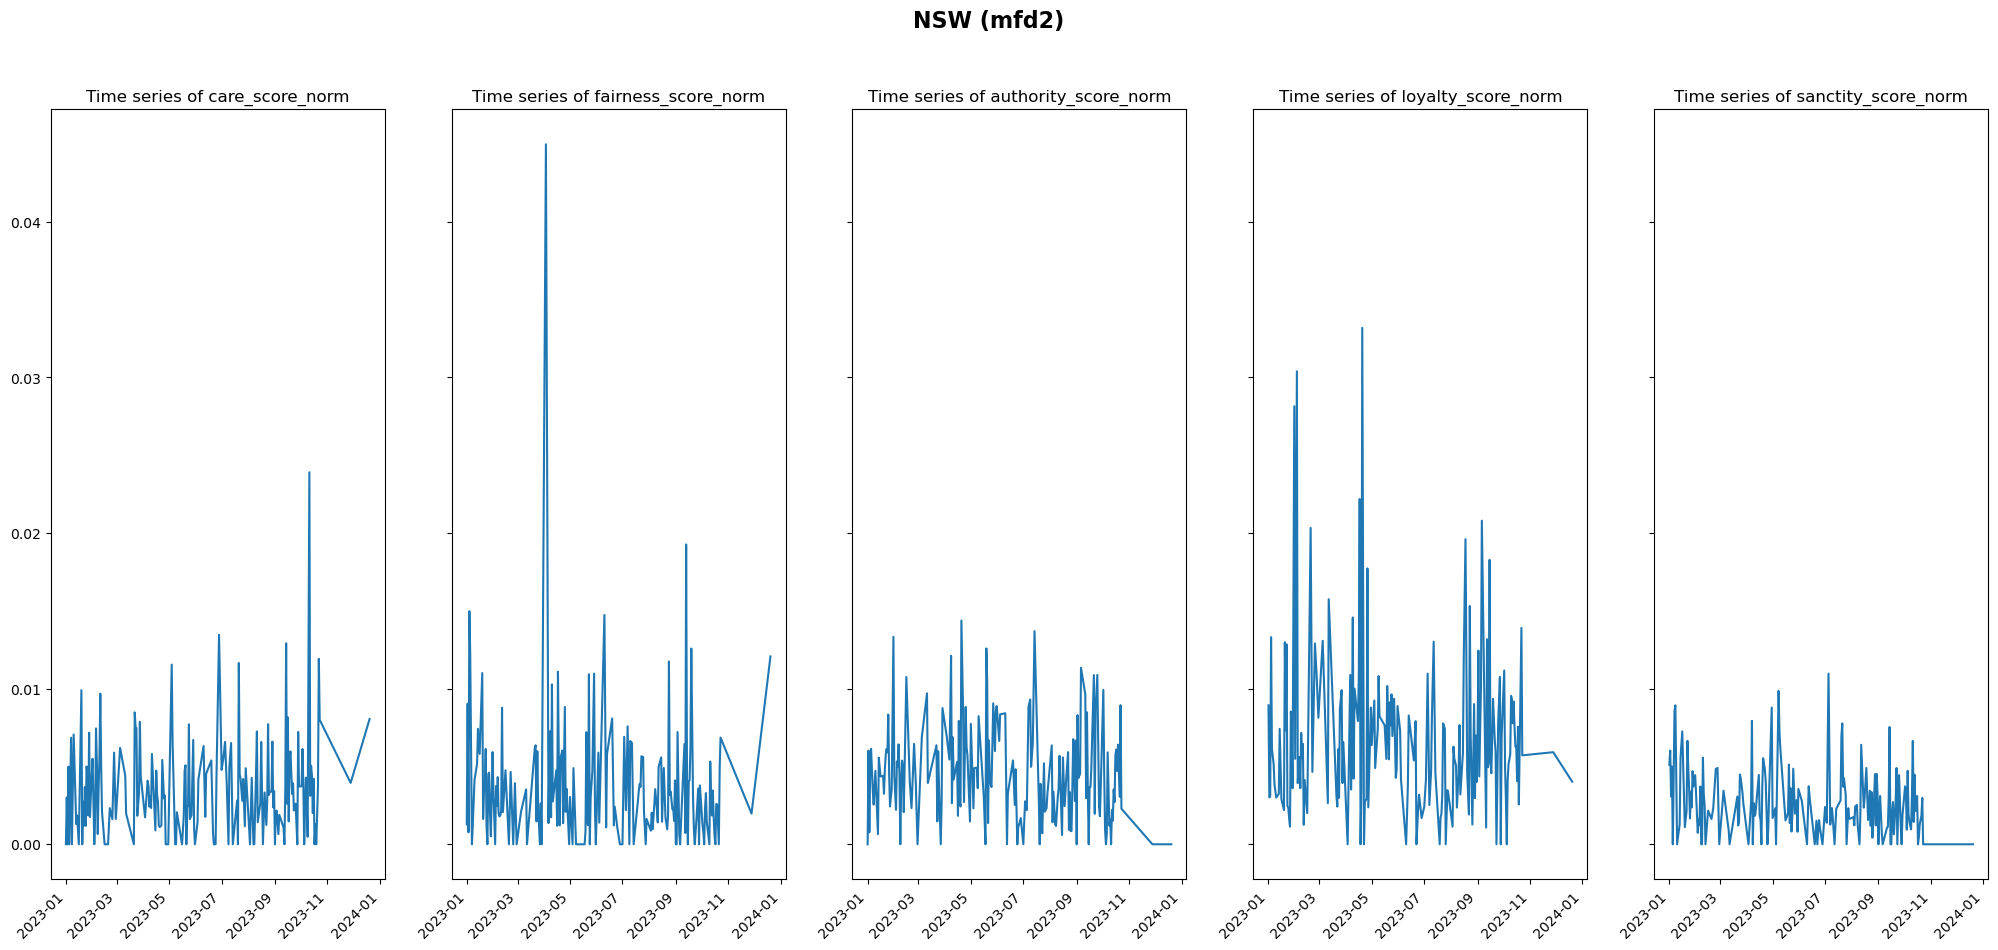

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_48112/2656414111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

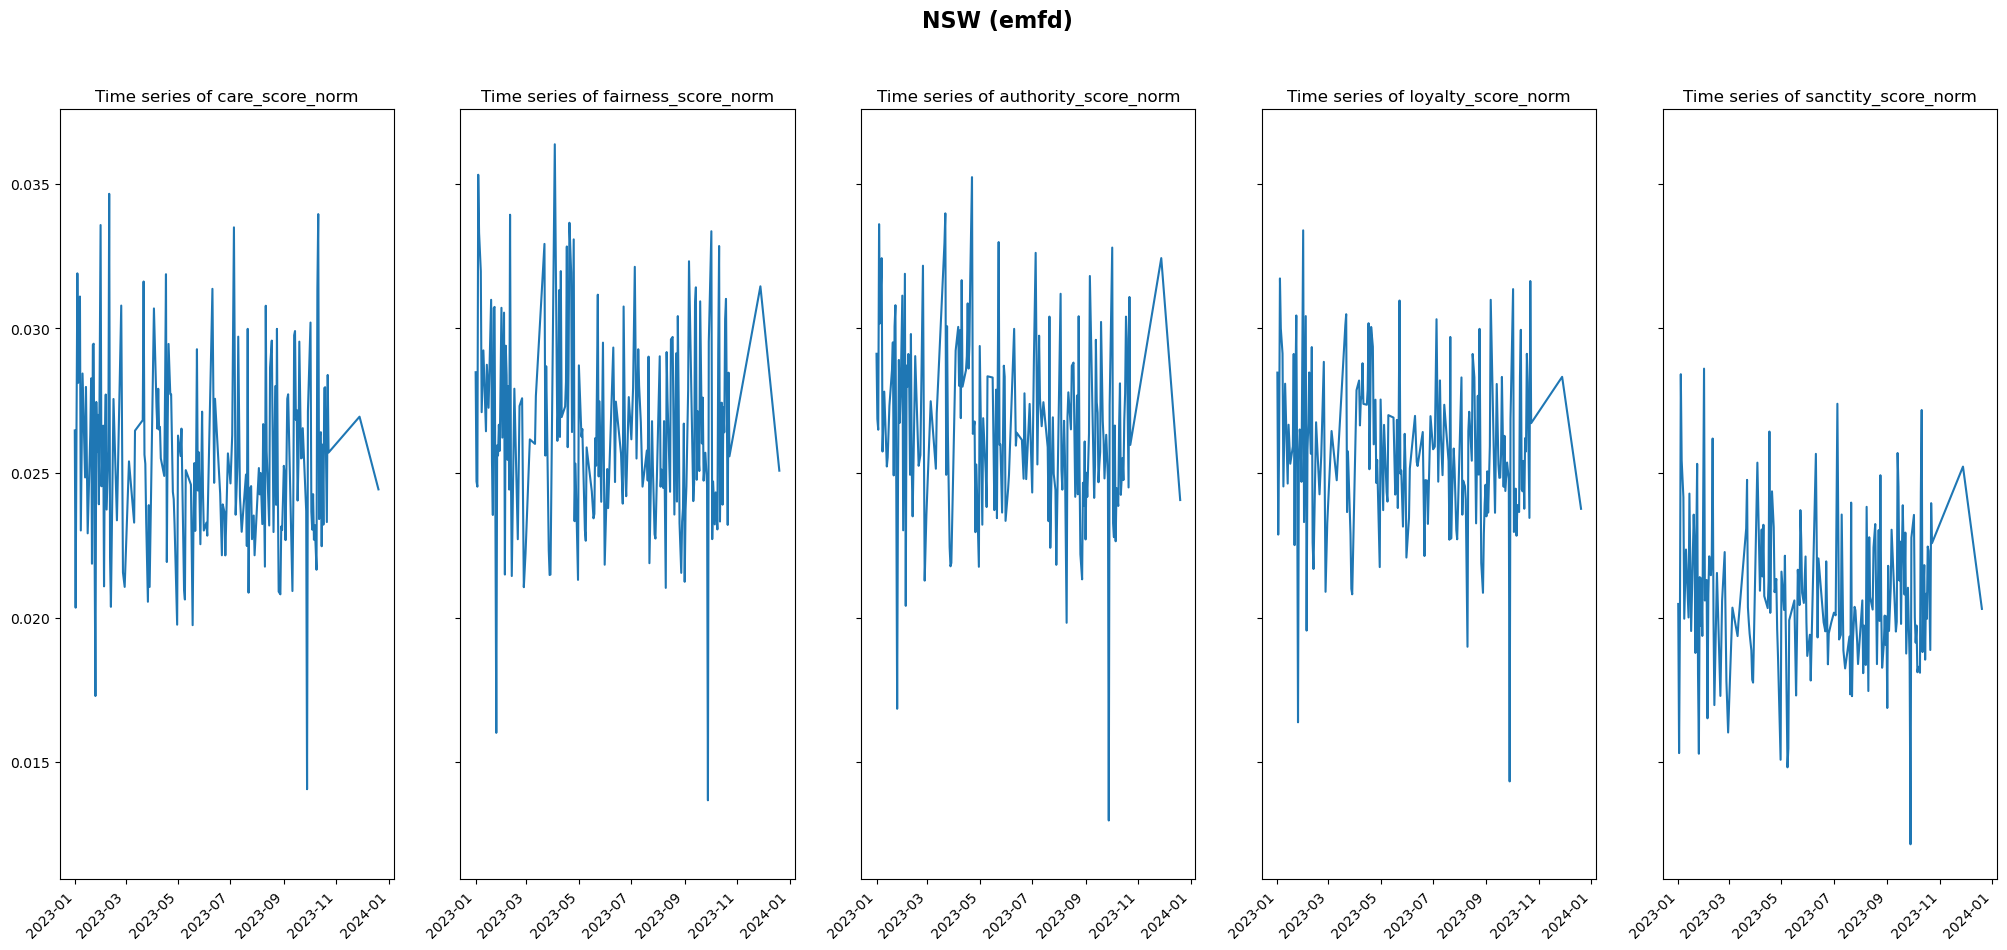

In [18]:
state_list =  [state for state in list(set(df_list[0]['state']))]
    
mfd_vers = ['mfd', 'mfd2', 'emfd']
for state in state_list:
    for k in range(len(df_list)):
        mfd_ver = mfd_vers[k]
        df_target = df_list[k]
        df_state_ts = df_target[['care_score_norm', 'fairness_score_norm', 'authority_score_norm', 'loyalty_score_norm', 'sanctity_score_norm', 'state', 'date']].groupby(['state', 'date']).mean().copy()
        df_state_ts.reset_index(inplace=True)

    
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 10), sharey=True)

        foundations = ['care', 'fairness', 'authority', 'loyalty', 'sanctity']
        for i in range(5):
            f = foundations[i]
            axs[i].plot(df_state_ts[df_state_ts['state']==state]["date"], 
                df_state_ts[df_state_ts['state']==state][f'{f}_score_norm'], 
            )

            axs[i].set_title(f'Time series of {f}_score_norm')
            
            # Config grids
            # axs[i].grid(linestyle='--', linewidth=0.5)

        for ax in axs:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
        fig.suptitle(f'{state} ({mfd_ver})', fontsize=16, fontweight='bold')

        plt.show()